# Import Libraries

In [606]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, make_scorer, mean_squared_error, mean_absolute_percentage_error
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import randint, uniform

In [608]:
df1 = pd.read_csv("/Users/verapinto/Desktop/Final_Project/Data_Science_E2E_Project/Forecast.csv")
df1.head()

Month-Year  PRODUCT_FAMILY    GMID    LOC Country Sales    Forecast    MAPE  \
0     23-Jul               6  600001  KR001      KR   909  868.279179   4.50%   
1     23-Aug               6  600001  KR001      KR   786  867.675973  10.40%   
2     23-Sep               6  600001  KR001      KR   846  906.330589   7.10%   
3     23-Oct               6  600001  KR001      KR   761  907.327425  19.20%   
4     23-Nov               6  600001  KR001      KR   786  868.000000  10.40%   

  MAPE_Impact MAPE_Contribution  Absolute Error  Non Absolute Error  
0       0.00%             0.00%       40.720821          -40.720821  
1       0.01%             0.00%       81.675973           81.675973  
2       0.01%             0.00%       60.330590           60.330590  
3       0.01%             0.10%      146.327425          146.327425  
4       0.01%             0.00%       82.000000           82.000000

In [610]:
df1.shape

(18159, 12)

In [612]:
df2 = pd.read_csv("/Users/verapinto/Desktop/Final_Project/Data_Science_E2E_Project/Stocks.csv")
df2.head()

Product.Family    GMID GMID_Description     Market      Geography  \
0               6  600001     06 2.9MG/5ML      Korea  International   
1               6  600002     06 2.9MG/5ML  Hong Kong  Greater China   
2               6  600003     06 2.9MG/5ML     Canada  North America   
3               6  600004     06 2.9MG/5ML   Malaysia  International   
4               6  600005     06 500IU/5ML  Australia  International   

  Material.Type.GMID    Date  Coverage   Min   Max  
0                 FG  23-Jul      1.82  2.73  4.91  
1                 FG  23-Jul      3.09  2.86  5.68  
2                 FG  23-Jul      3.41  2.73  5.68  
3                 FG  23-Jul      0.91  3.18  9.14  
4                 FG  23-Jul      0.91  2.73  4.59

In [614]:
df2.shape

(24234, 10)

In [616]:
df_geo  = pd.read_csv("/Users/verapinto/Desktop/Final_Project/Data_Science_E2E_Project/Countries_Geo.csv")
df_geo.head()

Country_Key     Country_Desc      Geography
0          AL          Albania            NaN
1          DZ          Algeria  International
2          VI  Amer.Virgin Is.            NaN
3          AR        Argentina  International
4          AU        Australia  International

In [618]:
df_md  = pd.read_csv("/Users/verapinto/Desktop/Final_Project/Data_Science_E2E_Project/MD.csv")
df_md.head()

GMID Market  PRODUCT_FAMILY DOSAGE_STRENGTH MATERIAL_TYPE LSD_STATUS  \
0  150167     CY              15  200 MG/1,14 ML            FG         No   
1  150024     EC              15     300 MG/2 ML            FG         No   
2  150002     CH              15     300 MG/2 ML            FG         No   
3  800009     TW               8          400 IU            FG         No   
4  150098     OM              15     300 MG/2 ML            FG     Global   

  MCO_SEGMENTATION STRATEGY_SEGMENTATION SMART_SEGMENTATION  
0      Regular MCO          Auto Piloted      Supply Growth  
1      Regular MCO          Auto Piloted      Supply Growth  
2          Top MCO              Platinum      Supply Growth  
3      Regular MCO                  Gold             Secure  
4      Regular MCO              Platinum      Supply Growth

# Data Preparation

### Merge Datasets

#### Merge df1 ( sales, forecast, mape, absolute error information) with df_geo to append Market and Geography column

In [623]:
# Merge df1 with country metadata to add Country_Desc and Geography columns
df1_enriched = df1.merge(
    df_geo[['Country_Key', 'Country_Desc', 'Geography']],
    left_on='Country',
    right_on='Country_Key',
    how='left'  # Preserves all rows from df1
)
df1_enriched.drop(columns='Country_Key', inplace=True)
df1_enriched.head()

Month-Year  PRODUCT_FAMILY    GMID    LOC Country Sales    Forecast    MAPE  \
0     23-Jul               6  600001  KR001      KR   909  868.279179   4.50%   
1     23-Aug               6  600001  KR001      KR   786  867.675973  10.40%   
2     23-Sep               6  600001  KR001      KR   846  906.330589   7.10%   
3     23-Oct               6  600001  KR001      KR   761  907.327425  19.20%   
4     23-Nov               6  600001  KR001      KR   786  868.000000  10.40%   

  MAPE_Impact MAPE_Contribution  Absolute Error  Non Absolute Error  \
0       0.00%             0.00%       40.720821          -40.720821   
1       0.01%             0.00%       81.675973           81.675973   
2       0.01%             0.00%       60.330590           60.330590   
3       0.01%             0.10%      146.327425          146.327425   
4       0.01%             0.00%       82.000000           82.000000   

  Country_Desc      Geography  
0        Korea  International  
1        Korea  International  
2        Korea  International  
3        Korea  International  
4        Korea  International

In [625]:
# check duplication of rows after merge
print("Before merge:", len(df1))
print("After merge:", len(df1_enriched))

Before merge: 18159
After merge: 18159


In [627]:
# Change column Month-Year to Date in df1 and df2
df1_enriched.rename(columns={'Month-Year': 'Date'}, inplace=True)

# Standardize keys in both dataframes
df1_enriched['Date'] = df1_enriched['Date'].astype(str).str.strip().str.strip("'").str.title()
df1_enriched['Date'] = pd.to_datetime(df1_enriched['Date'], format='%y-%b', errors='coerce')

df2['Date'] = df2['Date'].astype(str).str.strip().str.title()
df2['Date'] = pd.to_datetime(df2['Date'], format='%y-%b', errors='coerce')

#### Identify and resolve duplicate records in df2

In [630]:
#check duplicates
# Check if GMID + Date + Country_Key appear only once
duplicates = df2.duplicated(subset=['GMID', 'Date', 'Market'])
print("Duplicate rows in df2:", duplicates.sum())


Duplicate rows in df2: 495


In [632]:
#Define key columns and priority rows (non-null coverage, min, max)

# Replace NaNs with 0 for comparison
df2['Coverage'] = df2['Coverage'].fillna(0)
df2['Min'] = df2['Min'].fillna(0)
df2['Max'] = df2['Max'].fillna(0)

# Mark rows with valid (non-zero) values
df2['has_data'] = (df2['Coverage'] > 0) | (df2['Min'] > 0) | (df2['Max'] > 0)

#Sort to valid rows come first
df2 = df2.sort_values(by='has_data', ascending=False)

#Drop duplicates by keeping the first one (which now has valid values)
df2 = df2.drop_duplicates(subset=['GMID', 'Date', 'Market'], keep='first')

#Drop helper column
df2.drop(columns='has_data', inplace=True)

In [634]:
# double check duplicated rows
df2.duplicated(subset=['GMID', 'Date', 'Market']).sum()

0

#### Merge df1 (main dataset) with df2 (stock levels information)

In [637]:
# Merge 2 tables
df_merged = df1_enriched.merge(
    df2[['GMID', 'Date', 'Market', 'Coverage', 'Min', 'Max']],
    left_on=['GMID', 'Date', 'Country_Desc'],
    right_on=['GMID', 'Date', 'Market'],
    how='left'
)

df_merged.drop(columns=['MAPE_Impact','MAPE_Contribution', 'Non Absolute Error', 'Market'], inplace=True)
df_merged.head()

Date  PRODUCT_FAMILY    GMID    LOC Country Sales    Forecast    MAPE  \
0 2023-07-01               6  600001  KR001      KR   909  868.279179   4.50%   
1 2023-08-01               6  600001  KR001      KR   786  867.675973  10.40%   
2 2023-09-01               6  600001  KR001      KR   846  906.330589   7.10%   
3 2023-10-01               6  600001  KR001      KR   761  907.327425  19.20%   
4 2023-11-01               6  600001  KR001      KR   786  868.000000  10.40%   

   Absolute Error Country_Desc      Geography  Coverage   Min   Max  
0       40.720821        Korea  International      1.82  2.73  4.91  
1       81.675973        Korea  International      4.27  2.73  4.91  
2       60.330590        Korea  International      3.27  2.73  4.91  
3      146.327425        Korea  International      2.27  2.73  4.91  
4       82.000000        Korea  International      3.23  2.73  4.91

In [639]:
#check duplication of rows after merge
print("Before merge:", len(df1_enriched))
print("After merge:", len(df_merged))


Before merge: 18159
After merge: 18159


#### Merge df1 (main dataset) with df_md (market and product segmentation information)

In [642]:
df_smart = df_md[['PRODUCT_FAMILY', 'SMART_SEGMENTATION']].drop_duplicates()

df1_smart = df_merged.merge(
    df_smart,
    on='PRODUCT_FAMILY',
    how='left'
)
df1_smart.head()

Date  PRODUCT_FAMILY    GMID    LOC Country Sales    Forecast    MAPE  \
0 2023-07-01               6  600001  KR001      KR   909  868.279179   4.50%   
1 2023-08-01               6  600001  KR001      KR   786  867.675973  10.40%   
2 2023-09-01               6  600001  KR001      KR   846  906.330589   7.10%   
3 2023-10-01               6  600001  KR001      KR   761  907.327425  19.20%   
4 2023-11-01               6  600001  KR001      KR   786  868.000000  10.40%   

   Absolute Error Country_Desc      Geography  Coverage   Min   Max  \
0       40.720821        Korea  International      1.82  2.73  4.91   
1       81.675973        Korea  International      4.27  2.73  4.91   
2       60.330590        Korea  International      3.27  2.73  4.91   
3      146.327425        Korea  International      2.27  2.73  4.91   
4       82.000000        Korea  International      3.23  2.73  4.91   

  SMART_SEGMENTATION  
0             Secure  
1             Secure  
2             Secure  
3             Secure  
4             Secure

In [644]:
#check duplication of rows after merge
print("Before merge:", len(df_merged))
print("After merge:", len(df1_smart))

Before merge: 18159
After merge: 18159


In [646]:
df_mco = df_md[['Market', 'MCO_SEGMENTATION']].drop_duplicates()

df1_mco = df1_smart.merge(
    df_mco,
    left_on='Country',
    right_on='Market',
    how='left'
).drop(columns=['Market'])  # Optional: remove Market after merge
df1_mco.head()

Date  PRODUCT_FAMILY    GMID    LOC Country Sales    Forecast    MAPE  \
0 2023-07-01               6  600001  KR001      KR   909  868.279179   4.50%   
1 2023-08-01               6  600001  KR001      KR   786  867.675973  10.40%   
2 2023-09-01               6  600001  KR001      KR   846  906.330589   7.10%   
3 2023-10-01               6  600001  KR001      KR   761  907.327425  19.20%   
4 2023-11-01               6  600001  KR001      KR   786  868.000000  10.40%   

   Absolute Error Country_Desc      Geography  Coverage   Min   Max  \
0       40.720821        Korea  International      1.82  2.73  4.91   
1       81.675973        Korea  International      4.27  2.73  4.91   
2       60.330590        Korea  International      3.27  2.73  4.91   
3      146.327425        Korea  International      2.27  2.73  4.91   
4       82.000000        Korea  International      3.23  2.73  4.91   

  SMART_SEGMENTATION MCO_SEGMENTATION  
0             Secure        Major MCO  
1             Secure        Major MCO  
2             Secure        Major MCO  
3             Secure        Major MCO  
4             Secure        Major MCO

In [648]:
#check duplication of rows after merge
print("Before merge:", len(df_merged))
print("After merge:", len(df1_mco))

Before merge: 18159
After merge: 18159


In [650]:
df_strategy = df_md[['GMID', 'Market', 'STRATEGY_SEGMENTATION']].drop_duplicates()

df_final = df1_mco.merge(
    df_strategy,
    left_on=['GMID', 'Country'],
    right_on=['GMID', 'Market'],
    how='left'
).drop(columns=['Market'])  # Again, drop Market if it’s redundant
df_final.head()

Date  PRODUCT_FAMILY    GMID    LOC Country Sales    Forecast    MAPE  \
0 2023-07-01               6  600001  KR001      KR   909  868.279179   4.50%   
1 2023-08-01               6  600001  KR001      KR   786  867.675973  10.40%   
2 2023-09-01               6  600001  KR001      KR   846  906.330589   7.10%   
3 2023-10-01               6  600001  KR001      KR   761  907.327425  19.20%   
4 2023-11-01               6  600001  KR001      KR   786  868.000000  10.40%   

   Absolute Error Country_Desc      Geography  Coverage   Min   Max  \
0       40.720821        Korea  International      1.82  2.73  4.91   
1       81.675973        Korea  International      4.27  2.73  4.91   
2       60.330590        Korea  International      3.27  2.73  4.91   
3      146.327425        Korea  International      2.27  2.73  4.91   
4       82.000000        Korea  International      3.23  2.73  4.91   

  SMART_SEGMENTATION MCO_SEGMENTATION STRATEGY_SEGMENTATION  
0             Secure        Major MCO              Platinum  
1             Secure        Major MCO              Platinum  
2             Secure        Major MCO              Platinum  
3             Secure        Major MCO              Platinum  
4             Secure        Major MCO              Platinum

In [652]:
#check duplication of rows after merge
print("Before merge:", len(df_merged))
print("After merge:", len(df_final))


Before merge: 18159
After merge: 18159


In [654]:
# rename columns name

df_final.rename(columns={'Country_Desc': 'Market'}, inplace=True)
df_final.rename(columns={'SMART_SEGMENTATION': 'pf_segmentation'}, inplace=True)
df_final.rename(columns={'MCO_SEGMENTATION': 'market_segmentation'}, inplace=True)
df_final.rename(columns={'STRATEGY_SEGMENTATION': 'gmid_segmentation'}, inplace=True)
df_final.rename(columns={'Coverage': 'coverage_months'}, inplace=True)
                         
# Define the new order of columns
new_order = ['Date', 'PRODUCT_FAMILY', 'GMID', 'LOC', 'Country','Market', 'Geography', 'Sales','Forecast', 'MAPE',
             'Absolute Error','coverage_months', 'Min', 'Max', 'market_segmentation', 'pf_segmentation',	'gmid_segmentation']

# Apply the new order
df = df_final[new_order]
df.head()

Date  PRODUCT_FAMILY    GMID    LOC Country Market      Geography  \
0 2023-07-01               6  600001  KR001      KR  Korea  International   
1 2023-08-01               6  600001  KR001      KR  Korea  International   
2 2023-09-01               6  600001  KR001      KR  Korea  International   
3 2023-10-01               6  600001  KR001      KR  Korea  International   
4 2023-11-01               6  600001  KR001      KR  Korea  International   

  Sales    Forecast    MAPE  Absolute Error  coverage_months   Min   Max  \
0   909  868.279179   4.50%       40.720821             1.82  2.73  4.91   
1   786  867.675973  10.40%       81.675973             4.27  2.73  4.91   
2   846  906.330589   7.10%       60.330590             3.27  2.73  4.91   
3   761  907.327425  19.20%      146.327425             2.27  2.73  4.91   
4   786  868.000000  10.40%       82.000000             3.23  2.73  4.91   

  market_segmentation pf_segmentation gmid_segmentation  
0           Major MCO          Secure          Platinum  
1           Major MCO          Secure          Platinum  
2           Major MCO          Secure          Platinum  
3           Major MCO          Secure          Platinum  
4           Major MCO          Secure          Platinum

# Data Cleaning & Wrangling

In [657]:
#format the headers
df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')


In [659]:
#check data types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18159 entries, 0 to 18158
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 18159 non-null  datetime64[ns]
 1   product_family       18159 non-null  int64         
 2   gmid                 18159 non-null  int64         
 3   loc                  18159 non-null  object        
 4   country              18159 non-null  object        
 5   market               18159 non-null  object        
 6   geography            18159 non-null  object        
 7   sales                18159 non-null  object        
 8   forecast             18159 non-null  float64       
 9   mape                 16404 non-null  object        
 10  absolute_error       18159 non-null  float64       
 11  coverage_months      16533 non-null  float64       
 12  min                  16533 non-null  float64       
 13  max                  16533 non-

In [661]:
#change types by column

# Remove commas and convert to integers
df['sales'] = df['sales'].astype(str).str.replace(',', '', regex=False)
df['sales'] = pd.to_numeric(df['sales'], errors='coerce').fillna(0).astype('int64')

df['forecast'] = (
    df['forecast']
    .astype(str)
    .str.replace(',', '', regex=False)
    .apply(pd.to_numeric, errors='coerce')
    .fillna(0)
    .apply(lambda x: int(round(x)))
)


float_cols = ['mape','absolute_error','coverage_months', 'min', 'max']

for col in float_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').round(2)

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [663]:
#recalculate MAPE, Absolute error columns

# Absolute errors
df['absolute_error'] = (df['forecast'].astype(float) - df['sales'].astype(float)).abs().round(2)

# Recalculate mape 
df['mape'] = df.apply(
    lambda row: round(abs(row['sales'] - row['forecast']) / row['sales'] * 100, 2)
    if row['sales'] != 0 else 0,
    axis=1
)

In [665]:
df.head()

date  product_family    gmid    loc country market      geography  \
0 2023-07-01               6  600001  KR001      KR  Korea  International   
1 2023-08-01               6  600001  KR001      KR  Korea  International   
2 2023-09-01               6  600001  KR001      KR  Korea  International   
3 2023-10-01               6  600001  KR001      KR  Korea  International   
4 2023-11-01               6  600001  KR001      KR  Korea  International   

   sales  forecast   mape  absolute_error  coverage_months   min   max  \
0    909       868   4.51            41.0             1.82  2.73  4.91   
1    786       868  10.43            82.0             4.27  2.73  4.91   
2    846       906   7.09            60.0             3.27  2.73  4.91   
3    761       907  19.19           146.0             2.27  2.73  4.91   
4    786       868  10.43            82.0             3.23  2.73  4.91   

  market_segmentation pf_segmentation gmid_segmentation  year  month  
0           Major MCO          Secure          Platinum  2023      7  
1           Major MCO          Secure          Platinum  2023      8  
2           Major MCO          Secure          Platinum  2023      9  
3           Major MCO          Secure          Platinum  2023     10  
4           Major MCO          Secure          Platinum  2023     11

In [667]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18159 entries, 0 to 18158
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 18159 non-null  datetime64[ns]
 1   product_family       18159 non-null  int64         
 2   gmid                 18159 non-null  int64         
 3   loc                  18159 non-null  object        
 4   country              18159 non-null  object        
 5   market               18159 non-null  object        
 6   geography            18159 non-null  object        
 7   sales                18159 non-null  int64         
 8   forecast             18159 non-null  int64         
 9   mape                 18159 non-null  float64       
 10  absolute_error       18159 non-null  float64       
 11  coverage_months      16533 non-null  float64       
 12  min                  16533 non-null  float64       
 13  max                  16533 non-

In [669]:
df.shape

(18159, 19)

In [671]:
#Count of missing values per column
df.isna().sum()

date                      0
product_family            0
gmid                      0
loc                       0
country                   0
market                    0
geography                 0
sales                     0
forecast                  0
mape                      0
absolute_error            0
coverage_months        1626
min                    1626
max                    1626
market_segmentation       0
pf_segmentation           0
gmid_segmentation         0
year                      0
month                     0
dtype: int64

In [673]:
# replace nan values
df[['coverage_months', 'min', 'max']] = df[['coverage_months', 'min', 'max']].fillna(0).round(2)


In [675]:
df.isna().sum()

date                   0
product_family         0
gmid                   0
loc                    0
country                0
market                 0
geography              0
sales                  0
forecast               0
mape                   0
absolute_error         0
coverage_months        0
min                    0
max                    0
market_segmentation    0
pf_segmentation        0
gmid_segmentation      0
year                   0
month                  0
dtype: int64

In [677]:
#check gmid_key duplicates
df['gmid_key'] = df['gmid'].astype(str) + '_'+ df['year'].astype(str) + df['month'].astype(str) + '_'+ df['country'].astype(str)
duplicate_rows = df['gmid_key'].duplicated().sum()
duplicate_rows


444

In [679]:
df[df['gmid_key'].duplicated()]


date  product_family    gmid    loc country  market    geography  \
573   2023-07-01               3  300004  FR003      FR  France  Key Markets   
574   2023-08-01               3  300004  FR003      FR  France  Key Markets   
575   2023-09-01               3  300004  FR003      FR  France  Key Markets   
576   2023-10-01               3  300004  FR003      FR  France  Key Markets   
577   2023-11-01               3  300004  FR003      FR  France  Key Markets   
...          ...             ...     ...    ...     ...     ...          ...   
17992 2025-05-01              11  110047  FR003      FR  France  Key Markets   
17994 2025-05-01              11  110048  FR003      FR  France  Key Markets   
18018 2025-05-01              12  120017  FR003      FR  France  Key Markets   
18116 2025-05-01              16  160019  FR003      FR  France  Key Markets   
18118 2025-05-01              16  160020  FR003      FR  France  Key Markets   

       sales  forecast    mape  absolute_error  coverage_months   min   max  \
573       32        12   62.50            20.0             8.91  0.00  0.00   
574        0        12    0.00            12.0             7.77  0.00  0.00   
575        0        12    0.00            12.0             5.59  0.00  0.00   
576        0        12    0.00            12.0             4.32  0.00  0.00   
577       35        12   65.71            23.0             8.45  0.00  0.00   
...      ...       ...     ...             ...              ...   ...   ...   
17992      0         0    0.00             0.0             2.77  2.73  4.55   
17994      4         0  100.00             4.0             0.32  2.73  4.55   
18018     46         0  100.00            46.0             0.00  2.73  4.55   
18116     45        43    4.44             2.0             4.86  2.73  5.45   
18118     94        54   42.55            40.0             2.77  2.73  5.45   

      market_segmentation pf_segmentation gmid_segmentation  year  month  \
573               Top MCO          Secure          Platinum  2023      7   
574               Top MCO          Secure          Platinum  2023      8   
575               Top MCO          Secure          Platinum  2023      9   
576               Top MCO          Secure          Platinum  2023     10   
577               Top MCO          Secure          Platinum  2023     11   
...                   ...             ...               ...   ...    ...   
17992             Top MCO          Secure          Platinum  2025      5   
17994             Top MCO          Secure          Platinum  2025      5   
18018             Top MCO   Supply Growth          Platinum  2025      5   
18116             Top MCO   Supply Growth          Platinum  2025      5   
18118             Top MCO   Supply Growth          Platinum  2025      5   

               gmid_key  
573     300004_20237_FR  
574     300004_20238_FR  
575     300004_20239_FR  
576    300004_202310_FR  
577    300004_202311_FR  
...                 ...  
17992   110047_20255_FR  
17994   110048_20255_FR  
18018   120017_20255_FR  
18116   160019_20255_FR  
18118   160020_20255_FR  

[444 rows x 20 columns]

In [681]:
#Handle duplicated gmid_key rows by summing sales and forecast, while keeping the first values for the rest, 
#The difference is in loc and the country is the same (FR001 and FR003; Ae001 and AE002, SG001 and SG002)

agg_dict = {
    'sales': 'sum',
    'forecast': 'sum',
    'date': 'first',
    'gmid': 'first',
    'country': 'first',
    'product_family': 'first',
    'market': 'first',
    'geography': 'first',
    'mape': 'first',
    'absolute_error': 'first',
    'coverage_months': 'first',
    'min': 'first',
    'max': 'first',
    'market_segmentation': 'first', 
    'pf_segmentation': 'first',
    'gmid_segmentation': 'first',
    'year': 'first',
    'month': 'first'
}
df_grouped = df.groupby('gmid_key', as_index=False).agg(agg_dict)


In [683]:
#check duplicates
df_grouped['gmid_key'].duplicated().sum()

0

In [685]:
# Define the new order of columns
new_order = ['gmid_key','date','year', 'month','product_family', 'gmid', 'country','market', 'geography', 'sales','forecast', 'mape',
             'absolute_error','coverage_months', 'min', 'max', 'market_segmentation', 'pf_segmentation', 'gmid_segmentation']

# Apply the new order
df_all = df_grouped[new_order]


In [687]:
#recalculate MAPE and Absolute error columns

# Absolute errors
df_all['absolute_error'] = (df_all['forecast'].astype(float) - df_all['sales'].astype(float)).abs().round(2)

# Recalculate mape 
df_all['mape'] = df_all.apply(
    lambda row: round(abs(row['sales'] - row['forecast']) / row['sales'] * 100, 2)
    if row['sales'] != 0 else 0,
    axis=1
)

In [689]:
df_all.head()

gmid_key       date  year  month  product_family    gmid country  \
0  100001_202310_AU 2023-10-01  2023     10               1  100001      AU   
1  100001_202310_NZ 2023-10-01  2023     10               1  100001      NZ   
2  100001_202311_AU 2023-11-01  2023     11               1  100001      AU   
3  100001_202311_NZ 2023-11-01  2023     11               1  100001      NZ   
4  100001_202312_AU 2023-12-01  2023     12               1  100001      AU   

        market      geography  sales  forecast    mape  absolute_error  \
0    Australia  International     93       108   16.13            15.0   
1  New Zealand  International     26        23   11.54             3.0   
2    Australia  International    158        87   44.94            71.0   
3  New Zealand  International      3        23  666.67            20.0   
4    Australia  International     69        88   27.54            19.0   

   coverage_months   min   max market_segmentation pf_segmentation  \
0            10.68  2.73  5.45         Regular MCO          Secure   
1             3.55  2.73  4.09         Regular MCO          Secure   
2             9.59  2.73  5.45         Regular MCO          Secure   
3             3.36  2.73  4.09         Regular MCO          Secure   
4             8.45  2.73  5.45         Regular MCO          Secure   

  gmid_segmentation  
0      Auto Piloted  
1      Auto Piloted  
2      Auto Piloted  
3      Auto Piloted  
4      Auto Piloted

In [691]:
df_all.to_csv('file.csv', index=False)

# Exploratory Data Analysis (EDA)

In [694]:
#count of GMIDs
num_gmids = df_all['gmid'].nunique()
print(f"Total unique GMIDs: {num_gmids}")


Total unique GMIDs: 829


In [696]:
#count of Product Family
num_pf = df_all['product_family'].nunique()
print(f"Total unique Product Family: {num_pf}")

Total unique Product Family: 16


In [698]:
#count of Markets
num_markt = df_all['country'].nunique()
print(f"Total unique Market: {num_markt}")

Total unique Market: 71


In [700]:
#Check statistical summary
num_cols = ['sales', 'forecast', 'mape','absolute_error']

df_all[num_cols].describe()


sales      forecast           mape  absolute_error
count   17715.000000   17715.00000   17715.000000    17715.000000
mean     1635.347163    1669.63974      72.472098      314.643240
std     12292.032688   12384.19767    1421.763107     1930.796361
min         0.000000       0.00000       0.000000        0.000000
25%        28.000000      31.00000       6.215000       10.000000
50%       145.000000     148.00000      19.860000       39.000000
75%       650.000000     660.00000      51.145000      140.000000
max    383242.000000  370680.00000  178150.000000    57901.000000

### Univariate Analysis

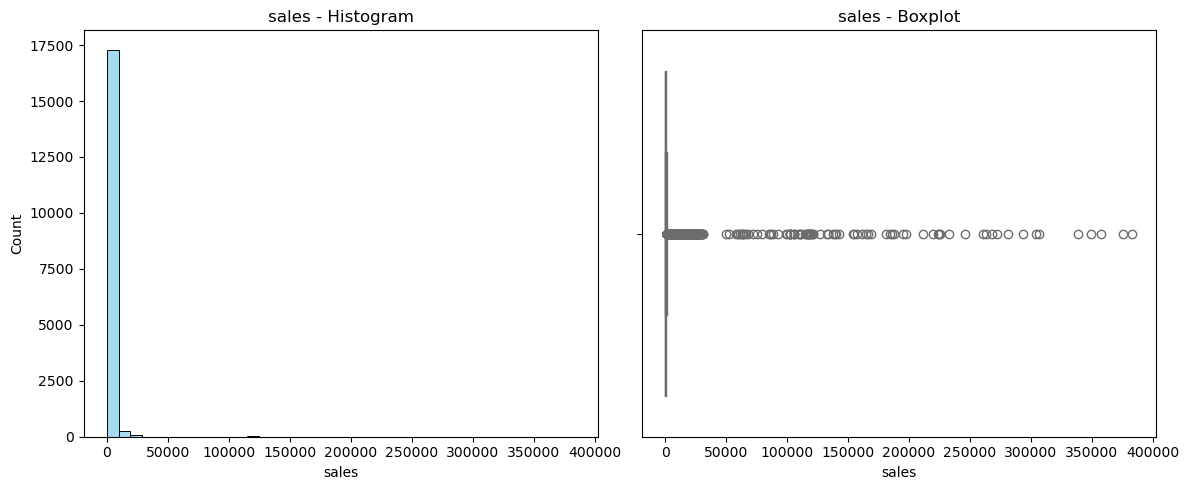

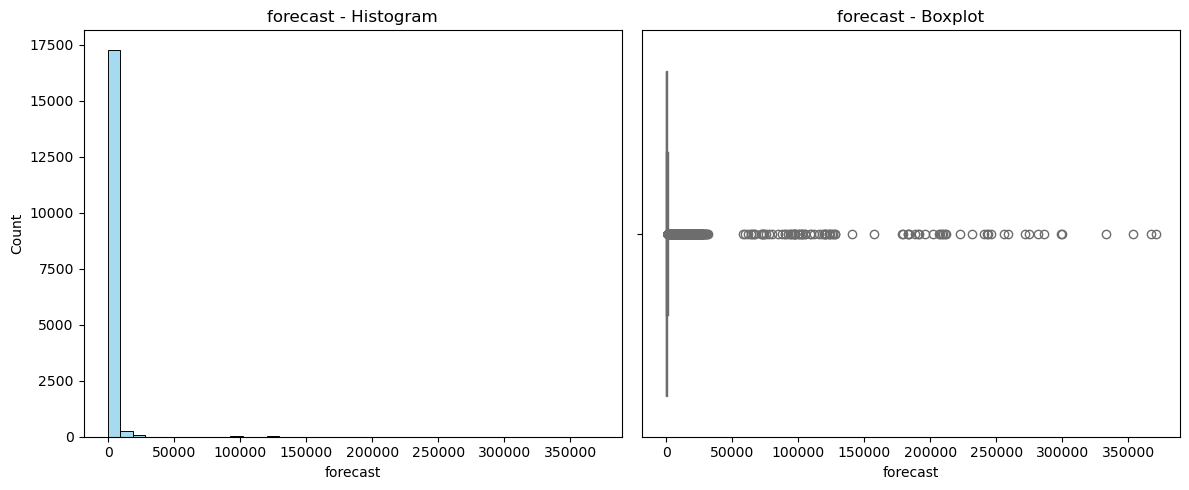

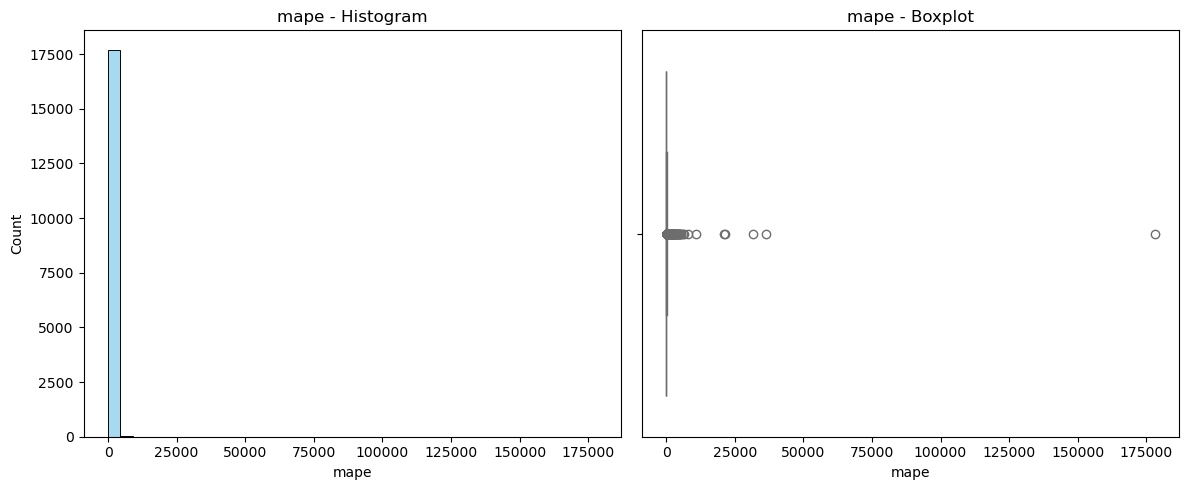

In [703]:
#Check distribution for numerical features
metrics = ['sales', 'forecast', 'mape']

for metric in metrics:
    plt.figure(figsize=(12, 5))
    
    # Histogram 
    plt.subplot(1, 2, 1)
    sns.histplot(df_all[metric], bins=40, color='skyblue')
    plt.title(f'{metric} - Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_all[metric], color='salmon')
    plt.title(f'{metric} - Boxplot')

    plt.tight_layout()
    plt.show()



/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4606/1395921375.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=country_counts, x='country', y='count', palette='viridis')


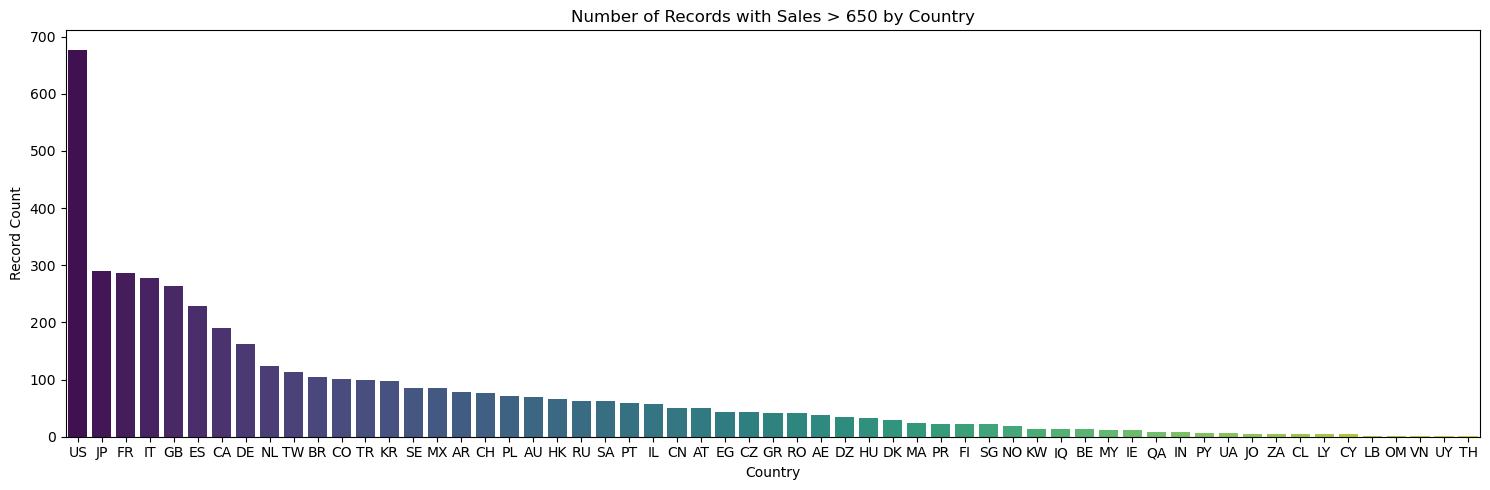

In [704]:
#High Sales by Country
# Filter rows where sales > 75th percentile
filtered_df = df_all[df_all['sales'] > 650]

# Group by country
country_counts = filtered_df['country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

# Plot
plt.figure(figsize=(15, 5))
sns.barplot(data=country_counts, x='country', y='count', palette='viridis')
plt.title('Number of Records with Sales > 650 by Country')
plt.xlabel('Country')
plt.ylabel('Record Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4606/1642206294.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=product_counts, x='product_family', y='count', palette='magma')


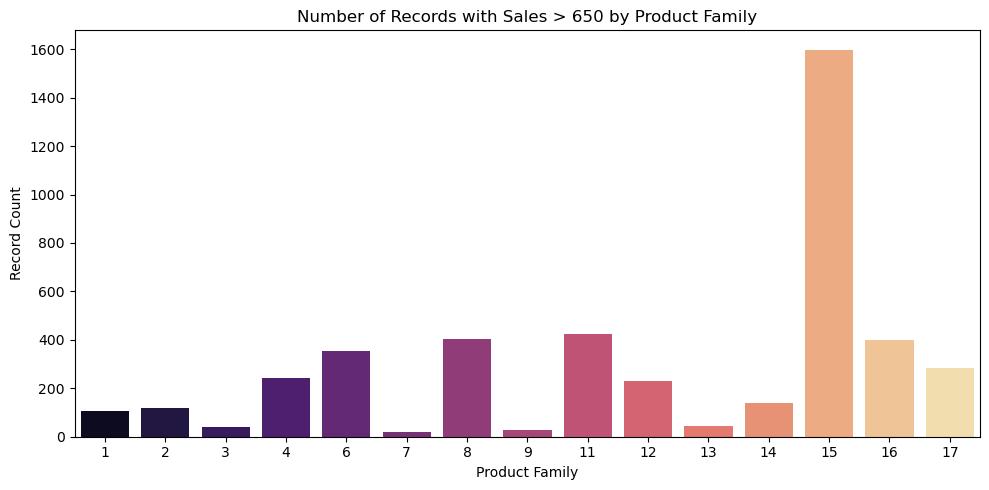

In [707]:
#High Sales by Product Family

# Group by product_family
product_counts = filtered_df['product_family'].value_counts().reset_index()
product_counts.columns = ['product_family', 'count']

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=product_counts, x='product_family', y='count', palette='magma')
plt.title('Number of Records with Sales > 650 by Product Family')
plt.xlabel('Product Family')
plt.ylabel('Record Count')
plt.tight_layout()
plt.show()


/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4606/914790075.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=country_mape_counts, x='country', y='count', palette='rocket')


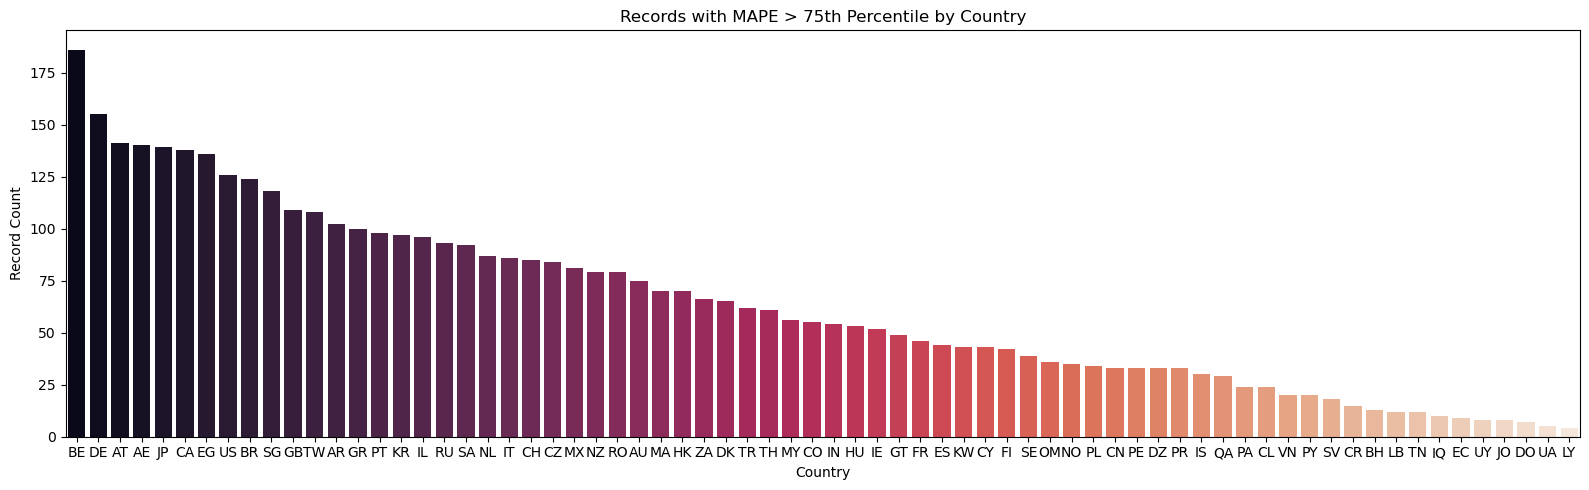

In [709]:
# Filter rows where MAPE > 75th percentile
high_mape_df = df_all[df_all['mape'] > 51.145]

# Count high MAPE records by country
country_mape_counts = high_mape_df['country'].value_counts().reset_index()
country_mape_counts.columns = ['country', 'count']

# Plot
plt.figure(figsize=(16, 5))
sns.barplot(data=country_mape_counts, x='country', y='count', palette='rocket')
plt.title('Records with MAPE > 75th Percentile by Country')
plt.xlabel('Country')
plt.ylabel('Record Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4606/292676926.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=country_mape_counts2, x='country', y='count', palette='rocket')


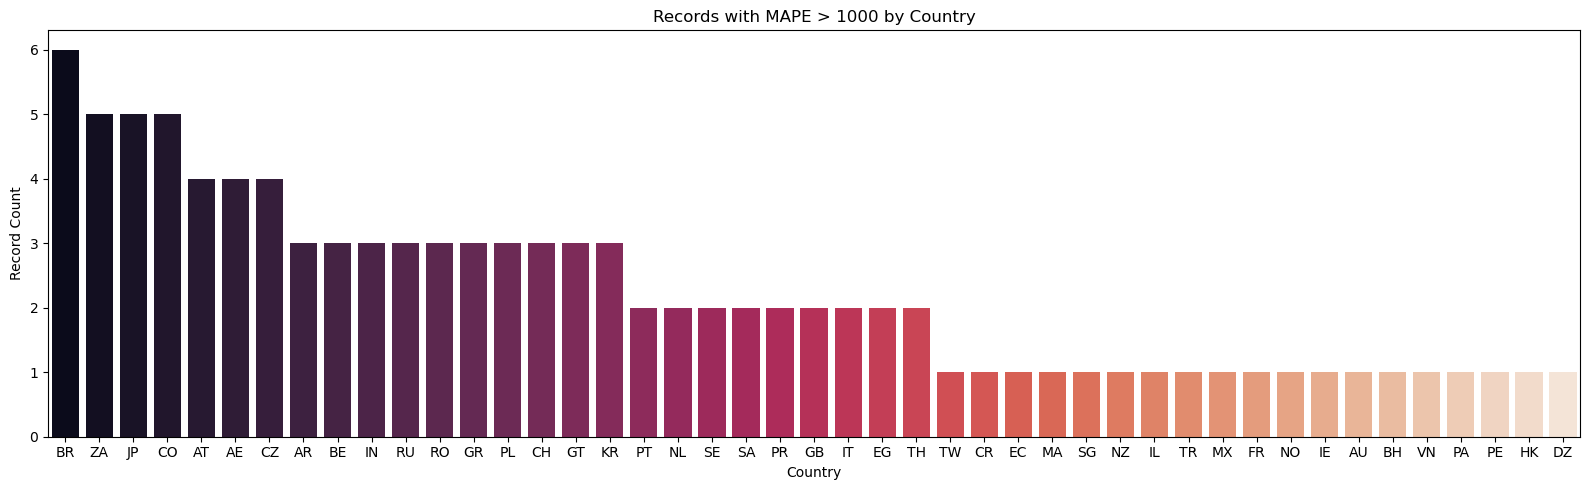

In [711]:
# Filter rows where MAPE > 1000%
high_mape_df2 = df_all[df_all['mape'] > 1000]

# Count high MAPE records by country
country_mape_counts2 = high_mape_df2['country'].value_counts().reset_index()
country_mape_counts2.columns = ['country', 'count']

# Plot
plt.figure(figsize=(16, 5))
sns.barplot(data=country_mape_counts2, x='country', y='count', palette='rocket')
plt.title('Records with MAPE > 1000 by Country')
plt.xlabel('Country')
plt.ylabel('Record Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4606/849339730.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_counts.index, y=country_counts.values, palette="viridis")


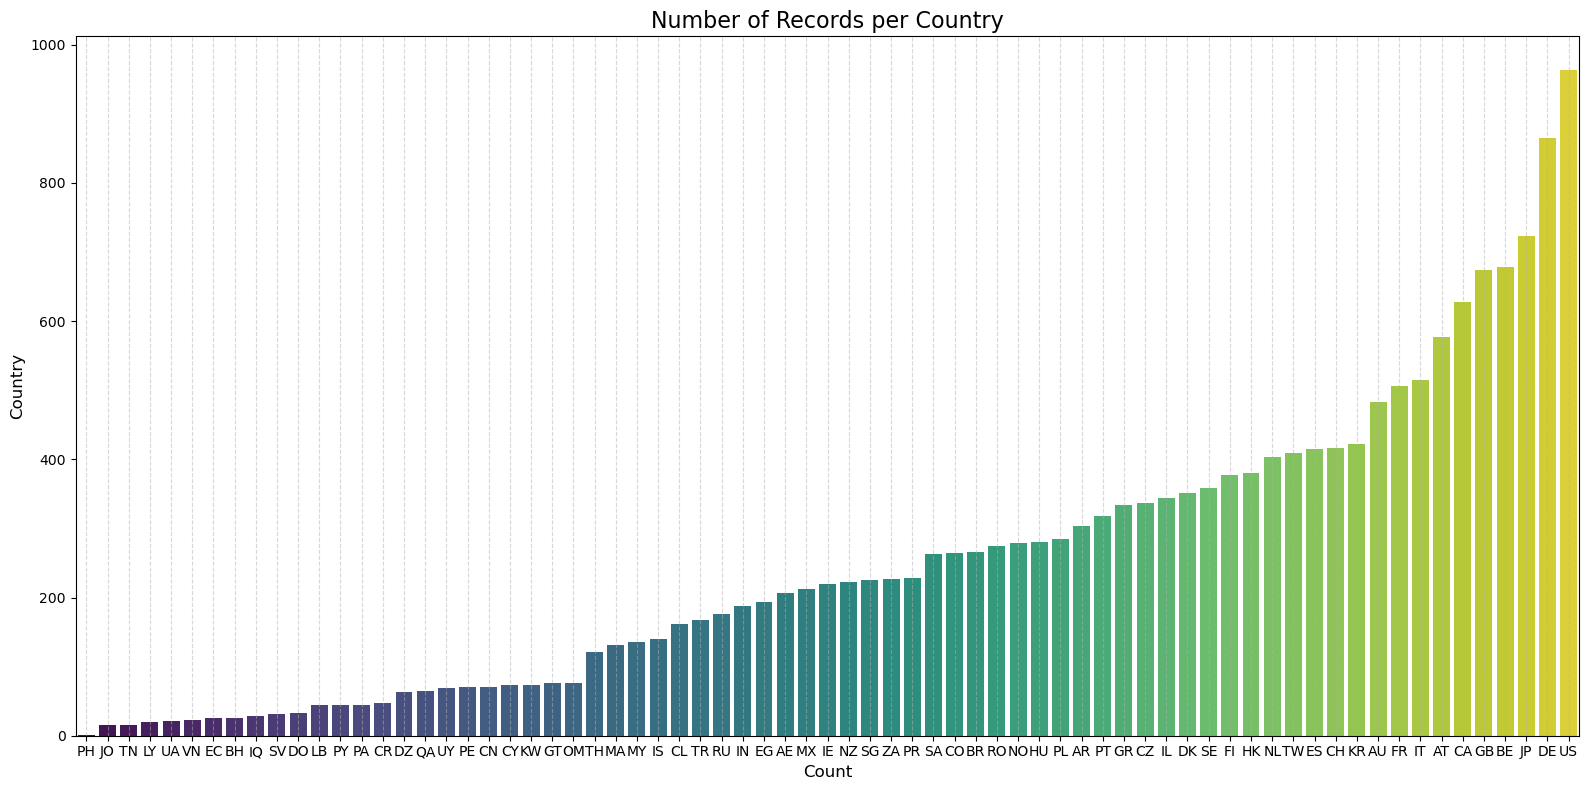

In [713]:
# Count the number of entries per country
country_counts = df_all['country'].value_counts().sort_values(ascending=True)

# Set the figure size for better spacing
plt.figure(figsize=(16, 8))  # Dynamically scale height

# Plot horizontal bar chart
sns.barplot(x=country_counts.index, y=country_counts.values, palette="viridis")

# Beautify the chart
plt.title("Number of Records per Country", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Bivariate Analysis

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4606/3316875510.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="month", y="sales", data=df_all, ci=None)


<Axes: xlabel='month', ylabel='sales'>

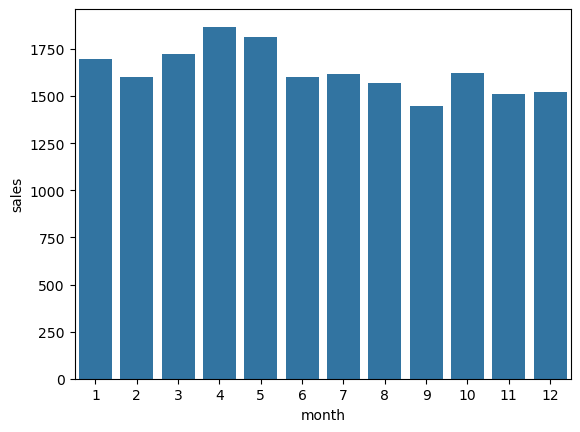

In [716]:
#mean (average) of sales for each month
sns.barplot(x="month", y="sales", data=df_all, ci=None)

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4606/1792484267.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_all.set_index('date').resample('M')['sales'].sum().plot(title='Monthly Sales Trend')


<Axes: title={'center': 'Monthly Sales Trend'}, xlabel='date'>

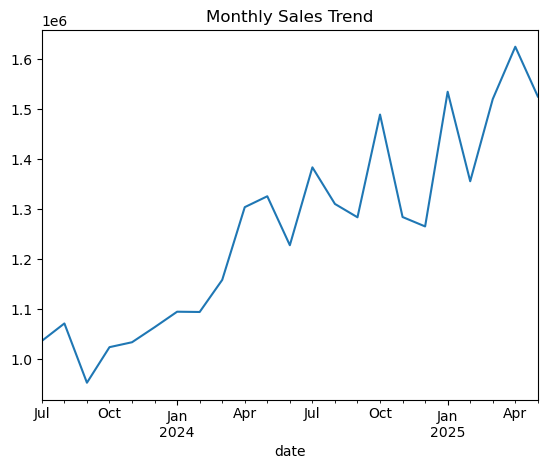

In [718]:
df_all.set_index('date').resample('M')['sales'].sum().plot(title='Monthly Sales Trend')


* Despite the upward trend, there are visible dips along the way, suggesting seasonal effects, market shifts, or temporary challenges.

Text(0.5, 1.0, 'Forecast vs. Sales')

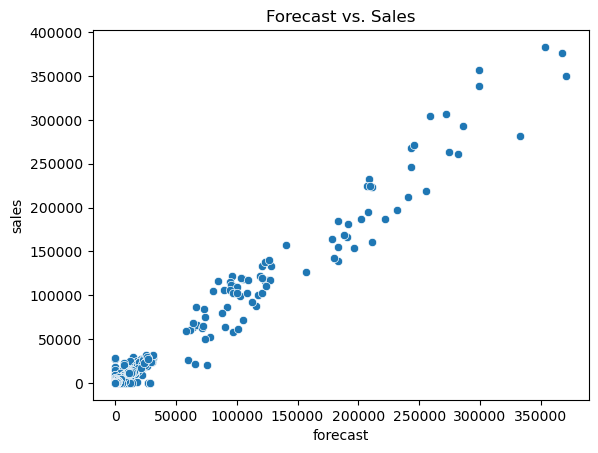

In [721]:
#Sales Vs Forecast
sns.scatterplot(x='forecast', y='sales', data=df_all)
plt.title('Forecast vs. Sales')


* Strong Positive Correlation: Sales values rise alongside forecast values. This tight clustering along a diagonal suggests a reliable prediction model—when forecasts go up, actual sales usually follow.

* Forecast Accuracy: The proximity of most data points to the diagonal implies high accuracy in predictions. Few outliers indicate minimal deviation between forecasted and actual results.

* Strategic Alignment: The consistent relationship means business strategies based on forecasts are likely well-aligned with market performance.

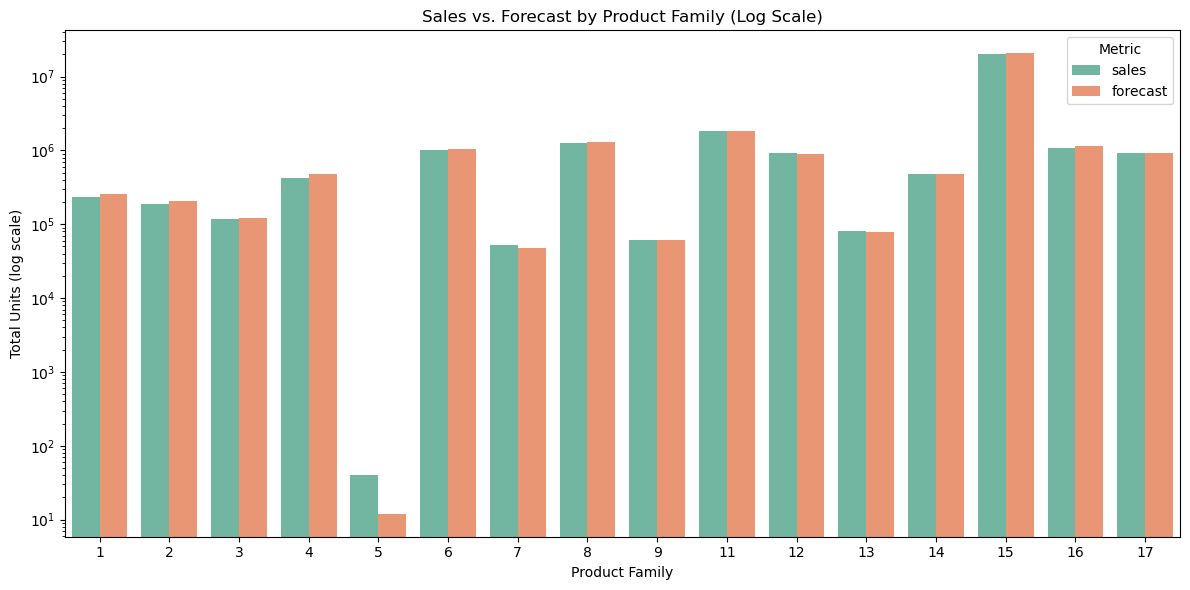

In [724]:
#sales vs. forecast side by side for each product family
# Group and sum sales & forecast by product family
sales_forecast_pf = df_all.groupby('product_family')[['sales', 'forecast']].sum().reset_index()
# Melt data to long format for grouped bars
melted_pf = sales_forecast_pf.melt(
    id_vars='product_family',
    value_vars=['sales', 'forecast'],
    var_name='type',
    value_name='value'
)



plt.figure(figsize=(12, 6))
ax = sns.barplot(data=melted_pf, x='product_family', y='value', hue='type', palette='Set2')

# Use logarithmic scale for y-axis
ax.set_yscale('log')




plt.title('Sales vs. Forecast by Product Family (Log Scale)')
plt.xlabel('Product Family')
plt.ylabel('Total Units (log scale)')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()



/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4606/3138713924.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=mape_by_pf, x='product_family', y='mape', palette='Blues_r')


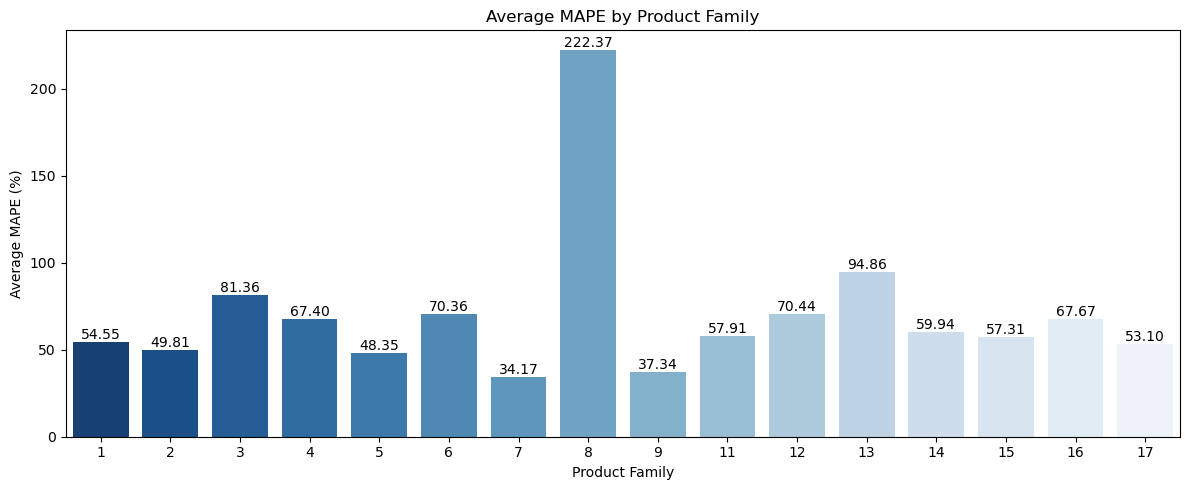

In [726]:
# Group and calculate average MAPE by product family
mape_by_pf = df_all.groupby('product_family')['mape'].mean().reset_index()

# Sort by MAPE if needed (optional)
mape_by_pf = mape_by_pf.sort_values(by='mape', ascending=False)

# Plot
plt.figure(figsize=(12, 5))
ax = sns.barplot(data=mape_by_pf, x='product_family', y='mape', palette='Blues_r')

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge')

plt.title('Average MAPE by Product Family')
plt.xlabel('Product Family')
plt.ylabel('Average MAPE (%)')
plt.tight_layout()
plt.show()



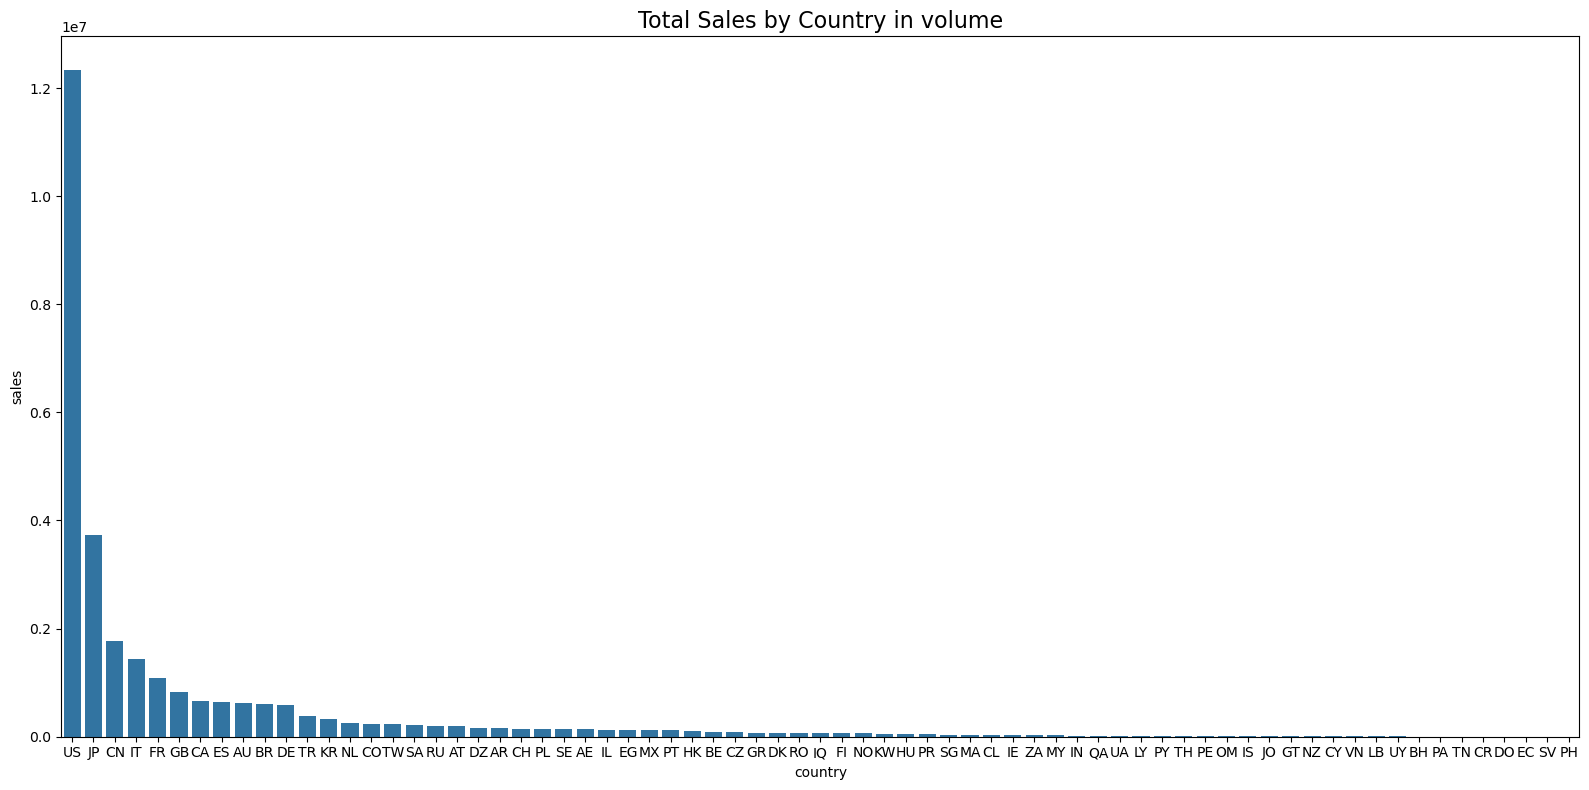

In [728]:
# Sum total sales per country
sales_by_country = df_all.groupby("country", as_index=False)["sales"].sum()
sales_by_country = sales_by_country.sort_values(by="sales", ascending=False)

# Plot total sales
plt.figure(figsize=(16, 8))
sns.barplot(x="country", y="sales", data=sales_by_country)
plt.title("Total Sales by Country in volume", fontsize=16)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


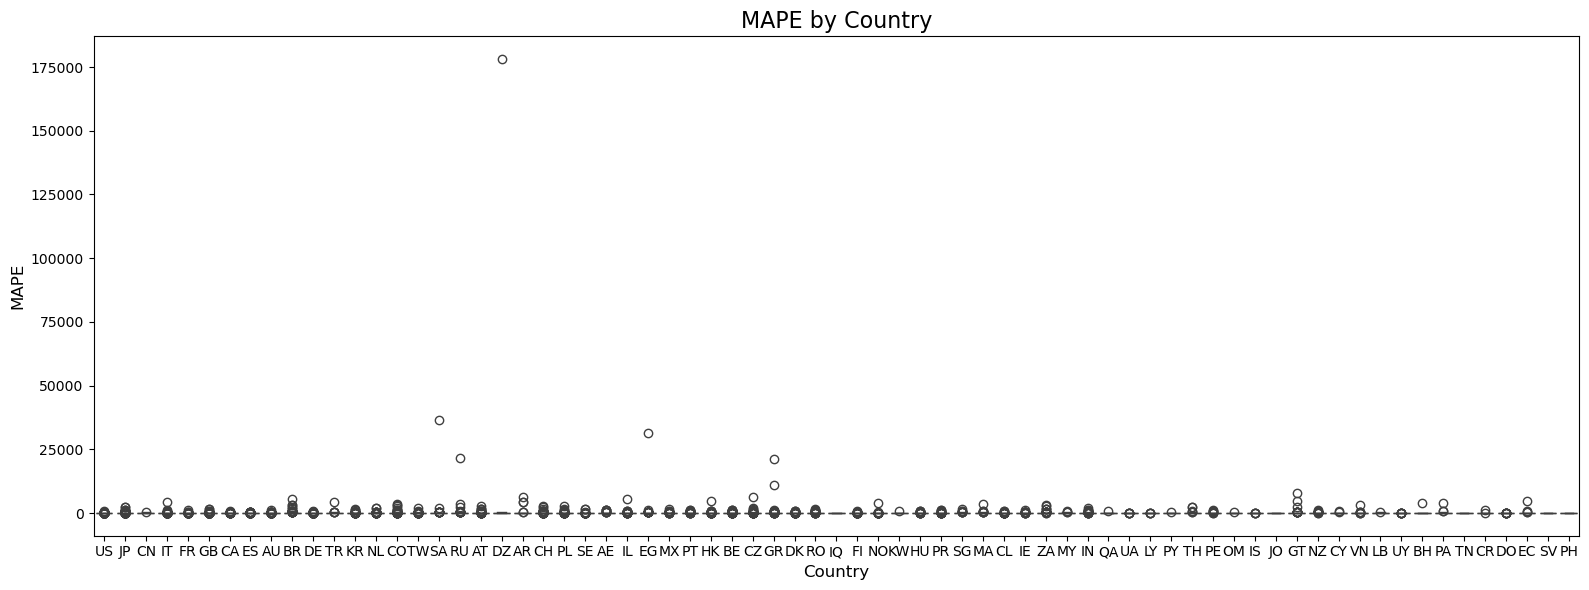

In [730]:
#mape across Countries

# First, extract the sorted country order based on total sales
country_order = sales_by_country['country']

# Now use that order in your MAPE boxplot
plt.figure(figsize=(16, 6))
sns.boxplot(x='country', y='mape', data=df_all, order=country_order)
plt.title("MAPE by Country", fontsize=16)
plt.xlabel("Country", fontsize=12)
plt.ylabel("MAPE", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


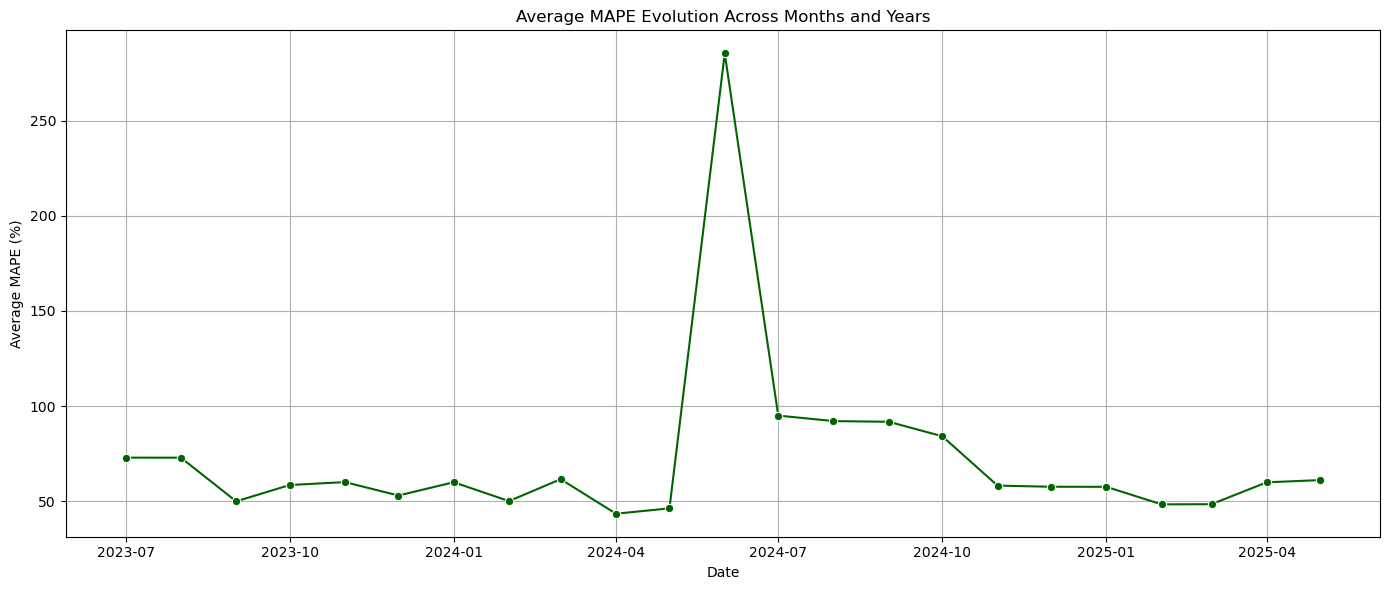

In [732]:
# Group by year and month to calculate average MAPE
mape_monthly_yearly = (
    df_all.groupby(['year', 'month'])['mape']
    .mean()
    .reset_index()
)

# Optional: create a datetime column for plotting
mape_monthly_yearly['date'] = pd.to_datetime(
    mape_monthly_yearly[['year', 'month']].assign(day=1)
)


plt.figure(figsize=(14, 6))
sns.lineplot(data=mape_monthly_yearly, x='date', y='mape', marker='o', color='darkgreen')

plt.title('Average MAPE Evolution Across Months and Years')
plt.xlabel('Date')
plt.ylabel('Average MAPE (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Diagnose the June 2024 Spike

In [735]:
spike_df = df_all[(df_all['year'] == 2024) & (df_all['month'] == 6)]
spike_summary = spike_df.groupby(['country', 'product_family'])['mape'].mean().reset_index().sort_values(by='mape', ascending=False)

spike_summary

country  product_family        mape
129      DZ               8  178150.000
241      IT              13    2261.455
188      GT               8    2249.400
136      EG              13    1076.470
132      EC              17     600.000
..      ...             ...         ...
386      TR              11       0.000
387      TR              15       0.000
92       CY               3       0.000
275      MA              11       0.000
98       CZ               7       0.000

[426 rows x 3 columns]

In [737]:
geo_mape = df_all.groupby(['geography', 'year', 'month'])['mape'].mean().reset_index()

geo_mape

geography  year  month       mape
0   Greater China  2023      7  90.121842
1   Greater China  2023      8  32.867222
2   Greater China  2023      9  41.278649
3   Greater China  2023     10  34.737368
4   Greater China  2023     11  27.195263
..            ...   ...    ...        ...
87  North America  2025      1  21.976463
88  North America  2025      2  31.008072
89  North America  2025      3  26.544000
90  North America  2025      4  26.443494
91  North America  2025      5  27.801220

[92 rows x 4 columns]

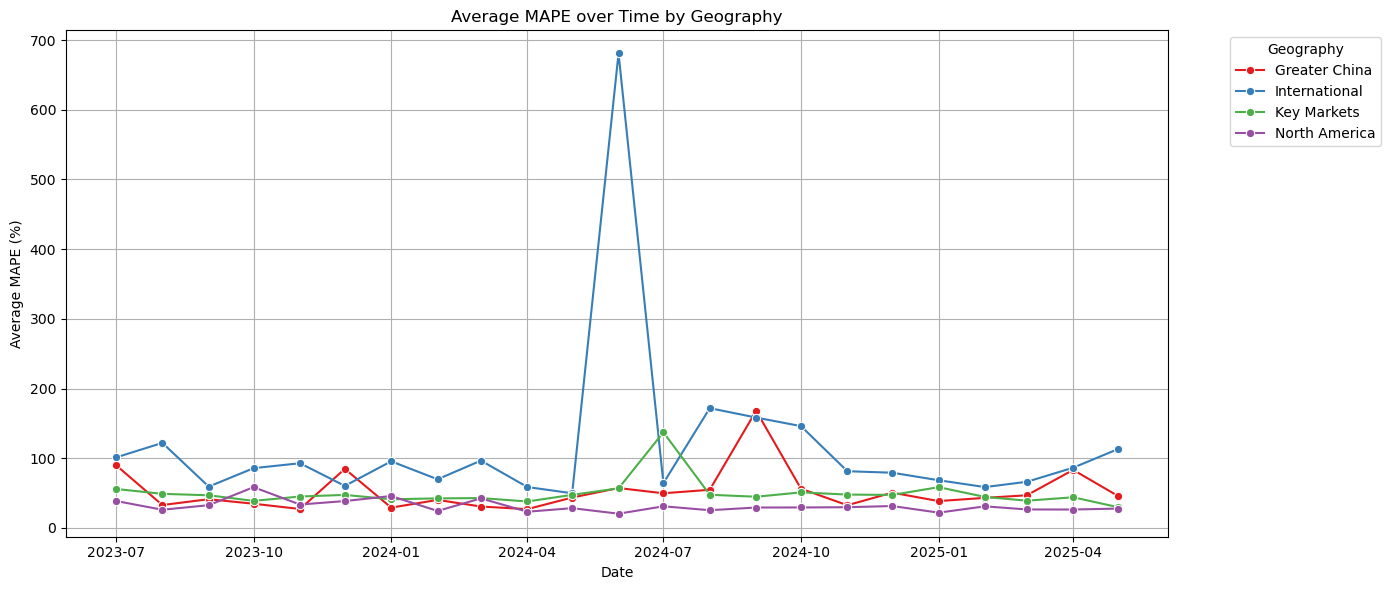

In [739]:
# Create a datetime column for proper x-axis formatting
geo_mape['date'] = pd.to_datetime(geo_mape[['year', 'month']].assign(day=1))

plt.figure(figsize=(14, 6))
sns.lineplot(data=geo_mape, x='date', y='mape', hue='geography', marker='o', palette='Set1')

plt.title('Average MAPE over Time by Geography')
plt.xlabel('Date')
plt.ylabel('Average MAPE (%)')
plt.legend(title='Geography', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [741]:
df_all[['mape', 'coverage_months', 'sales', 'absolute_error']].corr()


mape  coverage_months     sales  absolute_error
mape             1.000000        -0.005169 -0.005154        0.018513
coverage_months -0.005169         1.000000 -0.044754       -0.052242
sales           -0.005154        -0.044754  1.000000        0.703657
absolute_error   0.018513        -0.052242  0.703657        1.000000

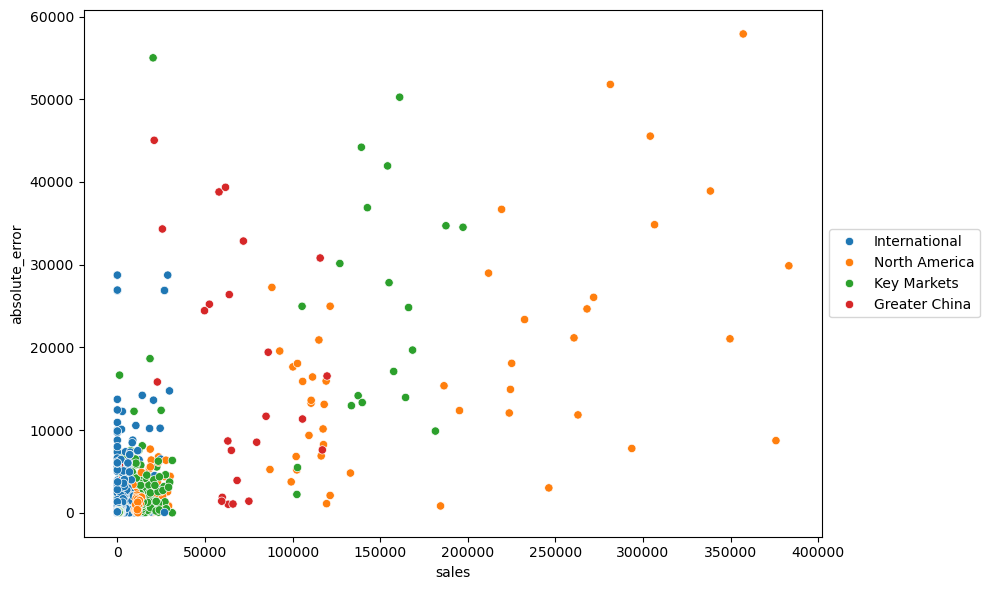

In [743]:
# Set a larger figure size
plt.figure(figsize=(10, 6))  # Adjust width and height as needed

# Create the scatterplot
sns.scatterplot(data=df_all, x='sales', y='absolute_error', hue='geography')

# Move the legend to the right
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Apply tight layout to prevent clipping
plt.tight_layout()

# Display the plot
plt.show()


Key Observations

Sales vs. Error Relationship 
* There's a weak positive trend—higher sales don’t necessarily correspond to lower absolute errors. 
* Some high-sales regions still show notable prediction errors.

Regional Patterns
* North America (orange) shows a wide spread in absolute error, indicating inconsistency in model performance.
* Greater China (red) tends to cluster toward lower sales and lower errors—potentially a more stable segment.
* International (blue) and Key Markets (green) span a wide range, but International seems to show less error at lower sales levels.

In [746]:
# Group by year and month to calculate average MAPE
monthly_mape = (
    df_all.groupby(['year', 'month'])['mape']
    .mean()
    .reset_index()
    .sort_values(by='mape', ascending=False)
)

# Display top months
top_mape_months = monthly_mape.head(10)
print(top_mape_months)


    year  month        mape
11  2024      6  285.479086
12  2024      7   94.973997
13  2024      8   92.077920
14  2024      9   91.715490
15  2024     10   84.113439
0   2023      7   72.862072
1   2023      8   72.823581
8   2024      3   61.528190
22  2025      5   61.045119
4   2023     11   59.984067


/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4606/1210487264.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_top, x='label', y='mape', palette='Reds_r')


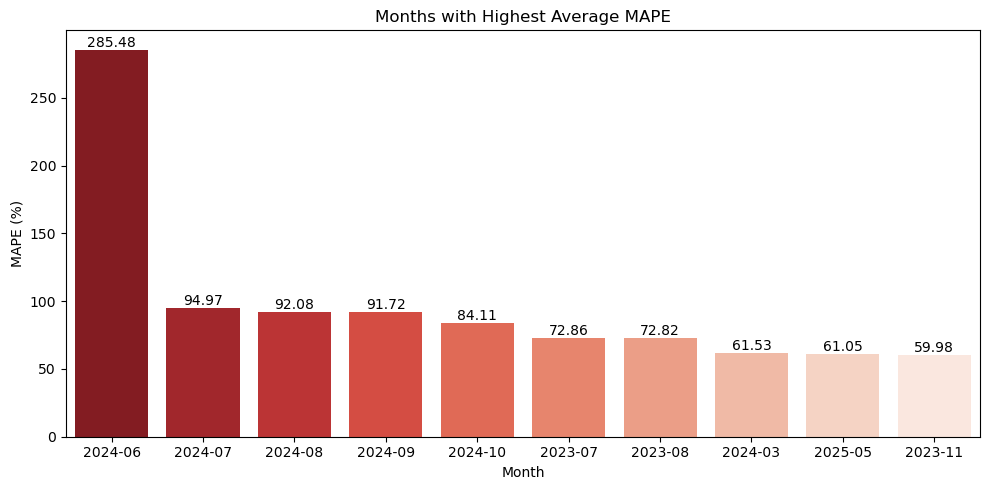

In [748]:
# Top 10 months by average MAPE
plt.figure(figsize=(10, 5))
monthly_top = top_mape_months.copy()
monthly_top['label'] = monthly_top['year'].astype(str) + '-' + monthly_top['month'].astype(str).str.zfill(2)

sns.barplot(data=monthly_top, x='label', y='mape', palette='Reds_r')
plt.title('Months with Highest Average MAPE')
plt.xlabel('Month')
plt.ylabel('MAPE (%)')
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.2f')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [750]:
# Group by country and calculate average MAPE
country_mape = (
    df_all.groupby('country')['mape']
    .mean()
    .reset_index()
    .sort_values(by='mape', ascending=False)
)

# Display top 5 countries
top_5_countries = country_mape.head(5)
print(top_5_countries)


   country         mape
18      DZ  2882.964127
26      GT   285.982895
19      EC   265.963600
69      VN   259.825652
20      EG   259.152526


/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4606/1946291472.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_5_countries, x='country', y='mape', palette='Oranges_r')


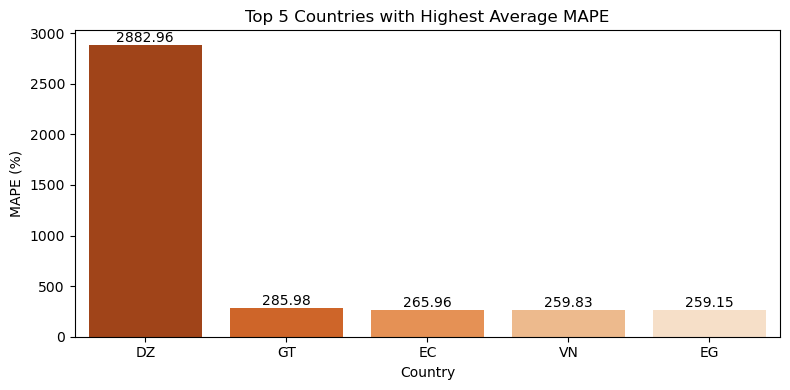

In [752]:
plt.figure(figsize=(8, 4))
sns.barplot(data=top_5_countries, x='country', y='mape', palette='Oranges_r')
plt.title('Top 5 Countries with Highest Average MAPE')
plt.xlabel('Country')
plt.ylabel('MAPE (%)')
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.2f')
plt.tight_layout()
plt.show()


In [754]:
# Group by product family and calculate MAPE standard deviation
pf_erratic = (
    df_all.groupby('product_family')['mape']
    .std()
    .reset_index()
    .rename(columns={'mape': 'mape_std'})
    .sort_values(by='mape_std', ascending=False)
)

# Display top erratic product families
top_erratic_pf = pf_erratic.head(10)
print(top_erratic_pf)


    product_family     mape_std
7                8  5129.588736
5                6  1091.563559
10              12   771.244945
13              15   392.178553
11              13   318.811152
14              16   312.200641
15              17   287.653657
12              14   271.606169
0                1   193.139316
9               11   182.451389


/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4606/852693064.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_erratic_pf, x='product_family', y='mape_std', palette='Purples')


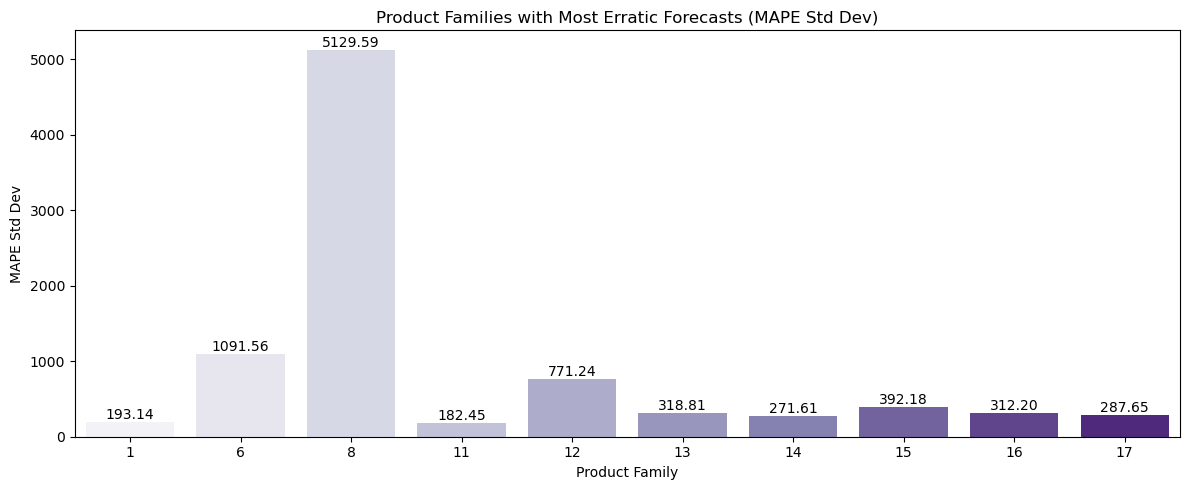

In [756]:
plt.figure(figsize=(12, 5))
sns.barplot(data=top_erratic_pf, x='product_family', y='mape_std', palette='Purples')
plt.title('Product Families with Most Erratic Forecasts (MAPE Std Dev)')
plt.xlabel('Product Family')
plt.ylabel('MAPE Std Dev')
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.2f')
plt.tight_layout()
plt.show()


/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4606/2813710565.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data, x='country', y='mape', palette='viridis')


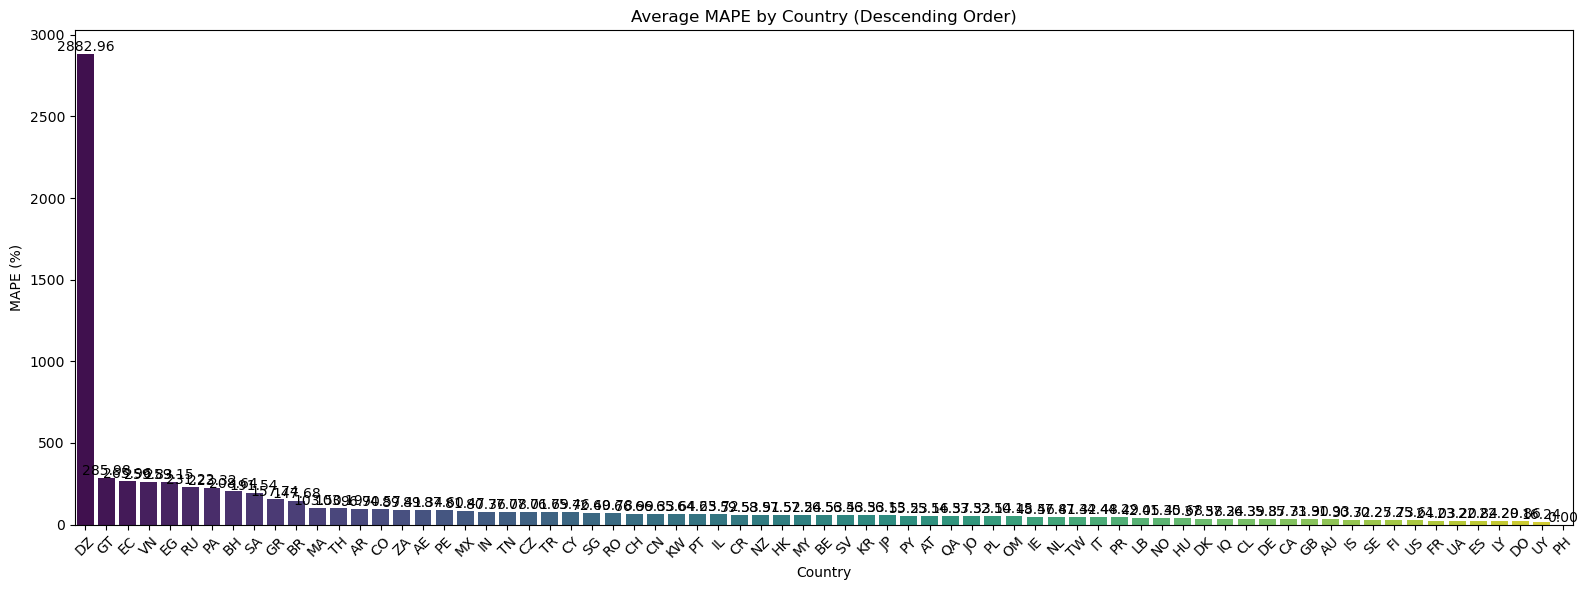

In [758]:
# Calculate average MAPE by country and sort descending
data = (
    df_all.groupby('country')['mape']
    .mean()
    .reset_index()
    .sort_values(by='mape', ascending=False)
)

# Plot bar chart
plt.figure(figsize=(16, 6))
ax = sns.barplot(data=data, x='country', y='mape', palette='viridis')

# Add value labels to bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge')

plt.title('Average MAPE by Country (Descending Order)')
plt.xlabel('Country')
plt.ylabel('MAPE (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



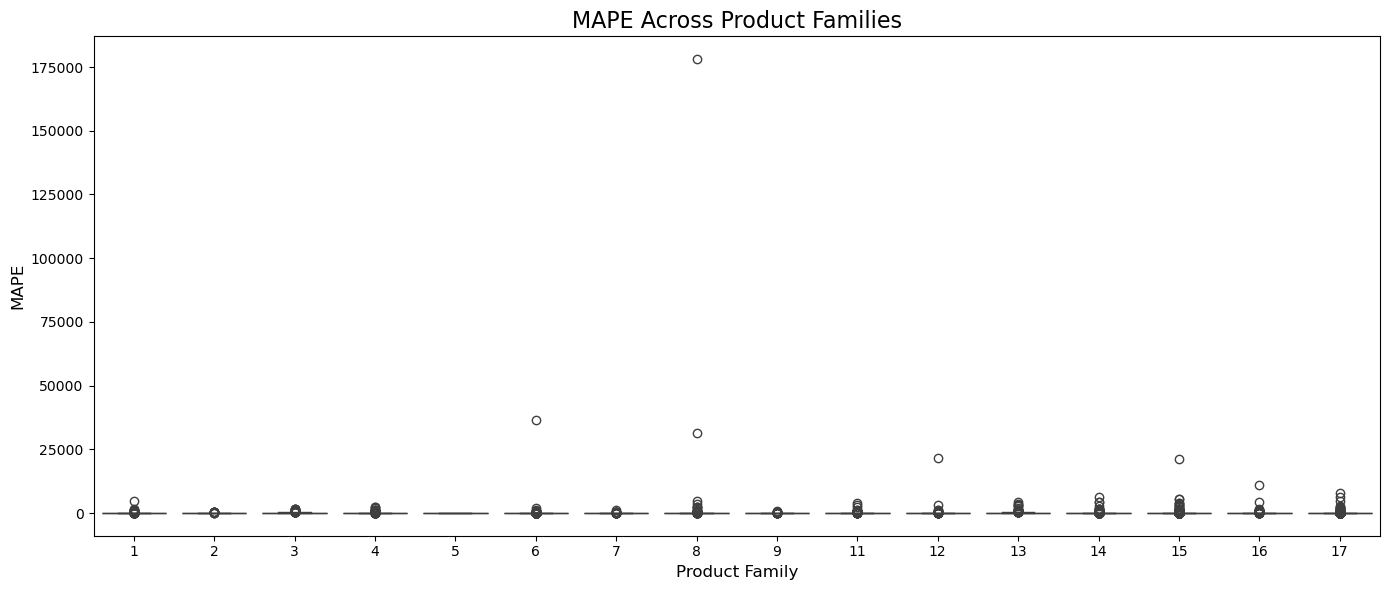

In [760]:
#mape across Product Families

plt.figure(figsize=(14, 6))  # You can adjust width and height as needed
sns.boxplot(x='product_family', y='mape', data=df_all)
plt.title("MAPE Across Product Families", fontsize=16)
plt.xlabel("Product Family", fontsize=12)
plt.ylabel("MAPE", fontsize=12)
plt.xticks(rotation=0)  # Rotating labels often helps with wider plots
plt.tight_layout()
plt.show()



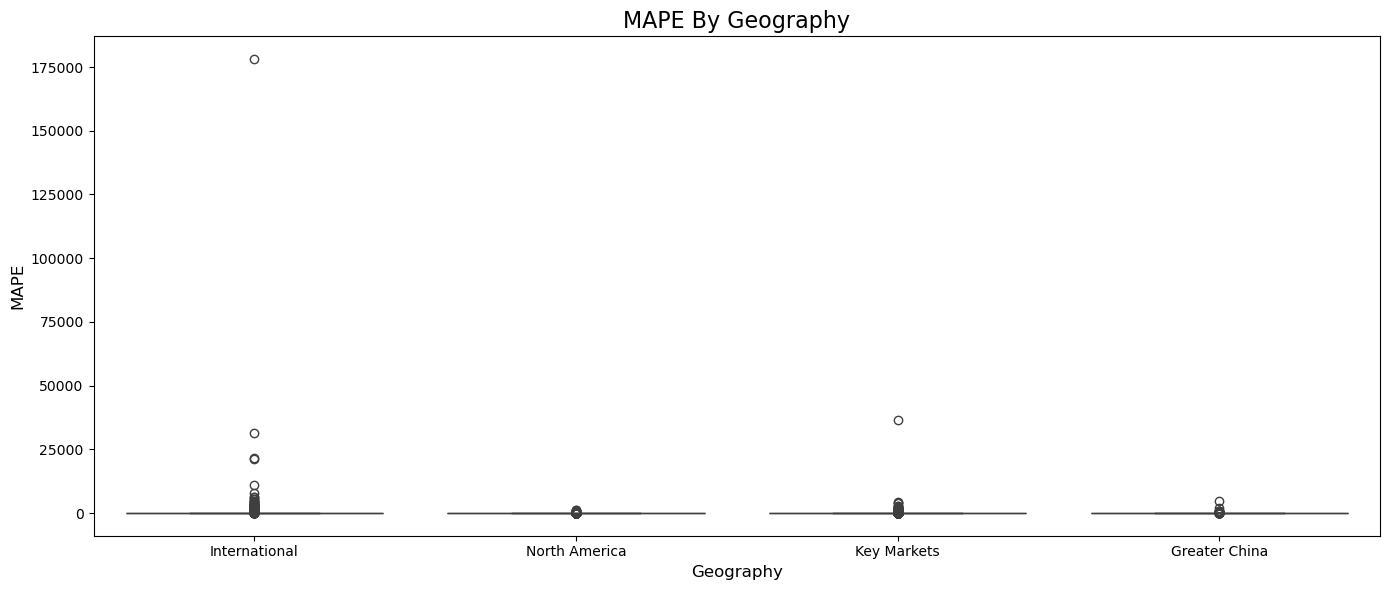

In [762]:
#mape by Geography

plt.figure(figsize=(14, 6))  # You can adjust width and height as needed
sns.boxplot(x='geography', y='mape', data=df_all)
plt.title("MAPE By Geography", fontsize=16)
plt.xlabel("Geography", fontsize=12)
plt.ylabel("MAPE", fontsize=12)
plt.xticks(rotation=0)  # Rotating labels often helps with wider plots
plt.tight_layout()
plt.show()

<Axes: >

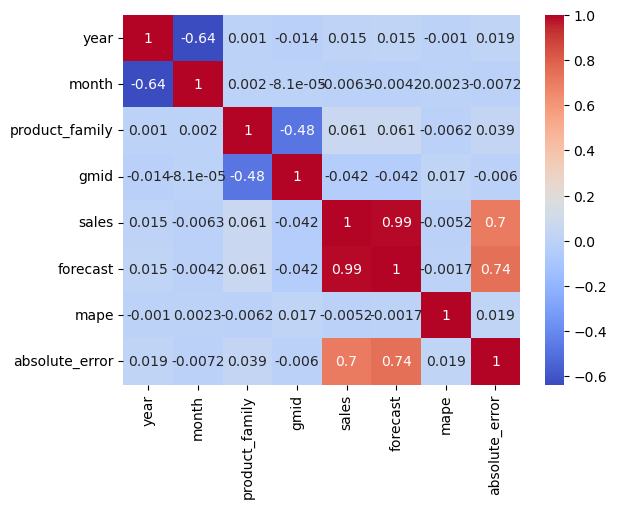

In [764]:
#Correlation Heatmap
correlation = df_all[['year','month','product_family','gmid','sales', 'forecast', 'mape', 'absolute_error']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')


In [766]:
def count_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((series < lower) | (series > upper)).sum()

# Columns to analyze
cols_to_check = ['sales', 'forecast', 'mape']
outlier_counts = {col: count_outliers_iqr(df_all[col].dropna()) for col in cols_to_check}

# Display
pd.Series(outlier_counts, name='Outlier Count')


sales       2208
forecast    2214
mape        1100
Name: Outlier Count, dtype: int64

* sales - around 12% - Moderate; could cap or transform.  
* forecast - around 12% - Similar to sales; likely due to erratic predictions.
* mape - around 6% - Many MAPE outliers reflect high error (often from small sales).

### Log transformation and segmentation

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4606/829418658.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='log_segment', data=df_active, palette='summer')


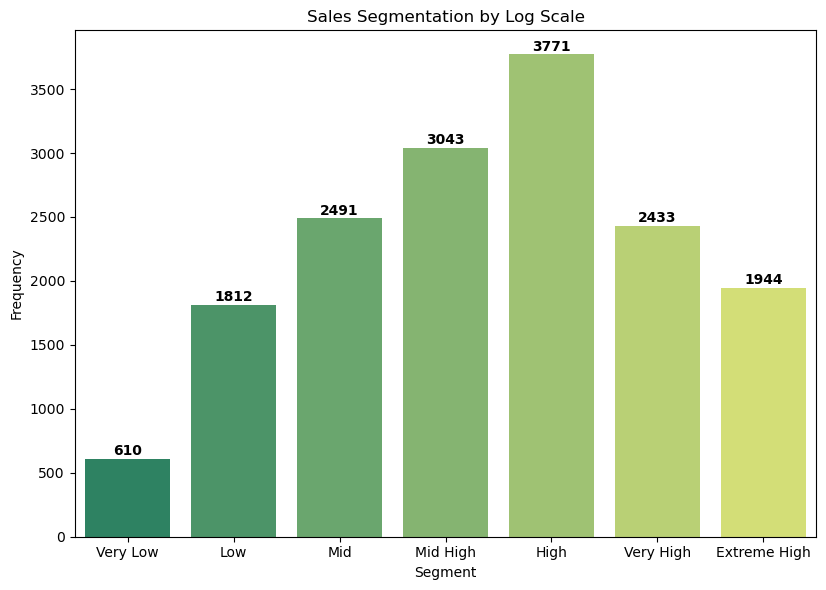

In [770]:
#consider only sales >0

df_active = df_all[df_all['sales'] > 0].copy()


# Log transformation and segmentation
df_active['log_sales'] = np.log1p(df_active['sales']) 
df_active['log_segment'] = pd.cut(df_active['log_sales'], 
                                bins=[-np.inf, 1.8, 3.2, 4.2, 5.2, 6.5, 7.5, np.inf],
                                labels=[
                                    'Very Low',     # ~0–6 sales
                                    'Low',          # ~6–23
                                    'Mid',           # ~23–66
                                    'Mid High',      # ~66–178
                                    'High',          # ~179–665
                                    'Very High',     # ~666–1800
                                    'Extreme High'   # >1800
                                ])

# Plotting both segmentation strategies side-by-side

plt.figure(figsize=(16, 6))

# Create the countplot
plt.subplot(1, 2, 2)
ax = sns.countplot(x='log_segment', data=df_active, palette='summer')

# Title and labels
plt.title('Sales Segmentation by Log Scale')
plt.xlabel('Segment')
plt.ylabel('Frequency')

# Add value labels on top of each bar
for bar in ax.patches:
    count = int(bar.get_height())
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    ax.text(x, y + 5, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


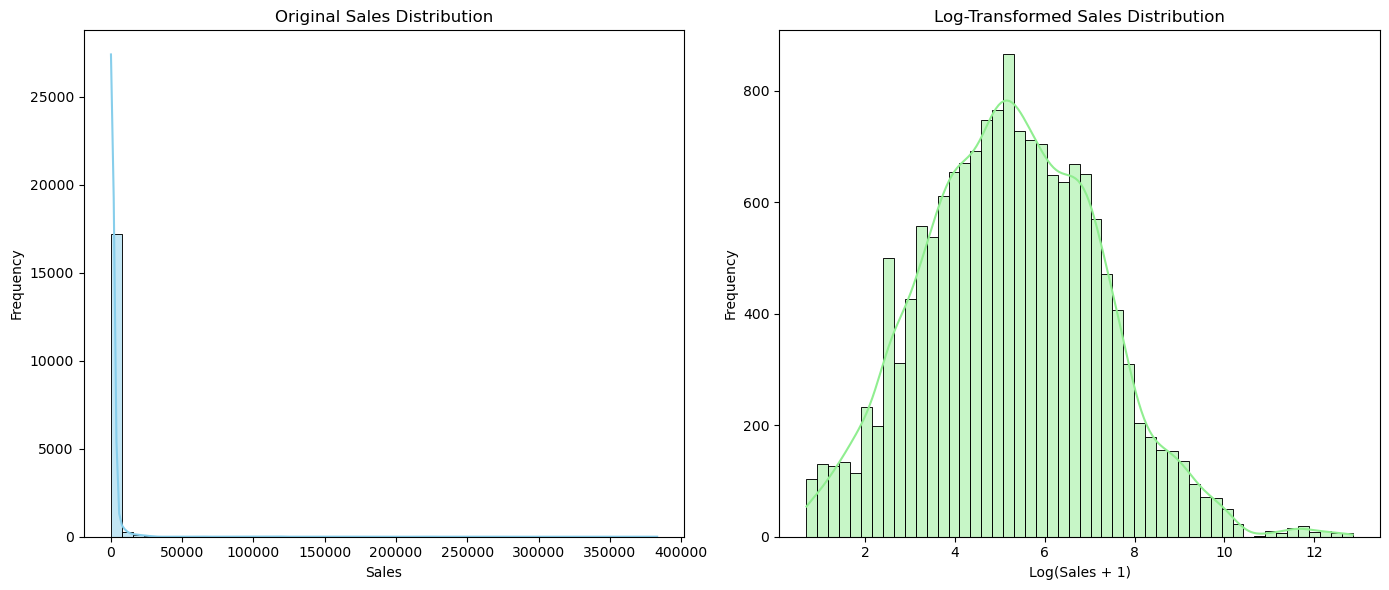

In [772]:
# Plot original vs log-transformed sales
plt.figure(figsize=(14, 6))

# Original sales distribution
plt.subplot(1, 2, 1)
sns.histplot(df_all['sales'], bins=50, kde=True, color='skyblue')
plt.title('Original Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')

# Log-transformed sales distribution
plt.subplot(1, 2, 2)
sns.histplot(df_active['log_sales'], bins=50, kde=True, color='lightgreen')
plt.title('Log-Transformed Sales Distribution')
plt.xlabel('Log(Sales + 1)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4606/2754686522.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mape_by_segment = df_active.groupby('log_segment')['mape'].mean().reindex(segment_order)
/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4606/2754686522.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_active, x='log_segment', order=segment_order, palette='viridis')


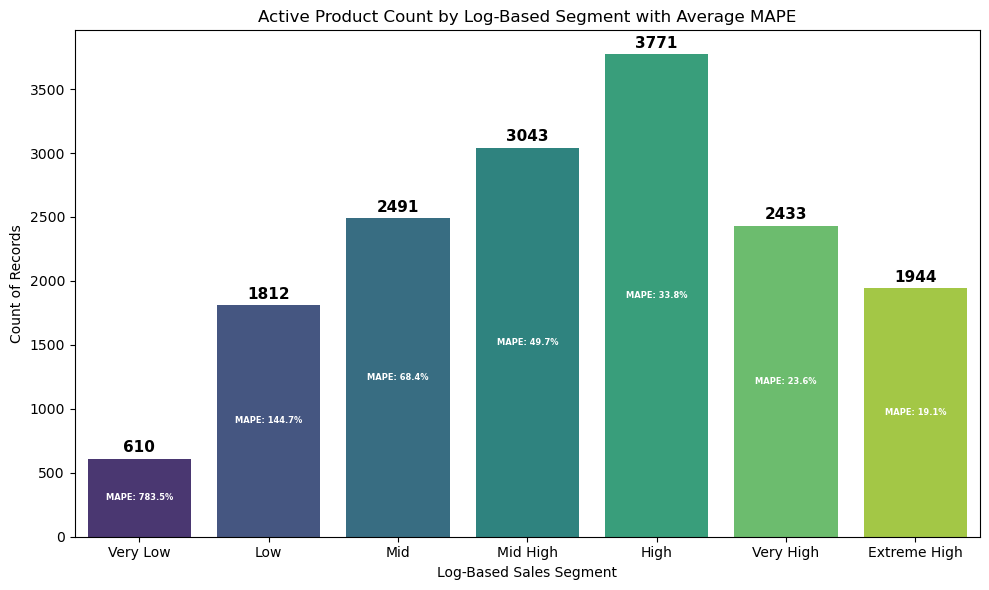

In [774]:

# Ensure 'log_segment' exists and is correctly ordered
segment_order = ['Very Low', 'Low', 'Mid', 'Mid High', 'High', 'Very High', 'Extreme High']

# Calculate average MAPE by log segment (using df_active)
mape_by_segment = df_active.groupby('log_segment')['mape'].mean().reindex(segment_order)

# Create the plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_active, x='log_segment', order=segment_order, palette='viridis')

# Annotate each bar with count and MAPE
for p, segment_name in zip(ax.patches, segment_order):
    height = p.get_height()
    xpos = p.get_x() + p.get_width() / 2.

    # Add count label above the bar
    ax.text(xpos, height + 50, f'{int(height)}', ha='center', fontsize=11, fontweight='bold')

    # Add MAPE label inside the bar
    mape_val = mape_by_segment.get(segment_name, np.nan)
    ax.text(xpos, height / 2, f'MAPE: {mape_val:.1f}%', ha='center', va='center',
            fontsize=6, color='white', fontweight='bold')

# Formatting
plt.title("Active Product Count by Log-Based Segment with Average MAPE")
plt.xlabel("Log-Based Sales Segment")
plt.ylabel("Count of Records")
plt.tight_layout()
plt.show()



* High volume products have the lowest average MAPE —  forecasts are relatively more accurate.
* Low volume products have a higher MAPE — forecasts are less accurate.


**** train separate models or tune differently for each segment

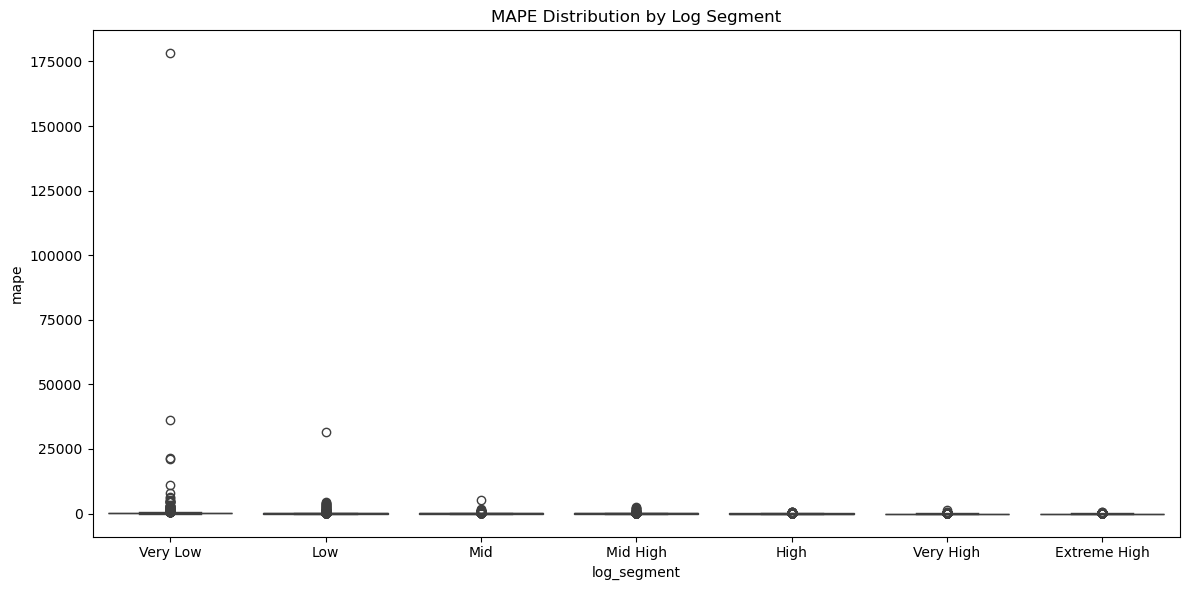

In [778]:

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_active, x='log_segment', y='mape')
plt.title('MAPE Distribution by Log Segment')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4606/4150017118.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_active, x='pf_segmentation', y='mape', palette='Set3')


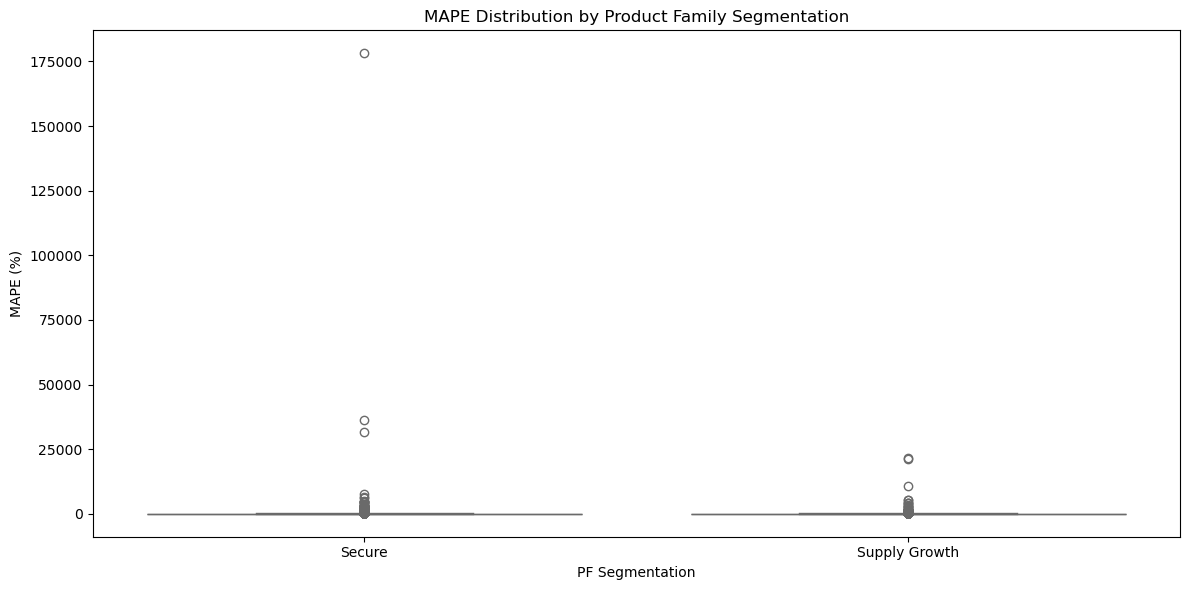

In [780]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_active, x='pf_segmentation', y='mape', palette='Set3')
plt.title('MAPE Distribution by Product Family Segmentation')
plt.xlabel('PF Segmentation')
plt.ylabel('MAPE (%)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4606/759368735.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_active, x='market_segmentation', y='mape', palette='Pastel1')


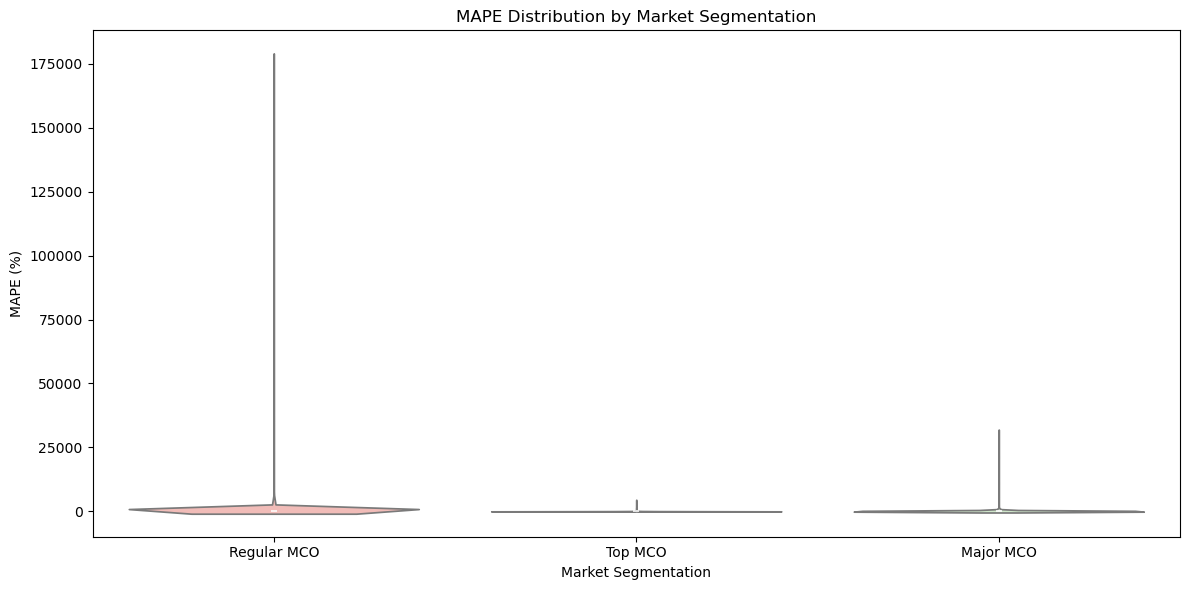

In [782]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_active, x='market_segmentation', y='mape', palette='Pastel1')
plt.title('MAPE Distribution by Market Segmentation')
plt.xlabel('Market Segmentation')
plt.ylabel('MAPE (%)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Distribution Patterns
Regular MCO:

Extremely wide MAPE spread, reaching up to 175,000%, which suggests high variability in model performance.

Presence of significant outliers—these could be caused by inconsistent data quality, poor forecasting accuracy, or unique market behaviors.

Top MCO & Major MCO:

Both show tighter distributions and much lower MAPE values, indicating more reliable and stable forecasting performance.

In [785]:
# Encode segmentation columns
encoded_df = df_active.copy()
segmentation_cols = ['market_segmentation', 'pf_segmentation', 'gmid_segmentation', 'log_segment']
encoded_df[segmentation_cols] = encoded_df[segmentation_cols].astype('category').apply(lambda x: x.cat.codes)

correlation_matrix = encoded_df[['mape'] + segmentation_cols].corr()
correlation_matrix['mape']

mape                   1.000000
market_segmentation   -0.022587
pf_segmentation       -0.006669
gmid_segmentation     -0.006499
log_segment           -0.058101
Name: mape, dtype: float64

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4606/3238903823.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_active.groupby(['market_segmentation','log_segment'])['mape']


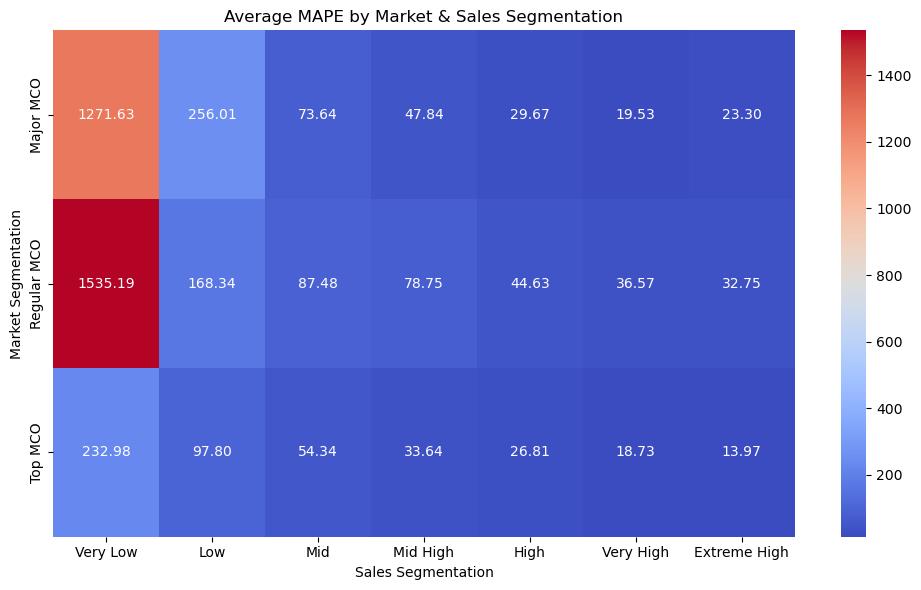

In [787]:
heatmap_df = (
    df_active.groupby(['market_segmentation','log_segment'])['mape']
    .mean()
    .unstack()
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Average MAPE by Market & Sales Segmentation')
plt.xlabel('Sales Segmentation')
plt.ylabel('Market Segmentation')
plt.tight_layout()
plt.show()

Major MCO	- Sharp drop-off in MAPE from Micro (1962.50%) to Extreme High (23.30%)

Suggests better model accuracy for higher volume segments

Lower tiers likely suffer from volatile data or sparse training samples | | Regular MCO | - Volatile Low (1699.51%) and Micro (809.76%) segments show severe model errors

Moderate improvement across tiers, but MAPE stays relatively elevated

Indicates room for tuning, especially for mid-range volumes | | Top MCO | - Most consistent performance

Extreme High segment shows lowest MAPE (13.97%)

Micro and Volatile Low still challenge model accuracy, albeit less severely than others

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4606/410807241.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_active.groupby(['product_family','log_segment'])['mape']


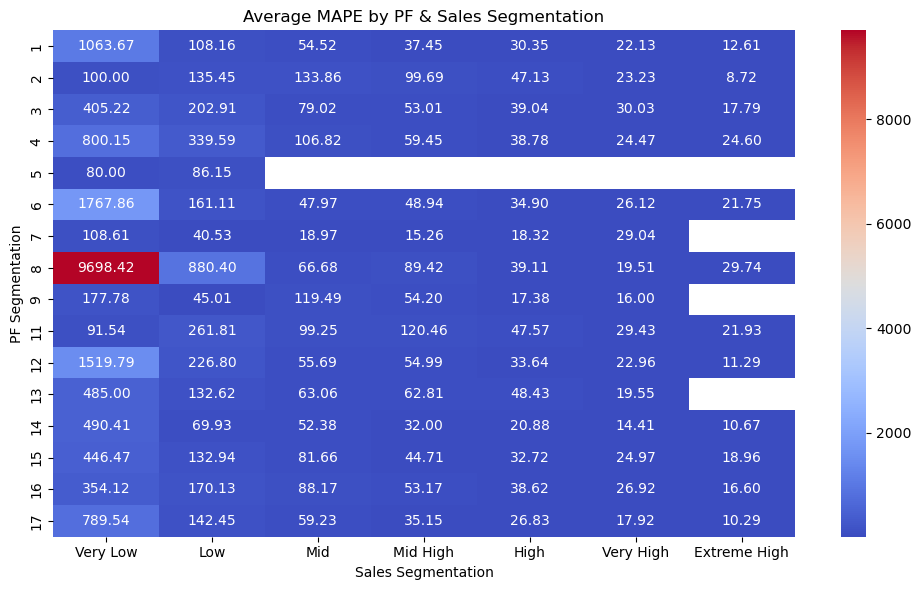

In [790]:
heatmap_df = (
    df_active.groupby(['product_family','log_segment'])['mape']
    .mean()
    .unstack()
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Average MAPE by PF & Sales Segmentation')
plt.xlabel('Sales Segmentation')
plt.ylabel('PF Segmentation')
plt.tight_layout()
plt.show()


PF Segment ID	Critical Highlights
8	🔴 Extreme outlier: Very Low segment has a MAPE of 10,231.67%—this is likely a result of massive errors or data irregularities.
4 & 15	🚨 High errors in Micro and Volatile Low segments (e.g. PF 4 Micro = 2300%, PF 15 Micro = 2271.43%)—worth auditing for noise, missing data, or feature gaps.
1, 2, 3	📉 Steady improvement from low to high sales tiers—MAPE drops significantly as volume increases. Indicative of better model calibration on higher data density.
Top PF performers	PF Segments like 1, 2, and 3 show MAPE < 20% in Extreme High tiers—evidence of strong reliability in high-volume segments.

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4606/3197969833.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_active.groupby(['pf_segmentation', 'market_segmentation','log_segment'])['mape']


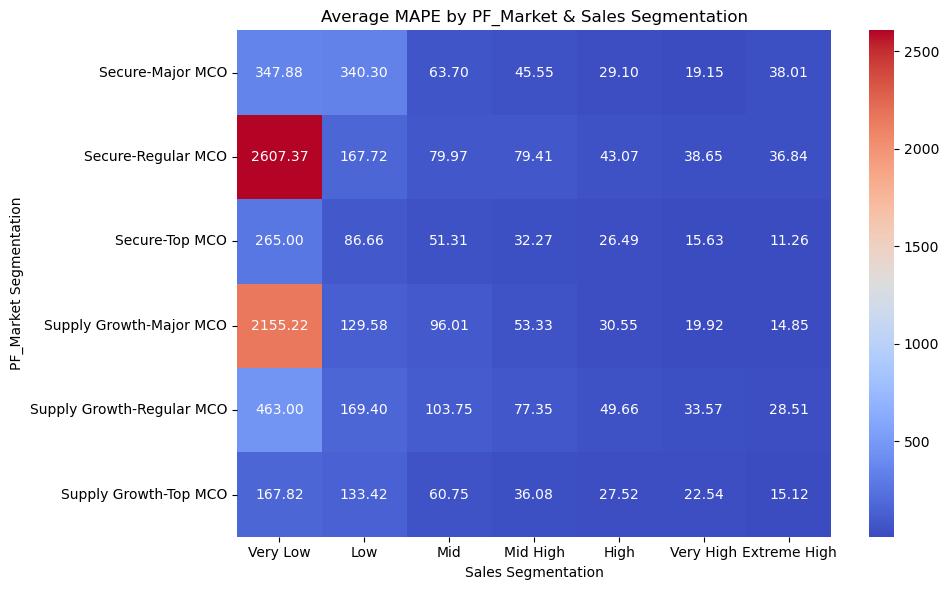

In [793]:
heatmap_df = (
    df_active.groupby(['pf_segmentation', 'market_segmentation','log_segment'])['mape']
    .mean()
    .unstack()
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Average MAPE by PF_Market & Sales Segmentation')
plt.xlabel('Sales Segmentation')
plt.ylabel('PF_Market Segmentation')
plt.tight_layout()
plt.show()



Market Type	Notable Observations
Secure-Regular MCO	Highest overall MAPE values—especially for "Volatile Low" (2970.66%) and "Micro" (1217.39%). Indicates severe prediction errors in less predictable sales segments.
Supply Growth-Major MCO	"Micro" segment shows an extremely high MAPE (2583.33%), suggesting high uncertainty or model failure at granular levels.
Secure-Top & Major MCO	Much lower MAPE values across segments, implying stronger performance and more stable forecasting.
Supply Growth-Regular MCO	Moderately high MAPE in lower sales brackets, but tapering off in higher ones. Shows some robustness.

Strategic Takeaways
Micro & Volatile Low segments consistently show higher MAPE across all markets, signaling potential data volatility or model misalignment.

Higher sales tiers (Very High, Extreme High) often yield lower MAPE, suggesting that performance improves with volume.

Top MCOs perform best overall—perhaps due to better data, investment, or more refined modeling approaches.

In [796]:
#Combine segmentation columns into hybrid features
df_active['seg_combo'] = df_all['pf_segmentation'] + '_' + df_all['market_segmentation']


In [798]:
# Create lag features
df_active = df_active.sort_values(by=['gmid', 'year', 'month'])
df_active['sales_lag_3'] = df_active.groupby('gmid')['sales'].shift(3)
df_active['forecast_lag_3'] = df_active.groupby('gmid')['forecast'].shift(3)

df_active['sales_lag_3'] = df_active['sales_lag_3'].fillna(0)
df_active['forecast_lag_3'] = df_active['forecast_lag_3'].fillna(0)


In [800]:
df_active.head()

gmid_key       date  year  month  product_family    gmid country  \
6   100001_20237_AU 2023-07-01  2023      7               1  100001      AU   
7   100001_20237_NZ 2023-07-01  2023      7               1  100001      NZ   
8   100001_20238_AU 2023-08-01  2023      8               1  100001      AU   
9   100001_20238_NZ 2023-08-01  2023      8               1  100001      NZ   
10  100001_20239_AU 2023-09-01  2023      9               1  100001      AU   

         market      geography  sales  ...   min   max  market_segmentation  \
6     Australia  International     75  ...  2.73  5.45          Regular MCO   
7   New Zealand  International     29  ...  2.73  4.09          Regular MCO   
8     Australia  International     66  ...  2.73  5.45          Regular MCO   
9   New Zealand  International     26  ...  2.73  4.09          Regular MCO   
10    Australia  International     48  ...  2.73  5.45          Regular MCO   

    pf_segmentation  gmid_segmentation  log_sales log_segment  \
6            Secure       Auto Piloted   4.330733    Mid High   
7            Secure       Auto Piloted   3.401197         Mid   
8            Secure       Auto Piloted   4.204693    Mid High   
9            Secure       Auto Piloted   3.295837         Mid   
10           Secure       Auto Piloted   3.891820         Mid   

             seg_combo sales_lag_3  forecast_lag_3  
6   Secure_Regular MCO         0.0             0.0  
7   Secure_Regular MCO         0.0             0.0  
8   Secure_Regular MCO         0.0             0.0  
9   Secure_Regular MCO        75.0           102.0  
10  Secure_Regular MCO        29.0            36.0  

[5 rows x 24 columns]

In [802]:
df_active.to_csv('file_before_ml.csv', index=False)

# Machine Learning

### Train Test Split

In [806]:
features = ['sales_lag_3', 'forecast_lag_3', 'log_sales', 'pf_segmentation', 'market_segmentation']
X = pd.get_dummies(df_active[features])
y = df_active['sales']  # or forecast


In [808]:
X.head()

sales_lag_3  forecast_lag_3  log_sales  pf_segmentation_Secure  \
6           0.0             0.0   4.330733                    True   
7           0.0             0.0   3.401197                    True   
8           0.0             0.0   4.204693                    True   
9          75.0           102.0   3.295837                    True   
10         29.0            36.0   3.891820                    True   

    pf_segmentation_Supply Growth  market_segmentation_Major MCO  \
6                           False                          False   
7                           False                          False   
8                           False                          False   
9                           False                          False   
10                          False                          False   

    market_segmentation_Regular MCO  market_segmentation_Top MCO  
6                              True                        False  
7                              True                        False  
8                              True                        False  
9                              True                        False  
10                             True                        False

In [810]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

### Scalling

In [813]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

In [815]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [817]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_train_scaled.head()

sales_lag_3  forecast_lag_3  log_sales  pf_segmentation_Secure  \
0    -0.127457       -0.129095  -1.777363                0.777277   
1    -0.090359       -0.089251   0.440405                0.777277   
2    -0.118836       -0.118647   0.030990                0.777277   
3    -0.126586       -0.130335  -1.046537                0.777277   
4    -0.128241       -0.128564  -1.381413               -1.286543   

   pf_segmentation_Supply Growth  market_segmentation_Major MCO  \
0                      -0.777277                      -0.340858   
1                      -0.777277                       2.933771   
2                      -0.777277                      -0.340858   
3                      -0.777277                      -0.340858   
4                       1.286543                       2.933771   

   market_segmentation_Regular MCO  market_segmentation_Top MCO  
0                        -0.701639                     0.875632  
1                        -0.701639                    -1.142033  
2                        -0.701639                     0.875632  
3                         1.425235                    -1.142033  
4                        -0.701639                    -1.142033

In [819]:
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)
X_test_scaled.head()

sales_lag_3  forecast_lag_3  log_sales  pf_segmentation_Secure  \
0    -0.037498       -0.058970   0.837391               -1.286543   
1    -0.117355       -0.115902  -0.793203               -1.286543   
2    -0.126412       -0.117319  -0.642768                0.777277   
3    -0.125280       -0.128121  -0.832116                0.777277   
4    -0.089662       -0.095272   0.724411                0.777277   

   pf_segmentation_Supply Growth  market_segmentation_Major MCO  \
0                       1.286543                      -0.340858   
1                       1.286543                      -0.340858   
2                      -0.777277                      -0.340858   
3                      -0.777277                       2.933771   
4                      -0.777277                      -0.340858   

   market_segmentation_Regular MCO  market_segmentation_Top MCO  
0                         1.425235                    -1.142033  
1                        -0.701639                     0.875632  
2                        -0.701639                     0.875632  
3                        -0.701639                    -1.142033  
4                        -0.701639                     0.875632

#### Linear regression

MAPE is scale-independent, making it great for comparisons across datasets with different units.

RMSE might overemphasize large errors, which is useful if your project needs high accuracy on high-value predictions.

MAE is more robust to outliers than RMSE and provides a straight average of error magnitude.

In [823]:

# Initialize the model
lin_reg = LinearRegression()

# Train the model
lin_reg.fit(X_train_scaled, y_train)

# Predict
pred_lin = lin_reg.predict(X_test_scaled)

# Evaluate performance
r2_lin = r2_score(y_test, pred_lin)
mae_lin = mean_absolute_error(y_test, pred_lin)
rmse_lin = root_mean_squared_error(y_test, pred_lin)
mape_lin = mean_absolute_percentage_error(y_test, pred_lin)


print(f"R² Score: {r2_lin:.3f}")
print(f"MAE: {mae_lin:.2f}")
print(f"RMSE: {rmse_lin:.2f}")
print(f"MAPE: {mape_lin:.2%}")

R² Score: 0.138
MAE: 3523.41
RMSE: 14451.32
MAPE: 15054.58%


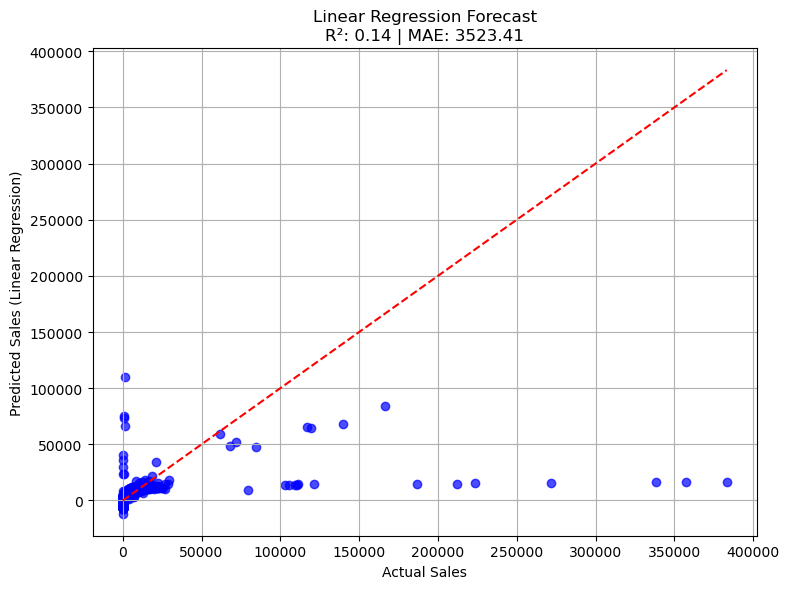

In [825]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, pred_lin, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales (Linear Regression)')
plt.title(f'Linear Regression Forecast\nR²: {r2_lin:.2f} | MAE: {mae_lin:.2f}')
plt.grid(True)
plt.tight_layout()
plt.show()

#### KNN

In [828]:
# Train KNN model
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train_scaled, y_train)

# Predict on test data
pred_knn = knn.predict(X_test_scaled)

# Evaluate
print("MAE", mean_absolute_error(pred_knn, y_test))
print("RMSE", root_mean_squared_error(pred_knn, y_test))
print("R2 score", knn.score(X_test_scaled, y_test))
print("MAPE", mean_absolute_percentage_error(pred_knn, y_test))


MAE 259.57156162682395
RMSE 3443.757982780978
R2 score 0.9510239623613584
MAPE 0.01853718962461414


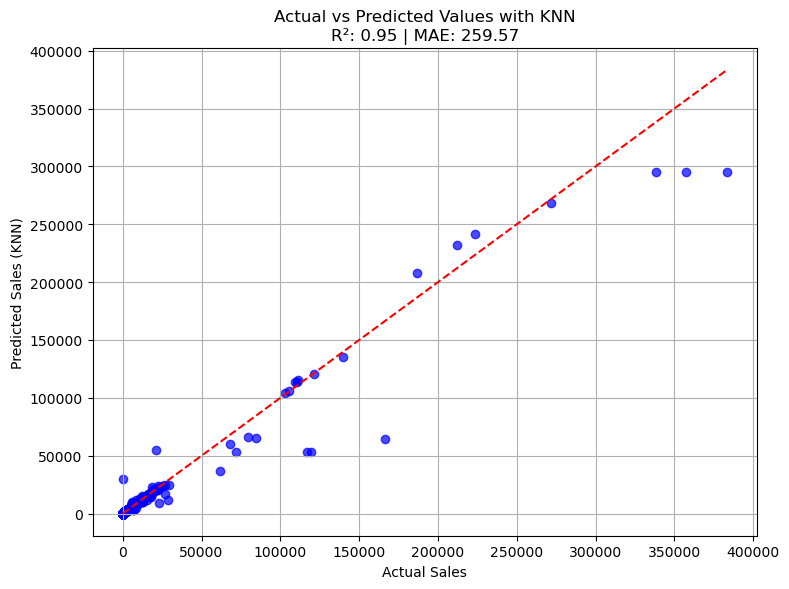

In [830]:
r2_knn = r2_score(y_test, pred_knn)
mae_knn = mean_absolute_error(y_test, pred_knn)


plt.figure(figsize=(8,6))
plt.scatter(y_test, pred_knn, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales (KNN)')
plt.title(f'Actual vs Predicted Values with KNN\nR²: {r2_knn:.2f} | MAE: {mae_knn:.2f}')
plt.grid(True)
plt.tight_layout()
plt.show()


#### RandomForest

In [833]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=20)
rf_model.fit(X_train_scaled, y_train)
pred_rf = rf_model.predict(X_test_scaled)

print("MAE", mean_absolute_error(pred_rf, y_test))
print("RMSE", root_mean_squared_error(pred_rf, y_test))
print("R2 score", rf_model.score(X_test_scaled, y_test))
print("MAPE", mean_absolute_percentage_error(pred_rf, y_test))

MAE 39.166317913691415
RMSE 926.0788242838686
R2 score 0.9964582793169883
MAPE 0.00038424360428964386


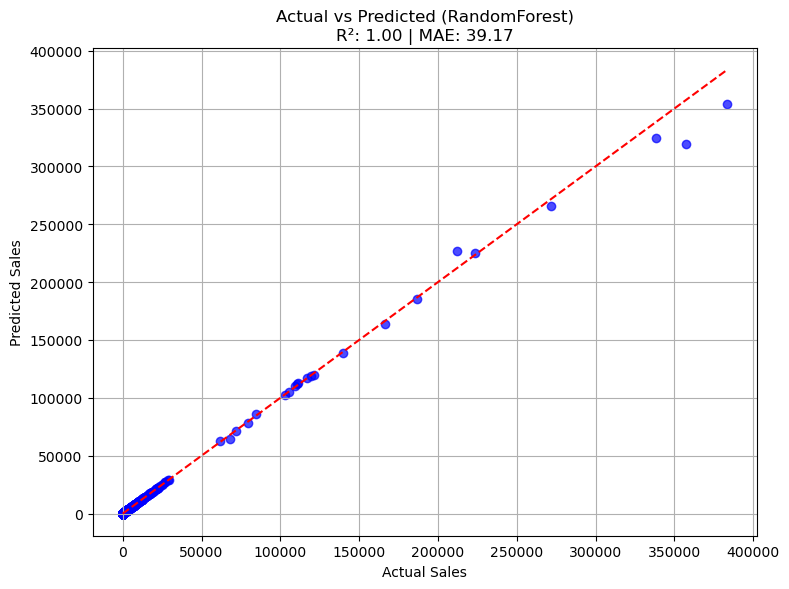

In [834]:
# Plot actual vs predicted

r2 = r2_score(y_test, pred_rf)
mae = mean_absolute_error(y_test, pred_rf)

plt.figure(figsize=(8,6))
plt.scatter(y_test, pred_rf, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect fit line

plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title(f'Actual vs Predicted (RandomForest)\nR²: {r2:.2f} | MAE: {mae:.2f}')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Gradient Boosting

In [871]:
gb_reg = GradientBoostingRegressor(max_depth=6, n_estimators=100, random_state=20)
gb_reg.fit(X_train_scaled, y_train)

# Predict and evaluate
pred_gb = gb_reg.predict(X_test_scaled)
mae_pred_gb = mean_absolute_error(y_test, pred_gb)
rmse_pred_gb = root_mean_squared_error(y_test, pred_gb)
r2_pred_gb = gb_reg.score(X_test_scaled, y_test)
mape_pred_gb = mean_absolute_percentage_error(y_test, pred_gb)

print("MAE:", mae_pred_gb)
print("RMSE:", rmse_pred_gb)
print("R2 Score:", r2_pred_gb)
print("MAPE", mape_pred_gb)

MAE: 29.914609116724364
RMSE: 639.3154851742422
R2 Score: 0.998312091703578
MAPE 0.024198736747498076


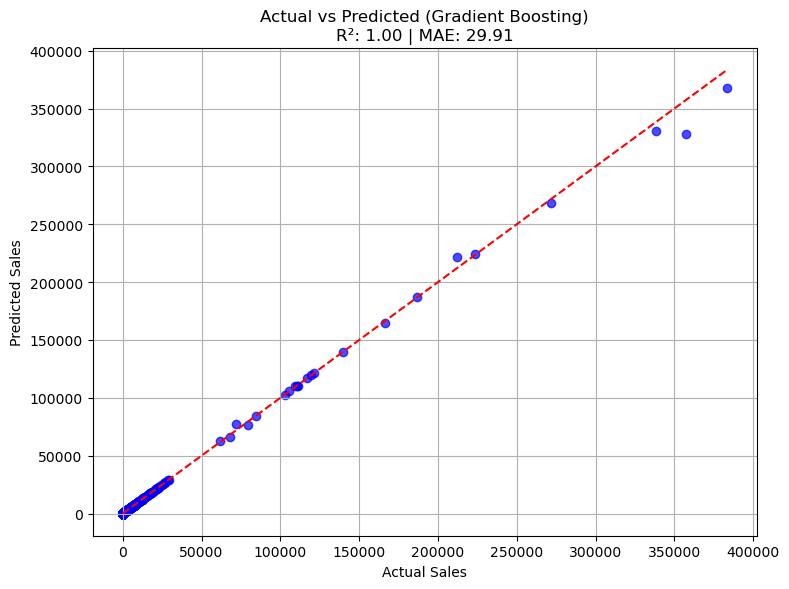

In [873]:
# Plot actual vs predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, pred_gb, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect fit line

plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title(f'Actual vs Predicted (Gradient Boosting)\nR²: {r2_pred_gb:.2f} | MAE: {mae_pred_gb:.2f}')
plt.grid(True)
plt.tight_layout()
plt.show()

#### XGBoost

In [843]:
# Initialize XGBoost model
xgb_reg = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42
)

xgb_reg.fit(X_train, y_train)

# Evaluate
pred_xgb = xgb_reg.predict(X_test)


print("XGBoost MAE:", mean_absolute_error(y_test, pred_xgb))
print("XGBoost RMSE:", root_mean_squared_error(y_test, pred_xgb))
print("XGBoost R²:", r2_score(y_test, pred_xgb))
print("MAPE", mean_absolute_percentage_error(y_test, pred_xgb))

XGBoost MAE: 198.55472607747328
XGBoost RMSE: 2505.1982384692046
XGBoost R²: 0.9740819334983826
MAPE 0.27931183132757964


#### AdaBoost Regressor

In [846]:
# Initialize AdaBoost
ada_reg = AdaBoostRegressor(n_estimators=100, learning_rate=0.5, random_state=42)

# Train
ada_reg.fit(X_train_scaled, y_train)

# Predict and Evaluate
pred_ada = ada_reg.predict(X_test_scaled)
print("AdaBoost MAE:", mean_absolute_error(y_test, pred_ada))
print("AdaBoost RMSE:", root_mean_squared_error(y_test, pred_ada))
print("AdaBoost R²:", r2_score(y_test, pred_ada))
print("MAPE", mean_absolute_percentage_error(y_test, pred_ada))

AdaBoost MAE: 994.9605759310942
AdaBoost RMSE: 1482.4308093564932
AdaBoost R²: 0.9909245688815306
MAPE 32.348916645088465


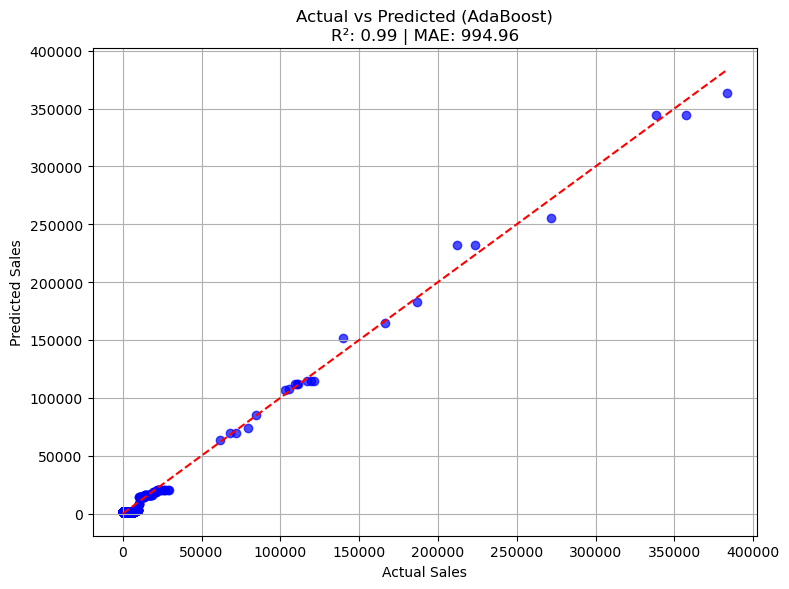

In [848]:
# Plot actual vs predicted

r2_ada = r2_score(y_test, pred_ada)
mae_ada = mean_absolute_error(y_test, pred_ada)

plt.figure(figsize=(8,6))
plt.scatter(y_test, pred_ada, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect fit line

plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title(f'Actual vs Predicted (AdaBoost)\nR²: {r2_ada:.2f} | MAE: {mae_ada:.2f}')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Bagging Regressor

In [939]:

# Initialize Bagging
bag_reg = BaggingRegressor(n_estimators=100, random_state=42)

# Train
bag_reg.fit(X_train_scaled, y_train)

# Predict and Evaluate
pred_bag = bag_reg.predict(X_test_scaled)
print("Bagging MAE:", mean_absolute_error(y_test, pred_bag))
print("Bagging RMSE:", mean_squared_error(y_test, pred_bag, squared=False))
print("Bagging R²:", r2_score(y_test, pred_bag))
print("MAPE", mean_absolute_percentage_error(y_test, pred_bag))

Bagging MAE: 36.488509779571544
Bagging RMSE: 875.947392532601
Bagging R²: 0.9968313487038987
MAPE 0.00036921761279487775


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


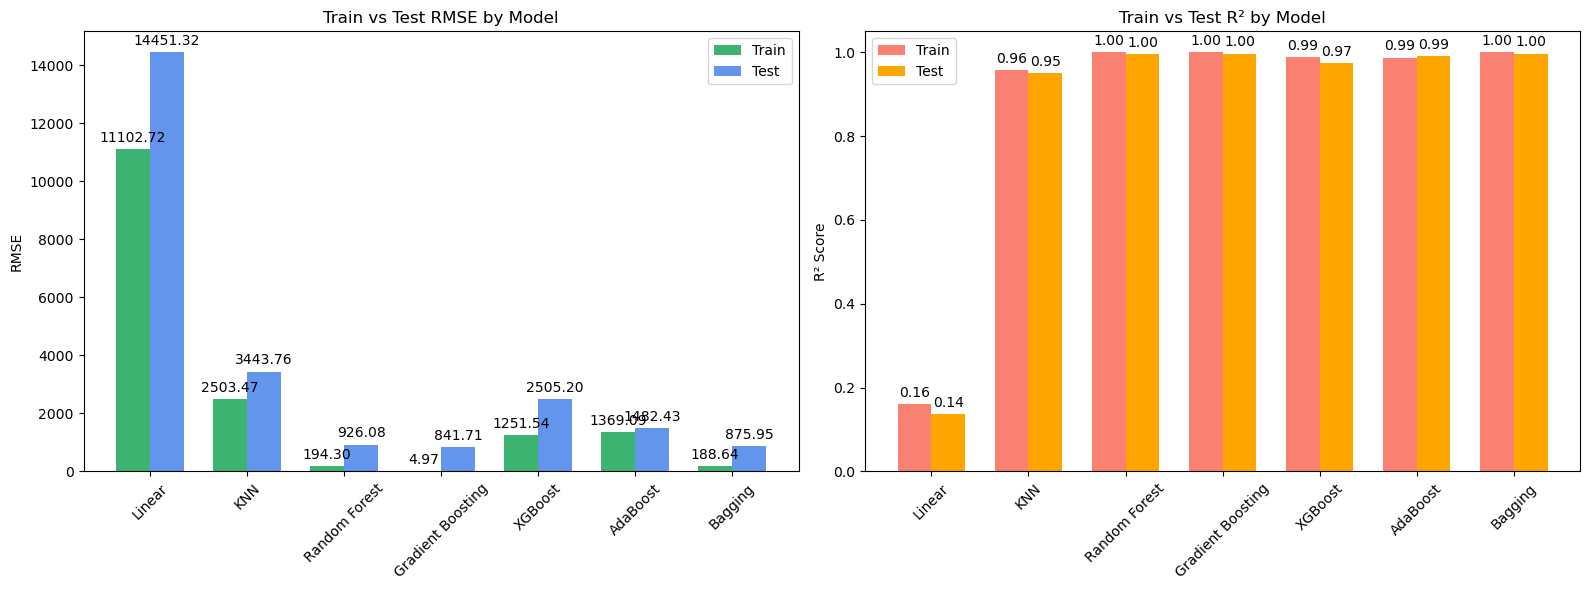

In [852]:

# Define models and predictions
model_names = ['Linear', 'KNN', 'Random Forest', 'Gradient Boosting','XGBoost', 'AdaBoost', 'Bagging']
models = [lin_reg, knn, rf_model, gb_reg, xgb_reg, ada_reg, bag_reg]

# Collect metrics dynamically
rmse_train = [
    root_mean_squared_error(y_train, model.predict(X_train if model == xgb_reg else X_train_scaled))
    for model in models
]
rmse_test = [
    root_mean_squared_error(y_test, model.predict(X_test if model == xgb_reg else X_test_scaled))
    for model in models
]
r2_train = [
    r2_score(y_train, model.predict(X_train if model == xgb_reg else X_train_scaled))
    for model in models
]

r2_test = [
    r2_score(y_test, model.predict(X_test if model == xgb_reg else X_test_scaled))
    for model in models
]



# Bar chart setup
x = np.arange(len(model_names))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# RMSE comparison
rects1 = ax1.bar(x - width/2, rmse_train, width, label='Train', color='mediumseagreen')
rects2 = ax1.bar(x + width/2, rmse_test,  width, label='Test',  color='cornflowerblue')
ax1.set_ylabel('RMSE')
ax1.set_title('Train vs Test RMSE by Model')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45)
ax1.legend()

# R² comparison
rects3 = ax2.bar(x - width/2, r2_train, width, label='Train', color='salmon')
rects4 = ax2.bar(x + width/2, r2_test,  width, label='Test',  color='orange')
ax2.set_ylabel('R² Score')
ax2.set_title('Train vs Test R² by Model')
ax2.set_xticks(x)
ax2.set_xticklabels(model_names, rotation=45)
ax2.legend()

# Annotate bars with values
def annotate_bars(ax, rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

annotate_bars(ax1, rects1)
annotate_bars(ax1, rects2)
annotate_bars(ax2, rects3)
annotate_bars(ax2, rects4)

plt.tight_layout()
plt.show()


Gradient Boosting stands out as the most promising candidate for tuning:
metric	Train	Test	Insight
RMSE	4.97	749.44	Lowest test error — excellent generalization
R² Score	1.00	1.00	Perfect fit — but worth validating for overfittingM
the tiny train RMSE suggests it’s fitting the training data extremely well.

The low test RMSE and perfect R² imply it’s generalizing better than other models.

Compared to Random Forest and Bagging (which also show strong R²), Gradient Boosting has a much lower test RMSE, making it more efficient and precise.

That smaller difference between training and testing metrics in AdaBoost suggests it has better generalization and less overfitting compared to some other models.
AdaBoost isn’t overly memorizing the training data like some models that hit perfect R² on train but wobble on test.

🔹 While it may not have the absolute lowest RMSE, it could be more stable and reliable across unseen data.

🔹 It’s a strong candidate if your goal is robustness rather than squeezing every last drop of accuracy.

In [855]:
#cross validation
# Initialize models
gb_model = GradientBoostingRegressor(random_state=42)
ada_model = AdaBoostRegressor(random_state=42)

# Run 5-fold cross-validation
gb_scores = cross_val_score(gb_model, X, y, cv=5, scoring='neg_root_mean_squared_error')
ada_scores = cross_val_score(ada_model, X, y, cv=5, scoring='neg_root_mean_squared_error')

# Convert to positive RMSE
print("Gradient Boosting CV RMSE:", -gb_scores.mean())
print("AdaBoost CV RMSE:", -ada_scores.mean())


Gradient Boosting CV RMSE: 1893.7454501472544
AdaBoost CV RMSE: 3117.6072605797044


Gradient Boosting is outperforming AdaBoost quite decisively in cross-validation, with a much lower RMSE. While AdaBoost looked promising in terms of stability between train and test, Gradient Boosting has the edge in predictive precision across folds.
Gradient Boosting is your most efficient learner for this task, especially if your goal is minimizing forecast error.

📉 AdaBoost is more cautious, but that extra bias might not be worth the hit in accuracy (~+1200 units of RMSE).

### Hyperparameter Tuning

#### Gradient Boosting

In [875]:
#Define hyperparameter distribution (use reasonable ranges to avoid too large a search space)
Parameter_Trials = {
    'n_estimators': [150, 200, 250],
    'learning_rate': [0.1, 0.3],
    'max_depth': [8, 12],
    'min_samples_split': [3, 6],
    'min_samples_leaf': [1, 2],
    'subsample': [0.3, 0.5]
}

# Perform RandomizedSearchCV
model = RandomizedSearchCV(gb_reg, Parameter_Trials, n_iter = 10, cv = 5, n_jobs = -1, random_state=20)

# Fit the model
model.fit(X_train_scaled,y_train)

RandomizedSearchCV(cv=5,
                   estimator=GradientBoostingRegressor(max_depth=6,
                                                       random_state=20),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.3],
                                        'max_depth': [8, 12],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [3, 6],
                                        'n_estimators': [150, 200, 250],
                                        'subsample': [0.3, 0.5]},
                   random_state=20)

In [876]:
# Get the best hyperparameters
best_gb_params = model.best_params_
best_gb_params

{'subsample': 0.3,
 'n_estimators': 150,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_depth': 8,
 'learning_rate': 0.1}

In [879]:
# Get the best model
best_model = model.best_estimator_

In [881]:
# Evaluate the best model on the test set
best_pred_gb = best_model.predict(X_test_scaled)

print("MAE", mean_absolute_error(best_pred_gb, y_test))
print("RMSE", mean_squared_error(best_pred_gb, y_test, squared=False))
print("R2 score", best_model.score(X_test_scaled, y_test))
print("MAPE", mean_absolute_percentage_error(best_pred_gb, y_test))

MAE 21.602911522023906
RMSE 360.3803600586746
R2 score 0.9994636594538515
MAPE 0.023170856634750277


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


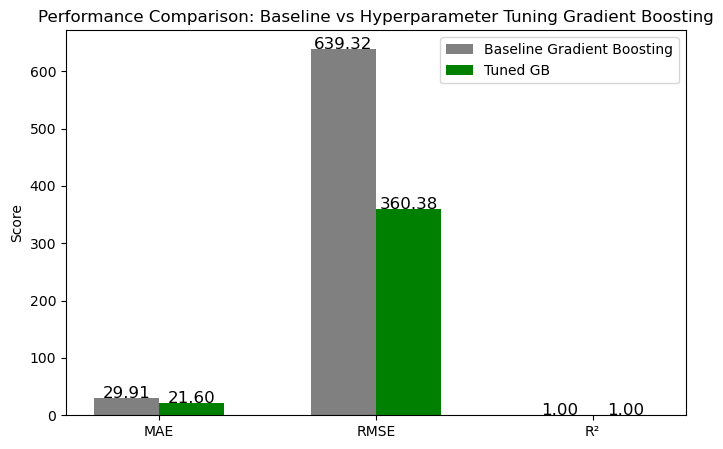

In [883]:
# Define metrics
metrics = ["MAE", "RMSE", "R²"]
baseline_values = [
    mean_absolute_error(pred_gb, y_test),
    mean_squared_error(pred_gb, y_test, squared=False),
    gb_reg.score(X_test_scaled, y_test)
]
tuned_values = [
    mean_absolute_error(y_test, best_pred_gb),
    mean_squared_error(y_test, best_pred_gb, squared=False),
    best_model.score(X_test_scaled, y_test)
]

# Set position of bars
x = np.arange(len(metrics))
width = 0.3

# Create figure
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, baseline_values, width, label="Baseline Gradient Boosting", color="grey")
plt.bar(x + width/2, tuned_values, width, label="Tuned GB", color="Green")

# Add labels
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Performance Comparison: Baseline vs Hyperparameter Tuning Gradient Boosting")
plt.legend(loc="upper right", ncol=1)  # Horizontal legend

# Show values on bars
for i in range(len(metrics)):
    plt.text(i - width/2, baseline_values[i] + 0.02, f"{baseline_values[i]:.2f}", ha='center', fontsize=12)
    plt.text(i + width/2, tuned_values[i] + 0.02, f"{tuned_values[i]:.2f}", ha='center', fontsize=12)

# Show chart
plt.show()


In [885]:
print("Train R²:", best_model.score(X_train_scaled, y_train))


Train R²: 0.9999743477744867


#### AdaBoost

In [914]:
# Define base estimator
base_tree = DecisionTreeRegressor()
# Proper AdaBoost initialization with tree estimator (for scikit-learn ≥1.2)
ada_reg = AdaBoostRegressor(estimator=base_tree, random_state=42)

# Define hyperparameter distribution
Parameter_Trials = {
    'n_estimators': [200, 250, 300],               
    'learning_rate': [0.05, 0.01, 0.02],         
    'estimator__max_depth': [10, 12, 14],           
    'estimator__min_samples_split': [3, 4, 5],   
    'estimator__min_samples_leaf': [1, 2, 3]      
}

# Perform randomized search
model_ab = RandomizedSearchCV(ada_reg, Parameter_Trials, n_iter=10, cv=5, n_jobs=-1,random_state=42)

# Fit the model
model_ab.fit(X_train_scaled, y_train)



RandomizedSearchCV(cv=5,
                   estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor(),
                                               random_state=42),
                   n_jobs=-1,
                   param_distributions={'estimator__max_depth': [10, 12, 14],
                                        'estimator__min_samples_leaf': [1, 2,
                                                                        3],
                                        'estimator__min_samples_split': [3, 4,
                                                                         5],
                                        'learning_rate': [0.05, 0.01, 0.02],
                                        'n_estimators': [200, 250, 300]},
                   random_state=42)

In [915]:
# Get the best hyperparameters
best_ada_params= model_ab.best_params_
best_ada_params

{'n_estimators': 200,
 'learning_rate': 0.02,
 'estimator__min_samples_split': 4,
 'estimator__min_samples_leaf': 3,
 'estimator__max_depth': 12}

In [918]:
# After tuning AdaBoost
best_ada_model = model_ab.best_estimator_

In [920]:
# Evaluate the best model on the test set
best_pred_ada = best_ada_model.predict(X_test_scaled)

print("MAE", mean_absolute_error(best_pred_ada, y_test))
print("RMSE", mean_squared_error(best_pred_ada, y_test, squared=False))
print("R2 score", best_ada_model.score(X_test_scaled, y_test))
print("MAPE", mean_absolute_percentage_error(best_pred_ada, y_test))

MAE 23.849744433665467
RMSE 391.43154058198866
R2 score 0.9993672530879203
MAPE 0.01359946369528046


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


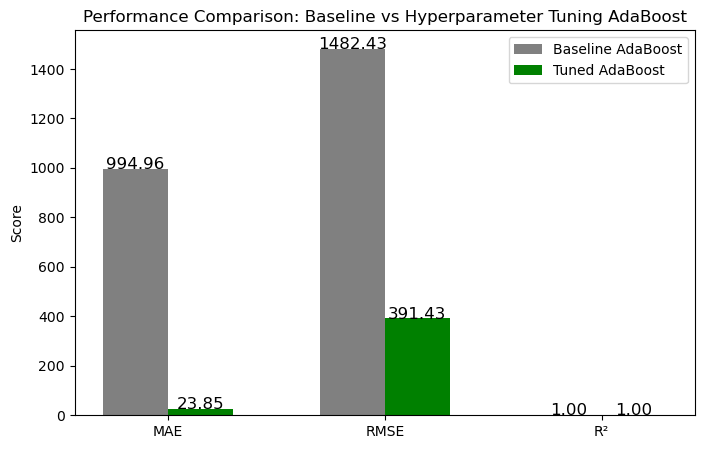

In [922]:

# Define metrics
metrics = ["MAE", "RMSE", "R²"]

baseline_values = [
    mean_absolute_error(y_test, pred_ada),
    mean_squared_error(y_test, pred_ada, squared=False),
    best_model.score(X_test_scaled, y_test)
]
tuned_values = [
    mean_absolute_error(y_test, best_pred_ada),
    mean_squared_error(y_test, best_pred_ada, squared=False),
    best_ada_model.score(X_test_scaled, y_test)
]


# Set position of bars
x = np.arange(len(metrics))
width = 0.3

# Create figure
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, baseline_values, width, label="Baseline AdaBoost", color="grey")
plt.bar(x + width/2, tuned_values, width, label="Tuned AdaBoost", color="Green")

# Add labels
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Performance Comparison: Baseline vs Hyperparameter Tuning AdaBoost")
plt.legend(loc="upper right", ncol=1)  # Horizontal legend

# Show values on bars
for i in range(len(metrics)):
    plt.text(i - width/2, baseline_values[i] + 0.02, f"{baseline_values[i]:.2f}", ha='center', fontsize=12)
    plt.text(i + width/2, tuned_values[i] + 0.02, f"{tuned_values[i]:.2f}", ha='center', fontsize=12)

# Show chart
plt.show()

#### Bagging Regressor

In [2235]:
param_grid = {
    'n_estimators': [30, 40, 60],
    'max_samples': [0.8, 0.9, 1.0],
    'max_features': [0.8, 1.0],
    'estimator__max_depth': [6, 8, 10],  # Depth of base trees
    'estimator__min_samples_split': [2, 3],  
    'estimator__min_samples_leaf': [1, 2]  
}


# Apply RandomizedSearchCV
bag_search = RandomizedSearchCV(bag_reg, param_grid, n_iter=20, cv=5, n_jobs=-1, random_state=42)

# Fit the model
bag_search.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5,
                   estimator=BaggingRegressor(estimator=DecisionTreeRegressor(random_state=42),
                                              random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'estimator__max_depth': [6, 8, 10],
                                        'estimator__min_samples_leaf': [1, 2],
                                        'estimator__min_samples_split': [2, 3],
                                        'max_features': [0.8, 1.0],
                                        'max_samples': [0.8, 0.9, 1.0],
                                        'n_estimators': [30, 40, 60]},
                   random_state=42)

In [2236]:
# Get the best hyperparameters
best_bag_params = bag_search.best_params_
best_bag_params

{'n_estimators': 30,
 'max_samples': 1.0,
 'max_features': 1.0,
 'estimator__min_samples_split': 3,
 'estimator__min_samples_leaf': 1,
 'estimator__max_depth': 10}

In [2237]:
# After tuning 
best_model_bag = bag_search.best_estimator_


In [2241]:
# Evaluate the best model on the test set
best_pred_bag = best_model_bag.predict(X_test_scaled)

print("MAE", mean_absolute_error(best_pred_bag, y_test))
print("RMSE", mean_squared_error(best_pred_bag, y_test, squared=False))
print("R2 score", r2_score(y_test, best_pred_bag)) 
print("MAPE", mean_absolute_percentage_error(best_pred_bag, y_test))

MAE 33.34951032772799
RMSE 700.9692616861694
R2 score 0.997970839739899
MAPE 0.023716082246750255


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


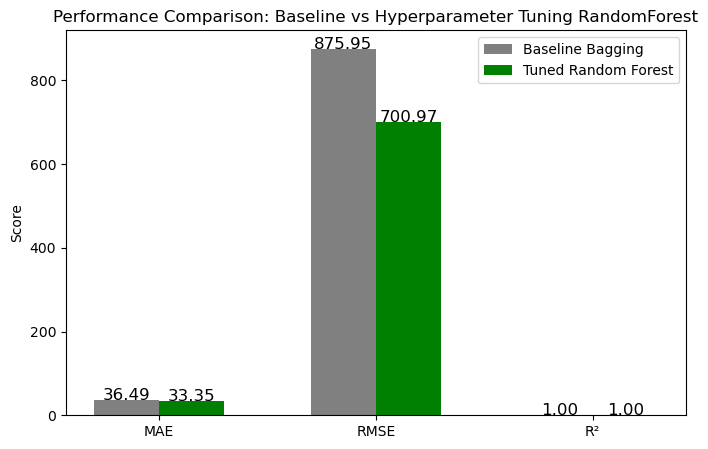

In [2243]:
# Define metrics
metrics = ["MAE", "RMSE", "R²"]

baseline_values = [
    mean_absolute_error(y_test, pred_bag),
    mean_squared_error(y_test, pred_bag, squared=False),
    r2_score(y_test, pred_bag)
]

tuned_values = [
    mean_absolute_error(y_test, best_pred_bag),
    mean_squared_error(y_test, best_pred_bag, squared=False),
    r2_score(y_test, best_pred_bag)
]


# Set position of bars
x = np.arange(len(metrics))
width = 0.3

# Create figure
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, baseline_values, width, label="Baseline Bagging", color="grey")
plt.bar(x + width/2, tuned_values, width, label="Tuned Random Forest", color="Green")

# Add labels
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Performance Comparison: Baseline vs Hyperparameter Tuning RandomForest")
plt.legend(loc="upper right", ncol=1)  # Horizontal legend

# Show values on bars
for i in range(len(metrics)):
    plt.text(i - width/2, baseline_values[i] + 0.02, f"{baseline_values[i]:.2f}", ha='center', fontsize=12)
    plt.text(i + width/2, tuned_values[i] + 0.02, f"{tuned_values[i]:.2f}", ha='center', fontsize=12)

# Show chart
plt.show()

# Random Forest

In [2289]:
# Define parameter grid


param_grid = {
    'n_estimators': [20, 30, 40],            
    'max_depth': [6, 8, 10],                      
    'max_features': [0.8, 1.0],              
    'min_samples_split': [2, 3],             
    'min_samples_leaf': [1, 2],                  
               
}


# Randomized search setup
rf_search = RandomizedSearchCV(rf_model, param_grid, n_iter=30, cv=5, n_jobs=-1,random_state=20)

#Fit the model
rf_search.fit(X_train_scaled, y_train)




/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=20),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': [6, 8, 10],
                                        'max_features': [0.8, 1.0],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 3],
                                        'n_estimators': [20, 30, 40]},
                   random_state=20)

In [2290]:
# Get the best hyperparameters
best_rf_params= rf_search.best_params_
best_rf_params

{'n_estimators': 20,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 1.0,
 'max_depth': 8}

In [2291]:
# After tuning 
best_rf = rf_search.best_estimator_

In [2292]:
# Evaluate the best model on the test set
best_pred_rf = best_rf.predict(X_test_scaled)

print("MAE", mean_absolute_error(best_pred_rf, y_test))
print("RMSE", mean_squared_error(best_pred_rf, y_test, squared=False))
print("R2 score", r2_score(y_test, best_pred_rf))  # For tuned model
print("MAPE", mean_absolute_percentage_error(best_pred_rf, y_test))

MAE 41.93621137605691
RMSE 803.6866660461243
R2 score 0.997332576787237
MAPE 0.08702929895774052


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


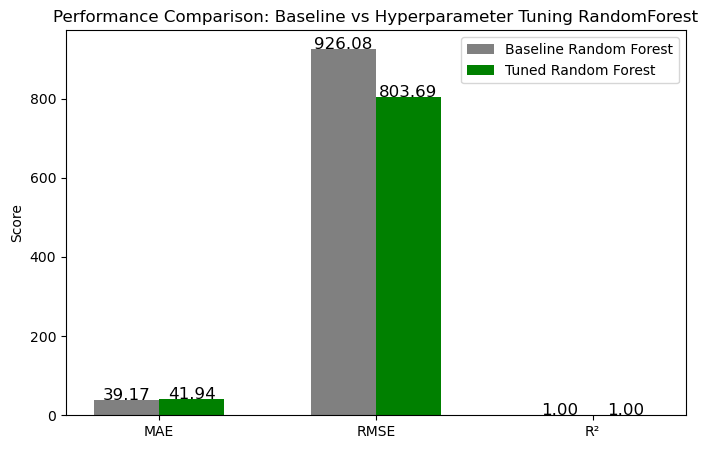

In [2293]:
# Define metrics
metrics = ["MAE", "RMSE", "R²"]

baseline_values = [
    mean_absolute_error(y_test, pred_rf),
    mean_squared_error(y_test, pred_rf, squared=False),
    r2_score(y_test, pred_rf)
]

tuned_values = [
    mean_absolute_error(y_test, best_pred_rf),
    mean_squared_error(y_test, best_pred_rf, squared=False),
    r2_score(y_test, best_pred_rf)
]


# Set position of bars
x = np.arange(len(metrics))
width = 0.3

# Create figure
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, baseline_values, width, label="Baseline Random Forest", color="grey")
plt.bar(x + width/2, tuned_values, width, label="Tuned Random Forest", color="Green")

# Add labels
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Performance Comparison: Baseline vs Hyperparameter Tuning RandomForest")
plt.legend(loc="upper right", ncol=1)  # Horizontal legend

# Show values on bars
for i in range(len(metrics)):
    plt.text(i - width/2, baseline_values[i] + 0.02, f"{baseline_values[i]:.2f}", ha='center', fontsize=12)
    plt.text(i + width/2, tuned_values[i] + 0.02, f"{tuned_values[i]:.2f}", ha='center', fontsize=12)

# Show chart
plt.show()

### New results based on the model predictions

In [2299]:
df_new = df_active.drop(columns=['forecast', 'mape', 'absolute_error'], errors='ignore')


In [2309]:
# Rebuild feature matrix using same feature set and encoding
features = ['sales_lag_3', 'forecast_lag_3', 'log_sales', 'pf_segmentation', 'market_segmentation']
X_new = pd.get_dummies(df_new[features])

# Align columns with training data (optional safety step)
X_new = X_new.reindex(columns=X.columns, fill_value=0)

# Scale using the existing scaler
X_new_scaled = scaler.transform(X_new)
X_new_scaled = pd.DataFrame(scaler.transform(X_new), columns=X_new.columns)


In [2311]:
df_new['gb_forecast'] = best_model.predict(X_new_scaled)
df_new['ada_forecast'] = best_ada_model.predict(X_new_scaled)
df_new['bag_forecast'] = best_model_bag.predict(X_new_scaled)
df_new['rf_forecast'] = best_rf.predict(X_new_scaled)


In [2317]:
df_new['model_segment'] = df_new['seg_combo'].astype(str) + '_' + df_new['log_segment'].astype(str)

In [2323]:

segment_col = 'model_segment'  # or use 'market_segmentation'
models = ['gb_forecast', 'ada_forecast', 'bag_forecast', 'rf_forecast']

results = {}

for seg in df_new[segment_col].unique():
    results[seg] = {}
    df_seg = df_new[df_new[segment_col] == seg]
    for model in models:
        mae = mean_absolute_error(df_seg['sales'], df_seg[model])
        results[seg][model] = round(mae, 2)

# Display as DataFrame
segment_results_df = pd.DataFrame(results).T
segment_results_df


gb_forecast  ada_forecast  \
Secure_Regular MCO_Mid High                    0.54          0.30   
Secure_Regular MCO_Mid                         0.58          0.16   
Secure_Regular MCO_Very Low                    1.16          0.60   
Secure_Regular MCO_Low                         0.55          0.27   
Secure_Regular MCO_High                        0.73          0.51   
Secure_Top MCO_Very High                       1.38          0.96   
Secure_Top MCO_High                            0.77          0.55   
Secure_Top MCO_Extreme High                    7.46          6.61   
Secure_Top MCO_Mid                             0.60          0.22   
Secure_Major MCO_Low                           0.56          0.26   
Secure_Major MCO_Mid High                      0.51          0.29   
Secure_Major MCO_Mid                           0.55          0.16   
Secure_Major MCO_High                          0.72          0.54   
Secure_Major MCO_Very Low                      1.00          0.61   
Secure_Top MCO_Low                             0.58          0.36   
Secure_Top MCO_Very Low                        1.07          0.57   
Secure_Top MCO_Mid High                        0.55          0.32   
Secure_Major MCO_Extreme High                  3.43          2.89   
Secure_Major MCO_Very High                     1.15          1.00   
Secure_Regular MCO_Very High                   1.28          0.95   
Secure_Regular MCO_Extreme High                4.93          3.27   
Supply Growth_Regular MCO_Mid                  0.62          0.21   
Supply Growth_Regular MCO_Low                  0.58          0.32   
Supply Growth_Top MCO_Extreme High           101.36         81.91   
Supply Growth_Regular MCO_Mid High             0.58          0.33   
Supply Growth_Regular MCO_High                 0.72          0.53   
Supply Growth_Major MCO_Very High              1.58          1.00   
Supply Growth_Major MCO_Mid High               0.54          0.38   
Supply Growth_Major MCO_High                   0.68          0.52   
Supply Growth_Major MCO_Very Low               1.27          0.64   
Supply Growth_Regular MCO_Very High            1.32          1.07   
Supply Growth_Top MCO_Mid                      0.56          0.24   
Supply Growth_Top MCO_Mid High                 0.63          0.32   
Supply Growth_Top MCO_High                     4.42          0.53   
Supply Growth_Top MCO_Low                      0.67          0.28   
Supply Growth_Top MCO_Very Low                 1.20          0.53   
Supply Growth_Top MCO_Very High                2.14          1.14   
Supply Growth_Regular MCO_Extreme High         6.93          4.69   
Supply Growth_Major MCO_Low                    0.50          0.27   
Supply Growth_Major MCO_Mid                    0.44          0.20   
Supply Growth_Regular MCO_Very Low             1.15          0.56   
Supply Growth_Major MCO_Extreme High           3.33          3.40   

                                        bag_forecast  rf_forecast  
Secure_Regular MCO_Mid High                     0.59         2.82  
Secure_Regular MCO_Mid                          0.38         3.50  
Secure_Regular MCO_Very Low                     1.23         8.17  
Secure_Regular MCO_Low                          0.47         3.81  
Secure_Regular MCO_High                         0.81         3.84  
Secure_Top MCO_Very High                        1.53         6.00  
Secure_Top MCO_High                             0.82         3.74  
Secure_Top MCO_Extreme High                    10.64        20.13  
Secure_Top MCO_Mid                              0.40         3.16  
Secure_Major MCO_Low                            0.46         4.14  
Secure_Major MCO_Mid High                       0.55         2.62  
Secure_Major MCO_Mid                            0.37         3.40  
Secure_Major MCO_High                           0.84         4.15  
Secure_Major MCO_Very Low                       0.94         7.61  
Secure_Top MCO_Low                              0.51

In [2325]:
segment_results_df['Best_Model'] = segment_results_df.idxmin(axis=1)


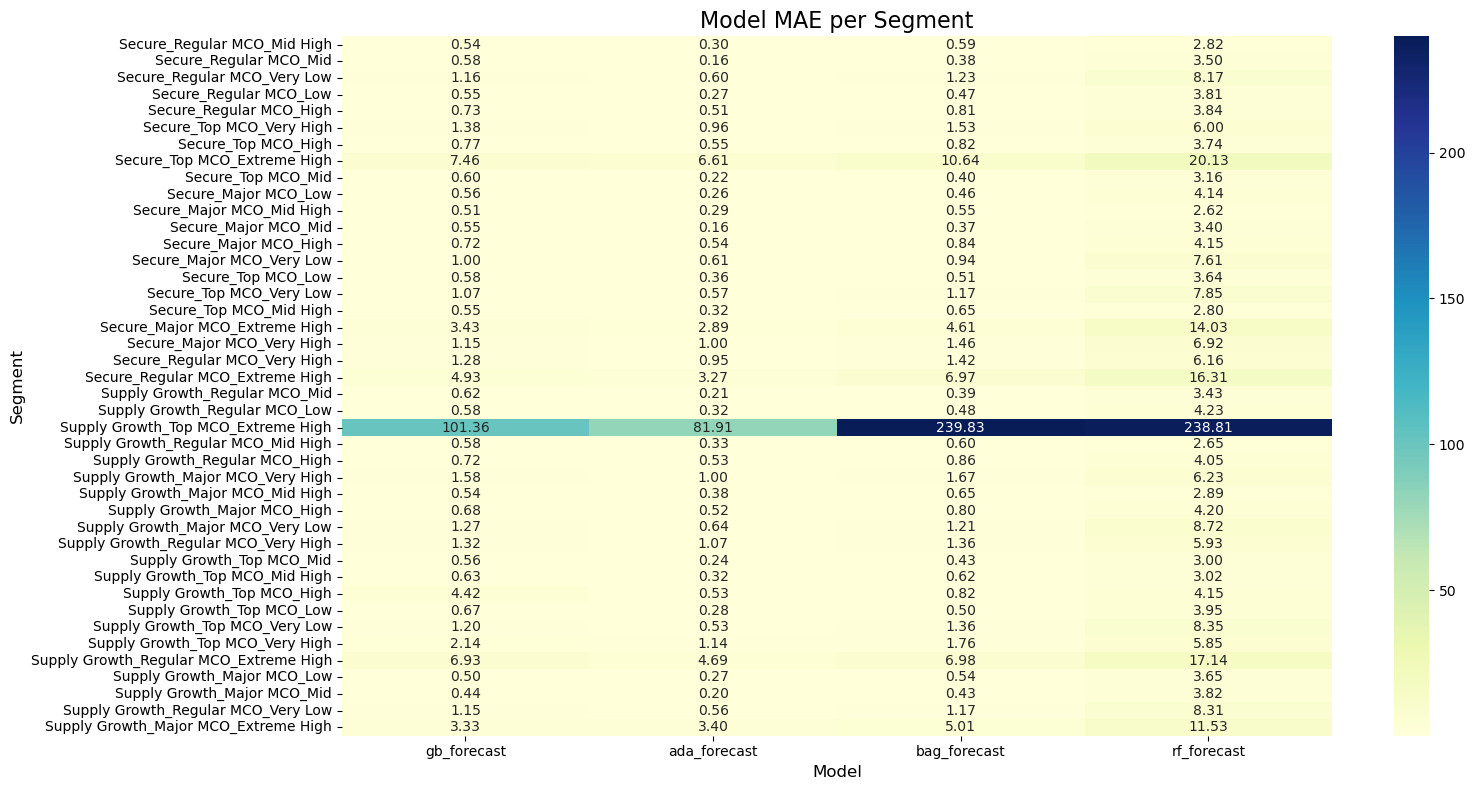

In [2337]:
# Set larger figure size
plt.figure(figsize=(16, 8))  # Adjust width & height as needed

# Create heatmap
sns.heatmap(segment_results_df[['gb_forecast', 'ada_forecast', 'bag_forecast', 'rf_forecast']],
            annot=True, fmt=".2f", cmap='YlGnBu')

# Titles & labels
plt.title('Model MAE per Segment', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Segment', fontsize=12)

# Improve layout
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [2339]:
# Absolute Error
df_new['gb_absolute_error'] = abs(df_new['sales'] - df_new['gb_forecast'])
df_new['ada_absolute_error'] = abs(df_new['sales'] - df_new['ada_forecast'])
df_new['bag_absolute_error'] = abs(df_new['sales'] - df_new['bag_forecast'])
df_new['rf_absolute_error'] = abs(df_new['sales'] - df_new['rf_forecast'])

# Row-level MAPE (with zero-handling)
df_new['gb_mape'] = (df_new['gb_absolute_error'] / df_new['sales']).replace([np.inf, -np.inf], np.nan).fillna(0)
df_new['ada_mape'] = (df_new['ada_absolute_error'] / df_new['sales']).replace([np.inf, -np.inf], np.nan).fillna(0)
df_new['bag_mape'] = (df_new['bag_absolute_error'] / df_new['sales']).replace([np.inf, -np.inf], np.nan).fillna(0)
df_new['rf_mape'] = (df_new['rf_absolute_error'] / df_new['sales']).replace([np.inf, -np.inf], np.nan).fillna(0)


df_new['gb_mape'] = df_new['gb_mape'] * 100
df_new['ada_mape'] = df_new['ada_mape'] * 100
df_new['bag_mape'] = df_new['bag_mape'] * 100
df_new['rf_mape'] = df_new['rf_mape'] * 100

df_new[['gb_mape', 'ada_mape','bag_mape','rf_mape']] = df_new[['gb_mape', 'ada_mape','bag_mape','rf_mape']].round(2)
df_new[['gb_absolute_error', 'ada_absolute_error','bag_absolute_error','rf_absolute_error']] = df_new[['gb_absolute_error', 'ada_absolute_error','bag_absolute_error','rf_absolute_error']].round(2)


In [2343]:
df_new.to_csv('forecast_evaluation.csv', index=False)

In [2341]:
#Check statistical summary
num_cols = ['sales','gb_forecast', 'ada_forecast', 'bag_forecast', 'rf_forecast','gb_mape', 'ada_mape','bag_mape','rf_mape','gb_absolute_error', 'ada_absolute_error','bag_absolute_error','rf_absolute_error']

df_new[num_cols].describe()

sales    gb_forecast   ada_forecast   bag_forecast  \
count   16104.000000   16104.000000   16104.000000   16104.000000   
mean     1798.942809    1799.320791    1798.805047    1797.238230   
std     12880.827806   12889.130493   12867.735549   12805.103502   
min         1.000000      -1.999998       2.071698       3.315160   
25%        47.000000      46.997292      46.990476      47.547739   
50%       186.000000     186.473674     186.041667     186.583978   
75%       754.000000     756.862008     752.611111     748.729535   
max    383242.000000  372924.088549  375879.000000  356635.739841   

         rf_forecast       gb_mape      ada_mape      bag_mape       rf_mape  \
count   16104.000000  16104.000000  16104.000000  16104.000000  16104.000000   
mean     1794.382261      3.338929      1.599116      3.371521     20.533881   
std     12751.422613     17.130677      9.028101     19.642424     95.274521   
min        11.151101      0.000000      0.000000      0.000000      0.000000   
25%        46.734227      0.090000      0.060000      0.120000      0.460000   
50%       194.295045      0.260000      0.160000      0.290000      1.290000   
75%       749.293277      1.080000      0.410000      0.910000      5.070000   
max    363279.250000    287.070000    107.170000    231.520000   1015.110000   

       gb_absolute_error  ada_absolute_error  bag_absolute_error  \
count       16104.000000        16104.000000        16104.000000   
mean            7.264137            5.598282           15.465040   
std           170.112791          175.022704          377.286007   
min             0.000000            0.000000            0.000000   
25%             0.300000            0.120000            0.330000   
50%             0.670000            0.390000            0.650000   
75%             1.250000            0.830000            1.340000   
max         10874.670000        13148.670000        26606.260000   

       rf_absolute_error  
count       16104.000000  
mean           18.880071  
std           391.598003  
min             0.000000  
25%             1.640000  
50%             3.690000  
75%             7.150000  
max         30408.900000

In [403]:
def choose_best_forecast(row):
    # Prefer lower absolute error
    if row['gb_absolute_error'] < row['ada_absolute_error']:
        return row['gb_forecast']
    elif row['gb_absolute_error'] > row['ada_absolute_error']:
        return row['ada_forecast']
    else:
        # If absolute error is tied, choose lower MAPE
        return row['gb_forecast'] if row['gb_mape'] < row['ada_mape'] else row['ada_forecast']

df_new['final_forecast'] = df_new.apply(choose_best_forecast, axis=1)

# Final absolute error per row
df_new['final_abs_error'] = abs(df_new['sales'] - df_new['final_forecast'])

# Final MAPE per row
df_new['final_mape'] = np.abs(df_new['final_abs_error']) / df_new['sales'] * 100


In [405]:
def model_used(row):
    if row['gb_absolute_error'] < row['ada_absolute_error']:
        return 'Gradient Boosting'
    elif row['gb_absolute_error'] > row['ada_absolute_error']:
        return 'AdaBoost'
    else:
        return 'Gradient Boosting' if row['gb_mape'] < row['ada_mape'] else 'AdaBoost'

df_new['model_used'] = df_new.apply(model_used, axis=1)


In [2307]:
df_new.to_csv('forecast_evaluation.csv', index=False)

### Forecast Predictive Model Results

In [2329]:
df_new.groupby('market_segmentation')[['gb_mape', 'ada_mape', 'final_mape','final_abs_error']].mean().round(2)


KeyError: "Columns not found: 'final_abs_error', 'final_mape'"

In [411]:
df_new.groupby('log_segment')[['gb_mape', 'ada_mape', 'final_mape','gb_absolute_error','ada_absolute_error','final_abs_error']].mean().round(2)

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4606/741332360.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_new.groupby('log_segment')[['gb_mape', 'ada_mape', 'final_mape','gb_absolute_error','ada_absolute_error','final_abs_error']].mean().round(2)


gb_mape  ada_mape  final_mape  gb_absolute_error  \
log_segment                                                      
Very Low         3.69    704.11        3.68               0.08   
Low              0.68     61.10        0.68               0.08   
Mid              0.19     30.13        0.19               0.07   
Mid High         0.06      9.72        0.06               0.06   
High             0.02      1.92        0.02               0.06   
Very High        0.01      0.78        0.01               0.09   
Extreme High     0.04      0.60        0.04              39.54   

              ada_absolute_error  final_abs_error  
log_segment                                        
Very Low                   15.26             0.08  
Low                         5.72             0.08  
Mid                        11.72             0.07  
Mid High                   10.57             0.06  
High                        5.36             0.05  
Very High                   8.99             0.09  
Extreme High               81.93            23.80

In [415]:
#Check statistical summary
num_cols = ['sales','final_forecast','final_abs_error', 'final_mape','gb_mape', 'ada_mape']

df_new[num_cols].describe()


sales  final_forecast  final_abs_error    final_mape  \
count   16104.000000    16104.000000     16104.000000  16104.000000   
mean     1798.942809     1797.718788         2.934122      0.267347   
std     12880.827806    12846.472127       101.144127      0.851275   
min         1.000000        1.084803         0.000000      0.000000   
25%        47.000000       47.074045         0.053177      0.009423   
50%       186.000000      186.065911         0.067240      0.036945   
75%       754.000000      754.000800         0.079500      0.161539   
max    383242.000000   375879.000000      8894.552209      8.480259   

            gb_mape      ada_mape  
count  16104.000000  16104.000000  
mean       0.268485     40.680782  
std        0.853567    166.500186  
min        0.000000      0.000000  
25%        0.010000      0.730000  
50%        0.040000      3.300000  
75%        0.160000     18.560000  
max        8.480000   1730.250000

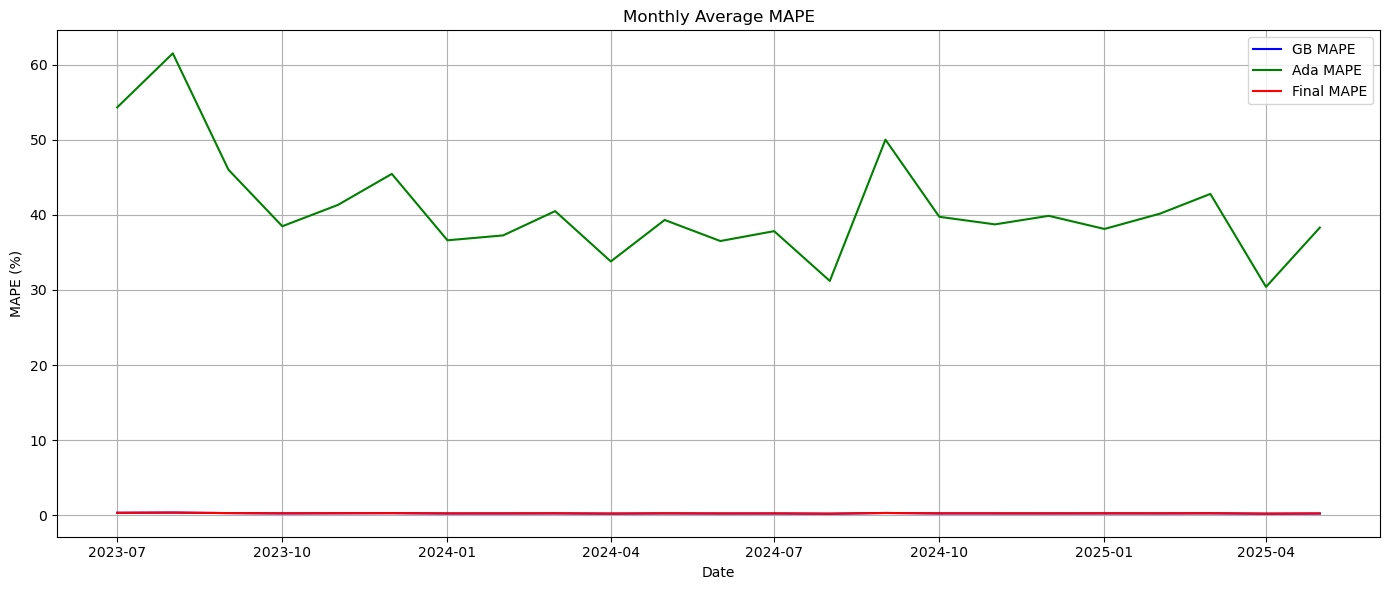

In [417]:
df_monthly = df_new.groupby('date')[['gb_mape', 'ada_mape','final_mape']].mean().reset_index()

plt.figure(figsize=(14, 6))
plt.plot(df_monthly['date'], df_monthly['gb_mape'], label='GB MAPE', color='blue')
plt.plot(df_monthly['date'], df_monthly['ada_mape'], label='Ada MAPE', color='green')
plt.plot(df_monthly['date'], df_monthly['final_mape'], label='Final MAPE', color='red')
plt.title('Monthly Average MAPE')
plt.xlabel('Date')
plt.ylabel('MAPE (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4606/425555090.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mape_by_segment = df_new.groupby('log_segment')['final_mape'].mean().reindex(segment_order)
/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4606/425555090.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_new, x='log_segment', order=segment_order, palette='viridis')


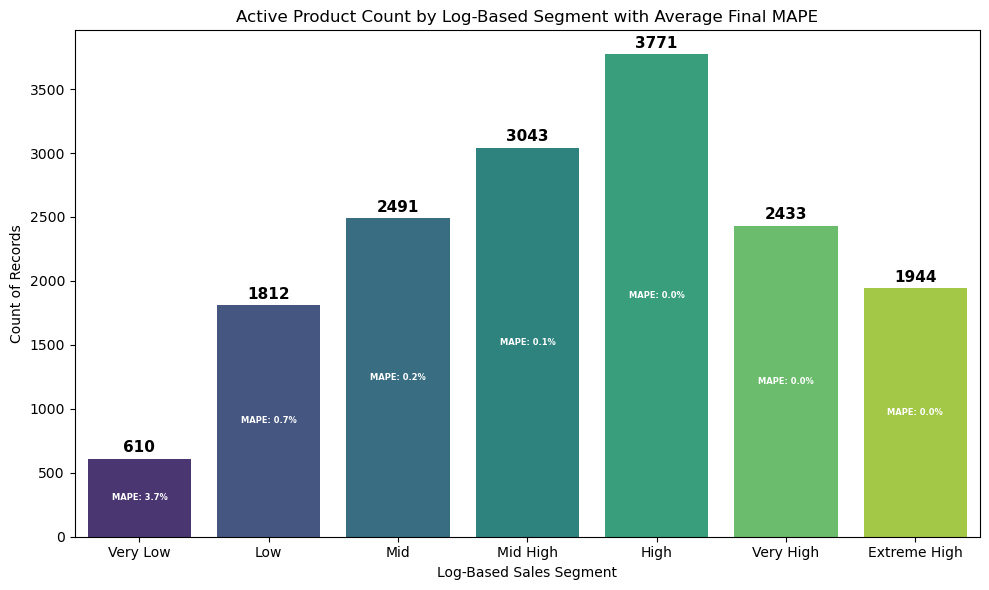

In [419]:
# Ensure 'log_segment' exists and is correctly ordered
segment_order = ['Very Low',  'Low', 'Mid', 'Mid High', 'High', 'Very High', 'Extreme High']

# Calculate average MAPE by log segment (using df_active)
mape_by_segment = df_new.groupby('log_segment')['final_mape'].mean().reindex(segment_order)

# Create the plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_new, x='log_segment', order=segment_order, palette='viridis')

# Annotate each bar with count and MAPE
for p, segment_name in zip(ax.patches, segment_order):
    height = p.get_height()
    xpos = p.get_x() + p.get_width() / 2.

    # Add count label above the bar
    ax.text(xpos, height + 50, f'{int(height)}', ha='center', fontsize=11, fontweight='bold')

    # Add MAPE label inside the bar
    mape_val = mape_by_segment.get(segment_name, np.nan)
    ax.text(xpos, height / 2, f'MAPE: {mape_val:.1f}%', ha='center', va='center',
            fontsize=6, color='white', fontweight='bold')

# Formatting
plt.title("Active Product Count by Log-Based Segment with Average Final MAPE")
plt.xlabel("Log-Based Sales Segment")
plt.ylabel("Count of Records")
plt.tight_layout()
plt.show()

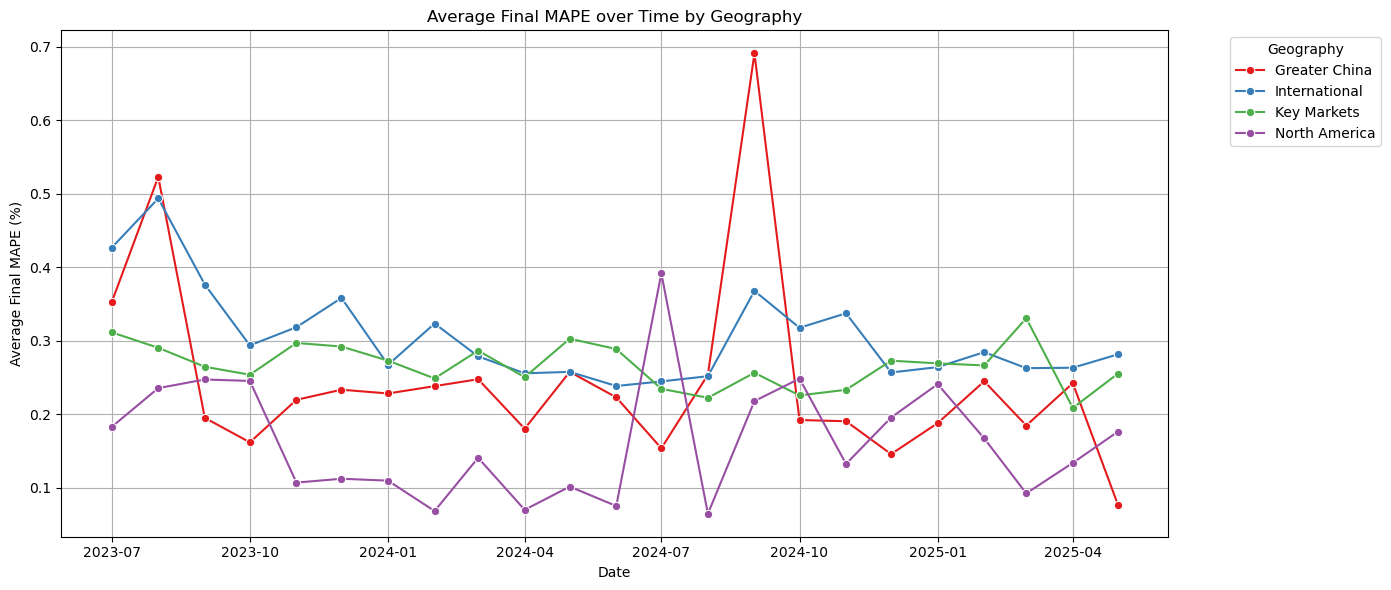

In [421]:
geo_final_mape = df_new.groupby(['geography', 'year', 'month'])['final_mape'].mean().reset_index()

# Create a datetime column for proper x-axis formatting
geo_final_mape['date'] = pd.to_datetime(geo_final_mape[['year', 'month']].assign(day=1))

plt.figure(figsize=(14, 6))
sns.lineplot(data=geo_final_mape, x='date', y='final_mape', hue='geography', marker='o', palette='Set1')

plt.title('Average Final MAPE over Time by Geography')
plt.xlabel('Date')
plt.ylabel('Average Final MAPE (%)')
plt.legend(title='Geography', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


### Explore occurrences with Mape >10% and Absolute Error >100 units

In [424]:
#Filtering Rows With High Error
filtered_df_mape_error = df_new[(df_new['final_mape'] > 10) & (df_new['final_abs_error'] > 100)]
filtered_df_mape_error


Empty DataFrame
Columns: [gmid_key, date, year, month, product_family, gmid, country, market, geography, sales, coverage_months, min, max, market_segmentation, pf_segmentation, gmid_segmentation, log_sales, log_segment, sales_lag_3, forecast_lag_3, seg_combo, gb_forecast, ada_forecast, gb_absolute_error, ada_absolute_error, gb_mape, ada_mape, final_forecast, final_abs_error, final_mape, model_used]
Index: []

[0 rows x 31 columns]

In [426]:
high_mape = df_new[(df_new['final_mape'] > 10)]
high_mape

Empty DataFrame
Columns: [gmid_key, date, year, month, product_family, gmid, country, market, geography, sales, coverage_months, min, max, market_segmentation, pf_segmentation, gmid_segmentation, log_sales, log_segment, sales_lag_3, forecast_lag_3, seg_combo, gb_forecast, ada_forecast, gb_absolute_error, ada_absolute_error, gb_mape, ada_mape, final_forecast, final_abs_error, final_mape, model_used]
Index: []

[0 rows x 31 columns]

In [428]:
high_error = df_new[(df_new['final_abs_error'] > 100)]
high_error

gmid_key       date  year  month  product_family    gmid  \
2201   120002_20254_US 2025-04-01  2025      4              12  120002   
5110  150001_202311_US 2023-11-01  2023     11              15  150001   
5112  150001_202312_US 2023-12-01  2023     12              15  150001   
5126   150001_20241_US 2024-01-01  2024      1              15  150001   
5132   150001_20244_US 2024-04-01  2024      4              15  150001   
5142   150001_20249_US 2024-09-01  2024      9              15  150001   
6387   150047_20238_US 2023-08-01  2023      8              15  150047   
6389   150047_20239_US 2023-09-01  2023      9              15  150047   
6381  150047_202311_US 2023-11-01  2023     11              15  150047   
6383  150047_202312_US 2023-12-01  2023     12              15  150047   
6405   150047_20245_US 2024-05-01  2024      5              15  150047   
6391  150047_202410_US 2024-10-01  2024     10              15  150047   
6415   150047_20251_US 2025-01-01  2025      1              15  150047   
6421   150047_20254_US 2025-04-01  2025      4              15  150047   
6636   150059_20241_CN 2024-01-01  2024      1              15  150059   
6637   150059_20242_CN 2024-02-01  2024      2              15  150059   
6640   150059_20245_CN 2024-05-01  2024      5              15  150059   
6644   150059_20249_CN 2024-09-01  2024      9              15  150059   
6634  150059_202411_CN 2024-11-01  2024     11              15  150059   
6645   150059_20251_CN 2025-01-01  2025      1              15  150059   
6646   150059_20252_CN 2025-02-01  2025      2              15  150059   
6649   150059_20255_CN 2025-05-01  2025      5              15  150059   
9051   150177_20246_JP 2024-06-01  2024      6              15  150177   
9053   150177_20248_JP 2024-08-01  2024      8              15  150177   
9044  150177_202410_JP 2024-10-01  2024     10              15  150177   
9057   150177_20253_JP 2025-03-01  2025      3              15  150177   
9058   150177_20254_JP 2025-04-01  2025      4              15  150177   
9059   150177_20255_JP 2025-05-01  2025      5              15  150177   

     country         market      geography   sales  ...    gb_forecast  \
2201      US  United States  North America   20180  ...   20040.957646   
5110      US  United States  North America  115033  ...  115163.214346   
5112      US  United States  North America   99207  ...   99454.571622   
5126      US  United States  North America  111397  ...  111865.802930   
5132      US  United States  North America  109362  ...  108181.869010   
5142      US  United States  North America  102806  ...  102534.981028   
6387      US  United States  North America  225053  ...  224898.455447   
6389      US  United States  North America  186425  ...  188198.093035   
6381      US  United States  North America  223671  ...  224447.264802   
6383      US  United States  North America  211853  ...  212927.123002   
6405      US  United States  North America  271826  ...  266599.840730   
6391      US  United States  North America  357190  ...  352166.806387   
6415      US  United States  North America  338461  ...  357583.385413   
6421      US  United States  North America  383242  ...  374347.447791   
6636      CN          China  Greater China   68329  ...   66513.666344   
6637      CN          China  Greater China   49738  ...   49923.090708   
6640      CN          China  Greater China   84850  ...   86123.393185   
6644      CN          China  Greater China   79516  ...   82616.686282   
6634      CN          China  Greater China   71931  ...   69257.961301   
6645      CN          China  Greater China  119673  ...  120305.925102   
6646      CN          China  Greater China   61731  ...   62938.810959   
6649      CN          China  Greater China  116981  ...  117885.092520   
9051      JP          Japan    Key Markets  139754  ...  138954.113735   
9053      JP          Japan    Key Markets  154216  ...  154561.580221   
9044      JP     

In [430]:
#count the number of occurrences where final_mape > 10 or final_abs_error > 100
error_count = df_new[
    (df_new['final_mape'] > 10) | (df_new['final_abs_error'] > 100)
].shape[0]

print(f"Number of rows with MAPE > 10 or Abs Error > 100: {error_count}")

Number of rows with MAPE > 10 or Abs Error > 100: 28


In [432]:
filtered_df = df_new[
    (df_new['final_mape'] > 10) | (df_new['final_abs_error'] > 100)
]

pf_counts = filtered_df['product_family'].value_counts()
print(pf_counts)


product_family
15    27
12     1
Name: count, dtype: int64


/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4606/1396014868.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['market_segmentation', 'log_segment'])['final_mape']


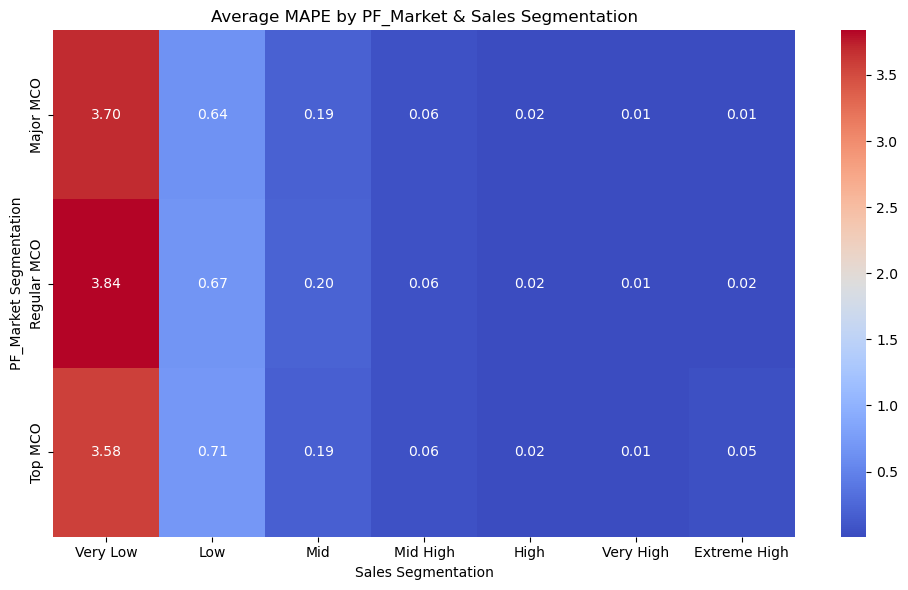

In [434]:
# Step 1: Calculate average MAPE per group
heatmap_df_new = (
    df_new
    .groupby(['market_segmentation', 'log_segment'])['final_mape']
    .mean()
    .unstack()
)

# Step 2: Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df_new, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Average MAPE by PF_Market & Sales Segmentation')
plt.xlabel('Sales Segmentation')
plt.ylabel('PF_Market Segmentation')
plt.tight_layout()
plt.show()



/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4606/2935000041.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['market_segmentation', 'log_segment'])['final_abs_error']


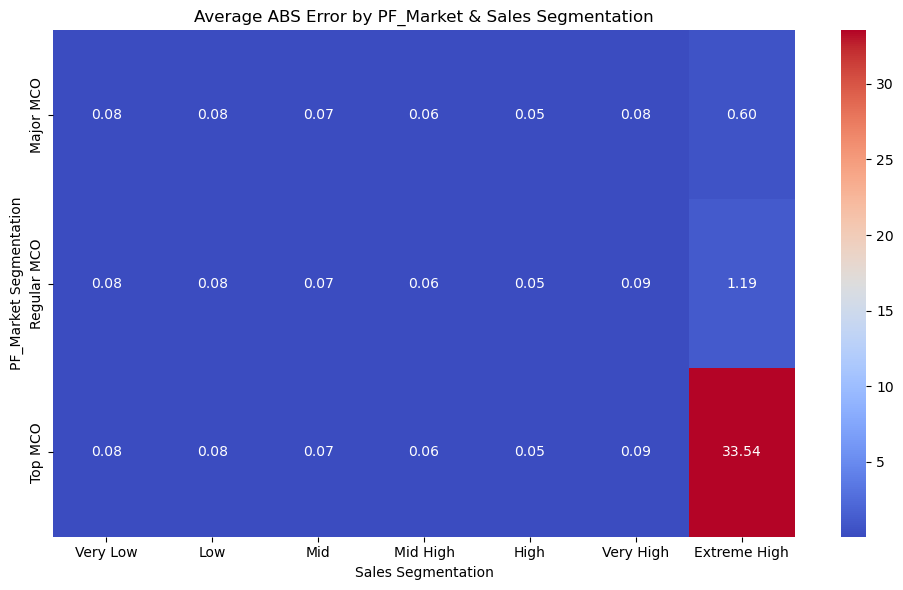

In [436]:
# Step 1: Calculate average MAPE per group
heatmap_df_new = (
    df_new
    .groupby(['market_segmentation', 'log_segment'])['final_abs_error']
    .mean()
    .unstack()
)

# Step 2: Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df_new, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Average ABS Error by PF_Market & Sales Segmentation')
plt.xlabel('Sales Segmentation')
plt.ylabel('PF_Market Segmentation')
plt.tight_layout()
plt.show()


### Segment-Specific Modeling 

In [440]:
#new DataFrame
df_mseg = df_new.copy()
df_mseg.columns

Index(['gmid_key', 'date', 'year', 'month', 'product_family', 'gmid',
       'country', 'market', 'geography', 'sales', 'coverage_months', 'min',
       'max', 'market_segmentation', 'pf_segmentation', 'gmid_segmentation',
       'log_sales', 'log_segment', 'sales_lag_3', 'forecast_lag_3',
       'seg_combo', 'gb_forecast', 'ada_forecast', 'gb_absolute_error',
       'ada_absolute_error', 'gb_mape', 'ada_mape', 'final_forecast',
       'final_abs_error', 'final_mape', 'model_used'],
      dtype='object')

In [442]:
#Create Segmentation Buckets - two dimensions into a unified segment identifier
df_mseg['model_segment'] = df_mseg['market_segmentation'].astype(str) + '_' + df_mseg['log_segment'].astype(str)

columns_to_drop = ['gmid_segmentation','log_segment','ada_forecast', 'gb_absolute_error', 'ada_absolute_error', 'gb_mape', 'ada_mape']
df_mseg = df_mseg.drop(columns=columns_to_drop)
df_mseg.head()


gmid_key       date  year  month  product_family    gmid country  \
6   100001_20237_AU 2023-07-01  2023      7               1  100001      AU   
7   100001_20237_NZ 2023-07-01  2023      7               1  100001      NZ   
8   100001_20238_AU 2023-08-01  2023      8               1  100001      AU   
9   100001_20238_NZ 2023-08-01  2023      8               1  100001      NZ   
10  100001_20239_AU 2023-09-01  2023      9               1  100001      AU   

         market      geography  sales  ...  log_sales  sales_lag_3  \
6     Australia  International     75  ...   4.330733          0.0   
7   New Zealand  International     29  ...   3.401197          0.0   
8     Australia  International     66  ...   4.204693          0.0   
9   New Zealand  International     26  ...   3.295837         75.0   
10    Australia  International     48  ...   3.891820         29.0   

    forecast_lag_3           seg_combo gb_forecast  final_forecast  \
6              0.0  Secure_Regular MCO   75.067275       75.067275   
7              0.0  Secure_Regular MCO   29.076450       29.076450   
8              0.0  Secure_Regular MCO   66.069491       66.069491   
9            102.0  Secure_Regular MCO   26.077073       26.077073   
10            36.0  Secure_Regular MCO   48.073583       48.073583   

    final_abs_error  final_mape         model_used         model_segment  
6          0.067275    0.089699  Gradient Boosting  Regular MCO_Mid High  
7          0.076450    0.263619  Gradient Boosting       Regular MCO_Mid  
8          0.069491    0.105290  Gradient Boosting  Regular MCO_Mid High  
9          0.077073    0.296434  Gradient Boosting       Regular MCO_Mid  
10         0.073583    0.153298  Gradient Boosting       Regular MCO_Mid  

[5 rows x 25 columns]

In [444]:
#Define the Models
model_dict = {
    'Linear': LinearRegression(),
    'KNN': KNeighborsRegressor(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'Bagging': BaggingRegressor(random_state=42)
}


In [446]:
# Set training parameters
threshold = 44
features = ['sales_lag_3', 'forecast_lag_3', 'log_sales', 'pf_segmentation', 'market_segmentation']
target = 'sales'

In [448]:
#Split Data by Model Segment
segment_groups = df_mseg.groupby('model_segment')


Evaluating segment: Major MCO_Extreme High | Rows: 107


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

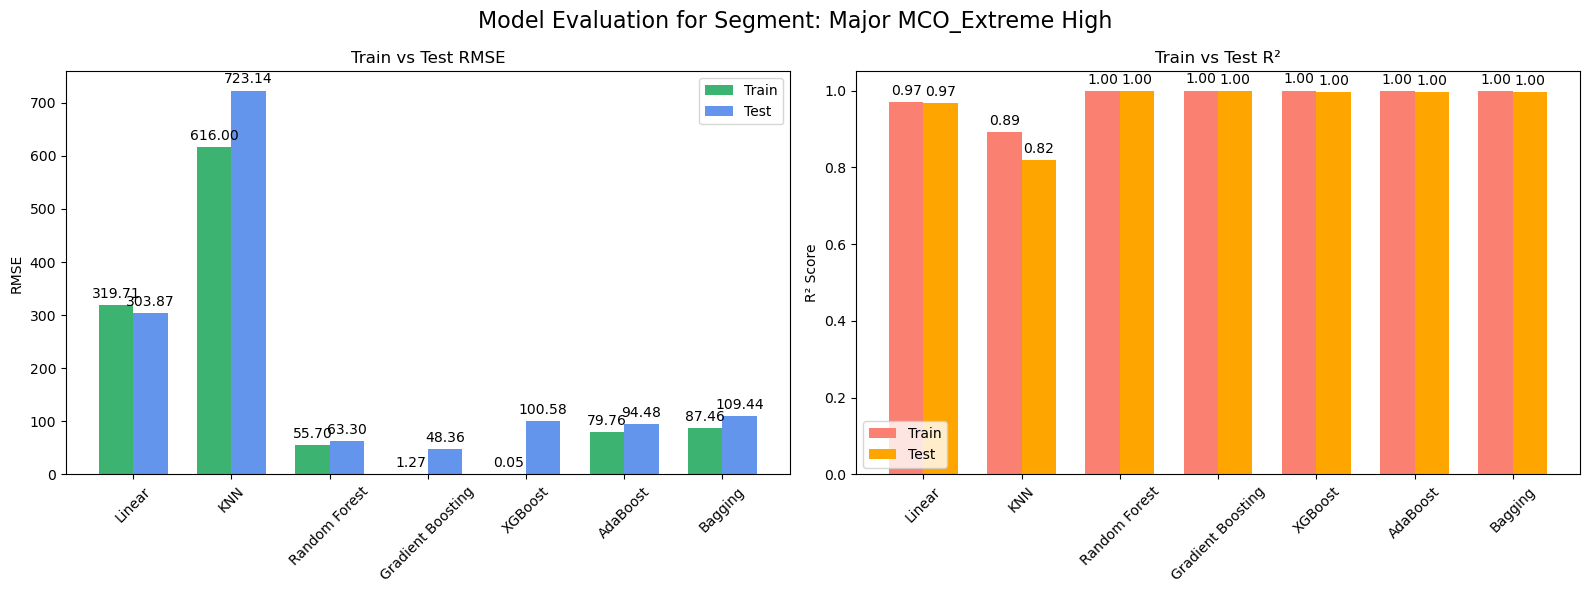


Evaluating segment: Major MCO_High | Rows: 399


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

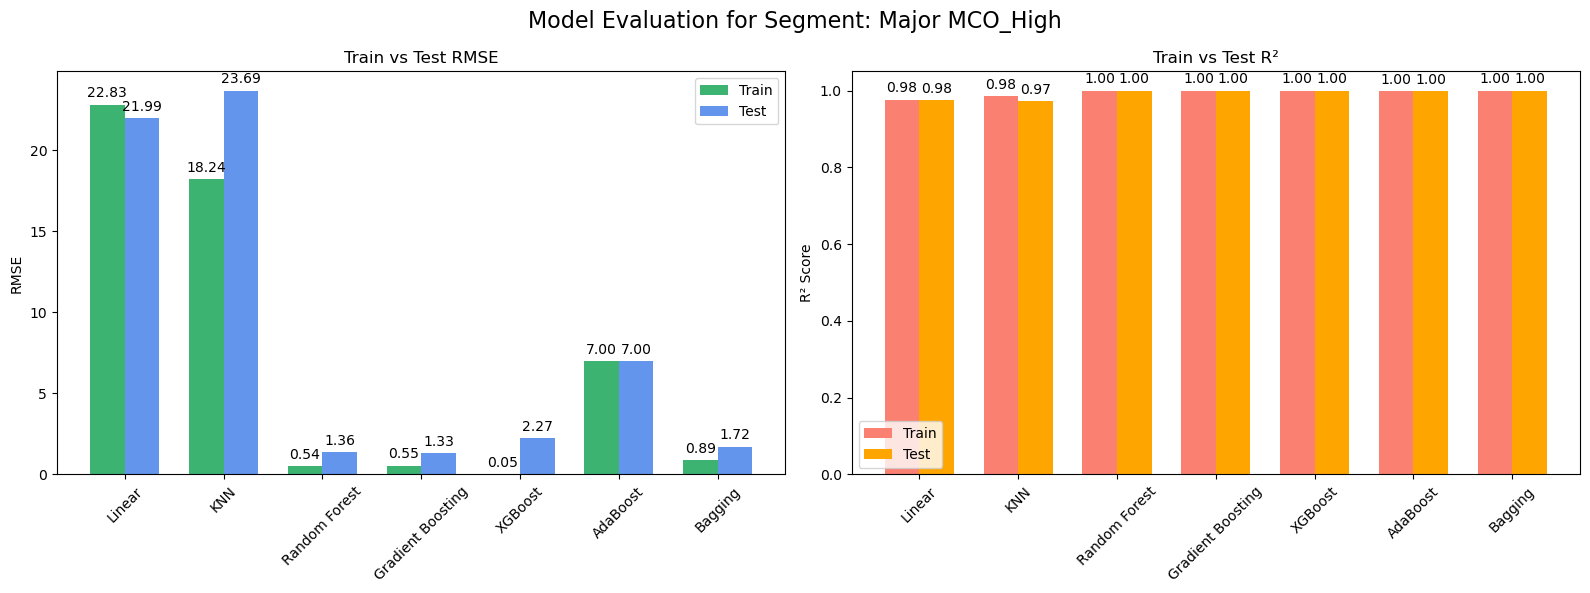


Evaluating segment: Major MCO_Low | Rows: 225


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

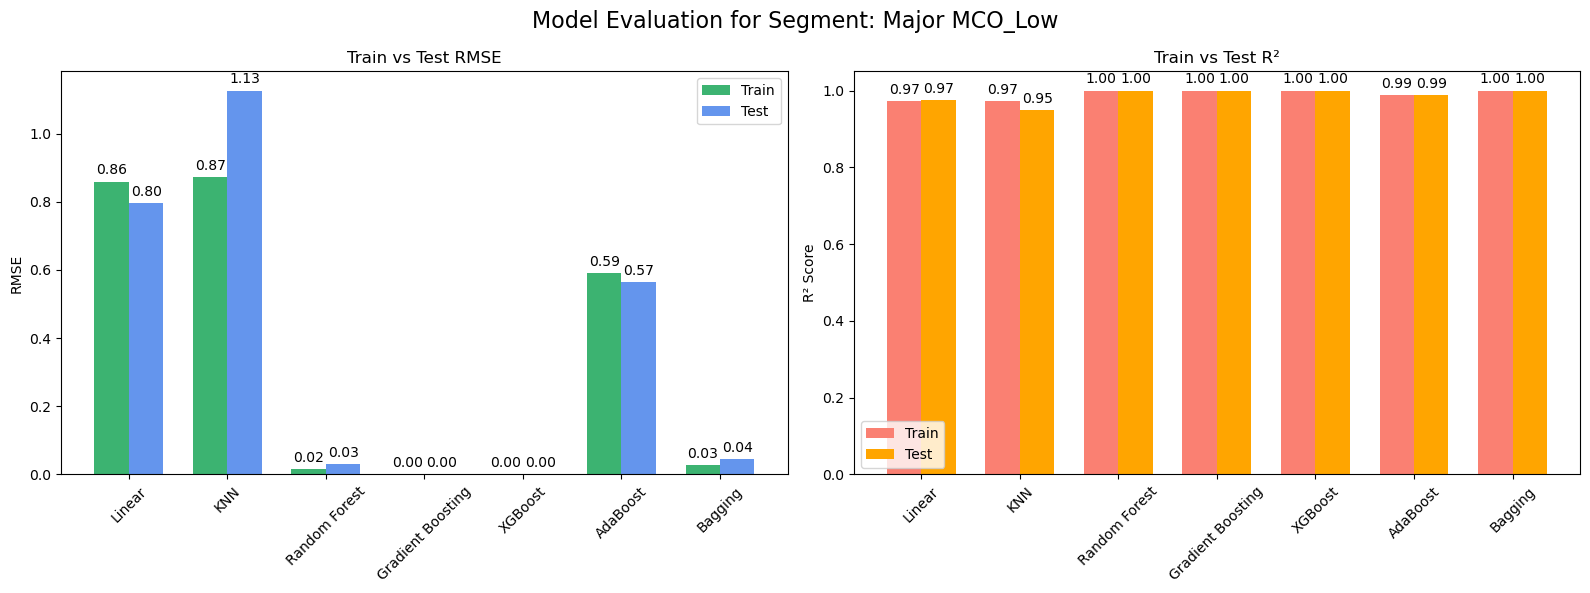


Evaluating segment: Major MCO_Mid | Rows: 299


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

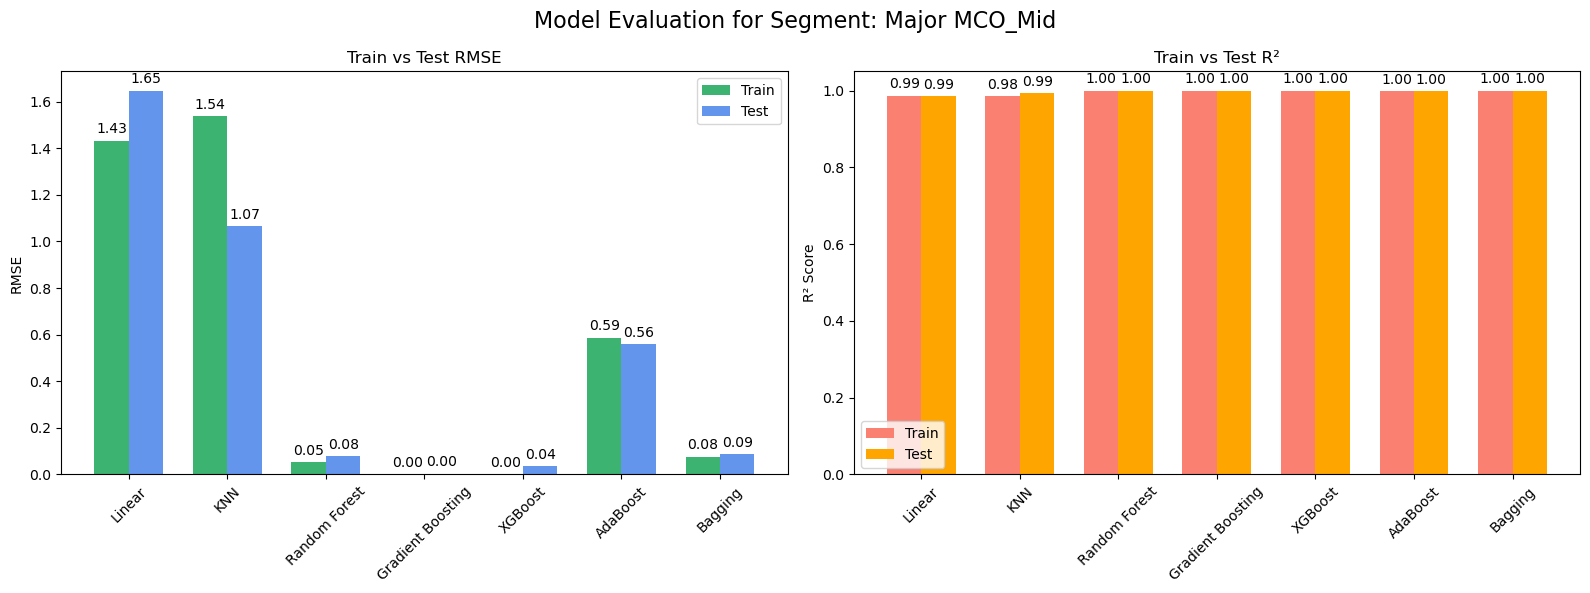


Evaluating segment: Major MCO_Mid High | Rows: 401


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

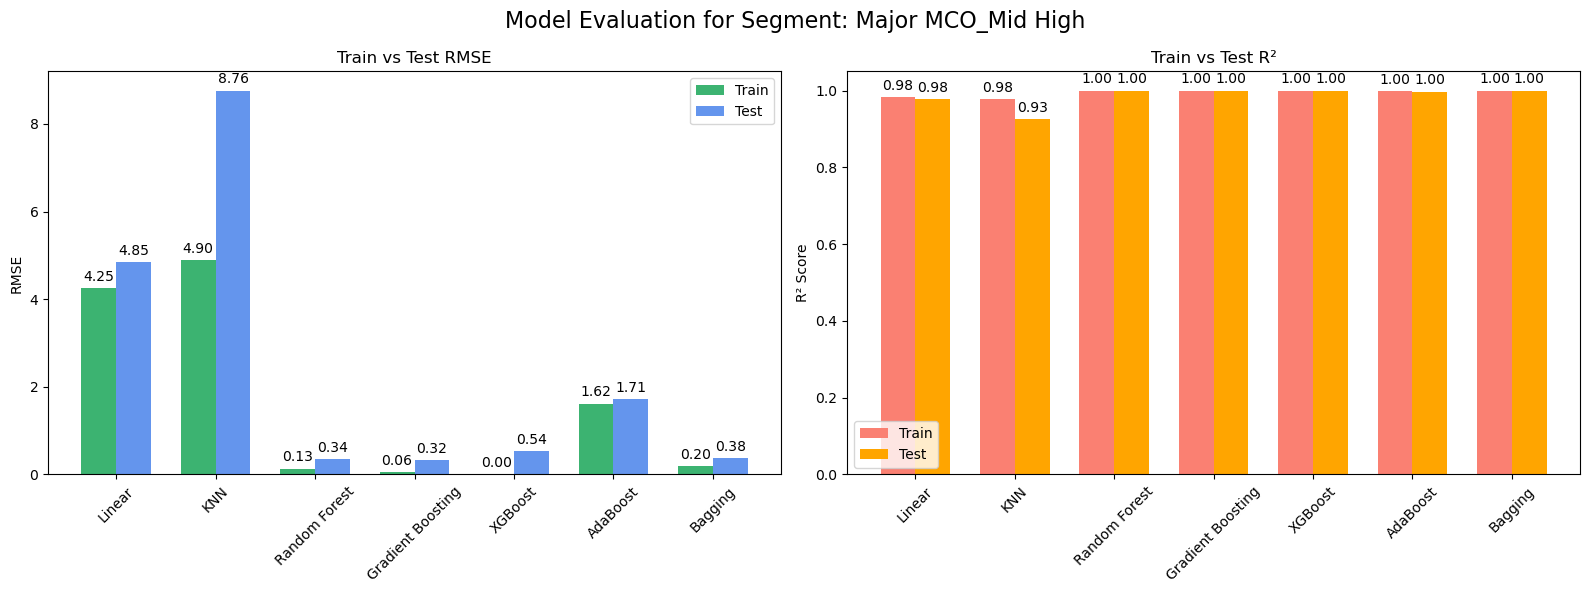


Evaluating segment: Major MCO_Very High | Rows: 232


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

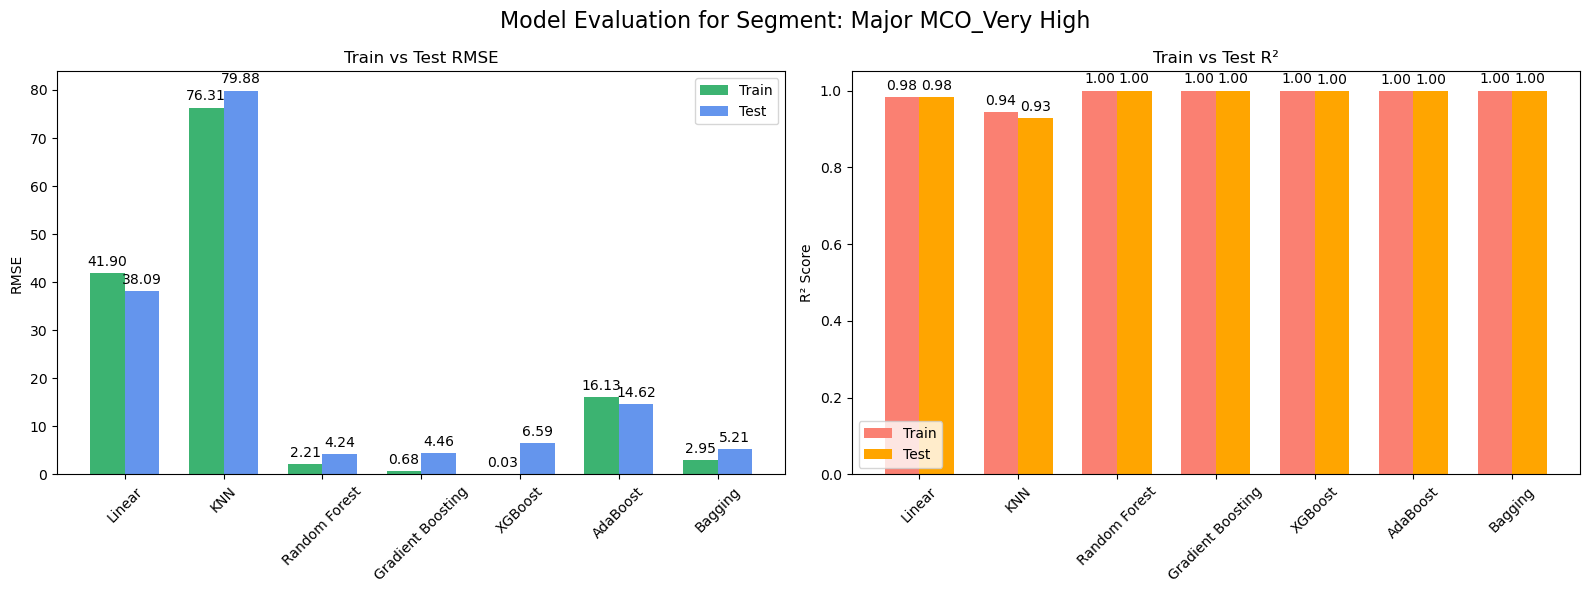

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 


Evaluating segment: Major MCO_Very Low | Rows: 45


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

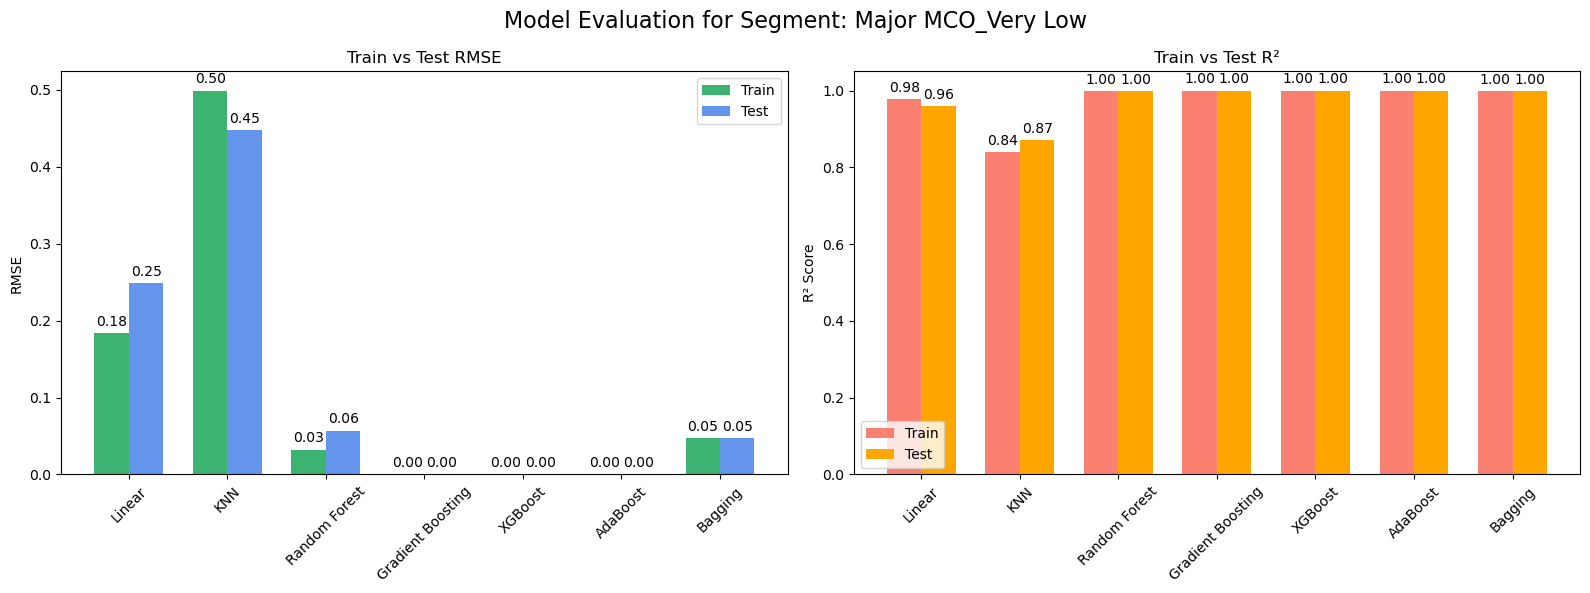


Evaluating segment: Regular MCO_Extreme High | Rows: 476


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

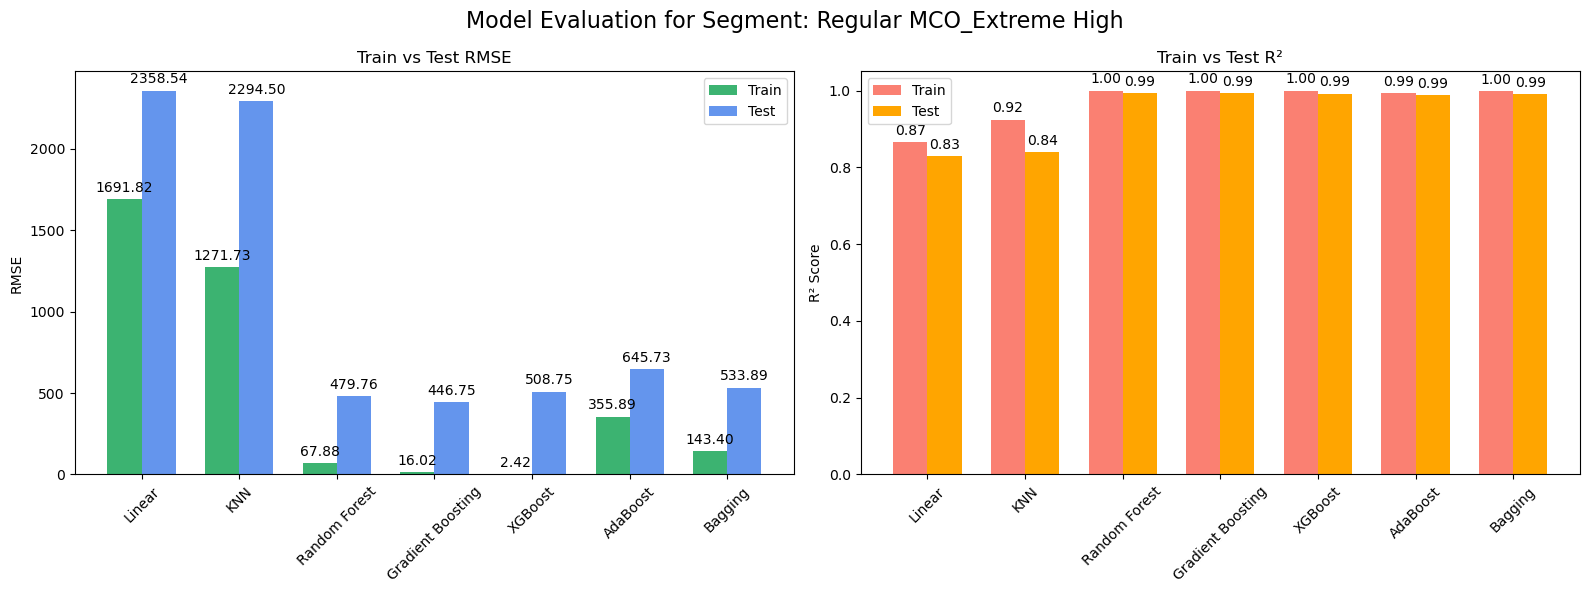


Evaluating segment: Regular MCO_High | Rows: 1425


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

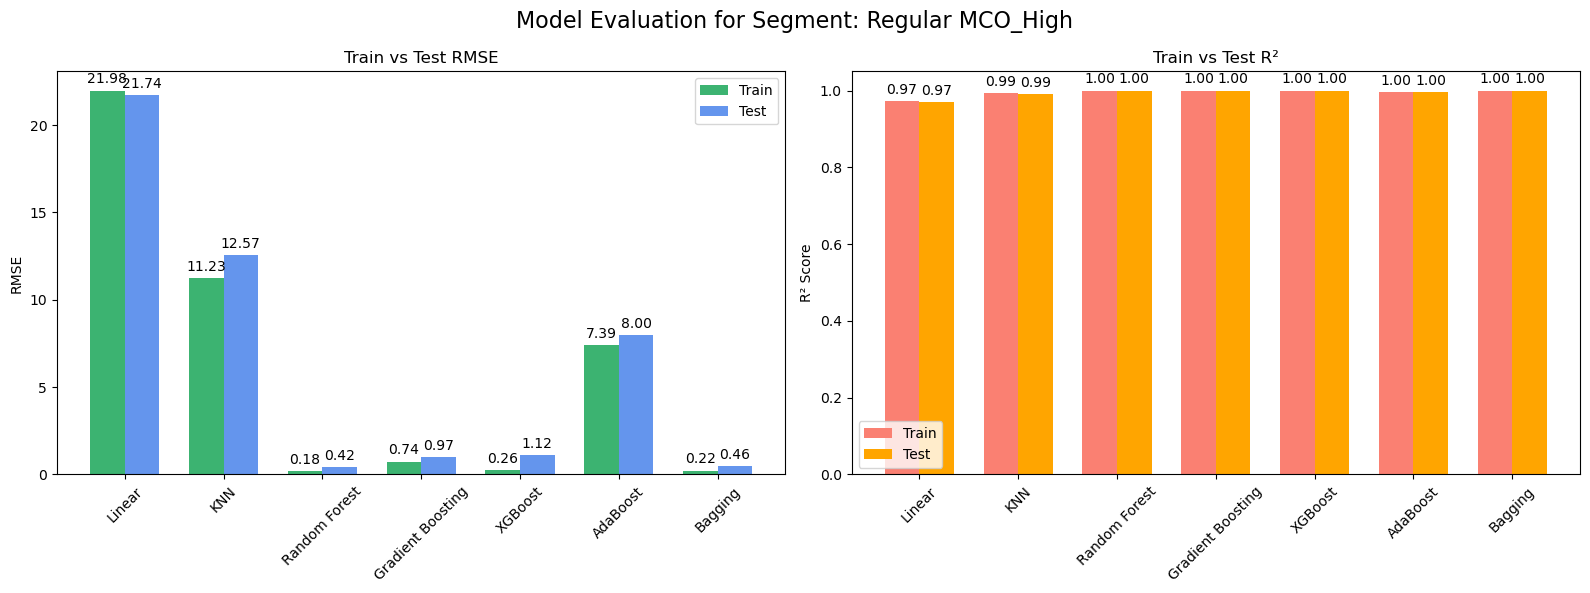

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 


Evaluating segment: Regular MCO_Low | Rows: 701


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

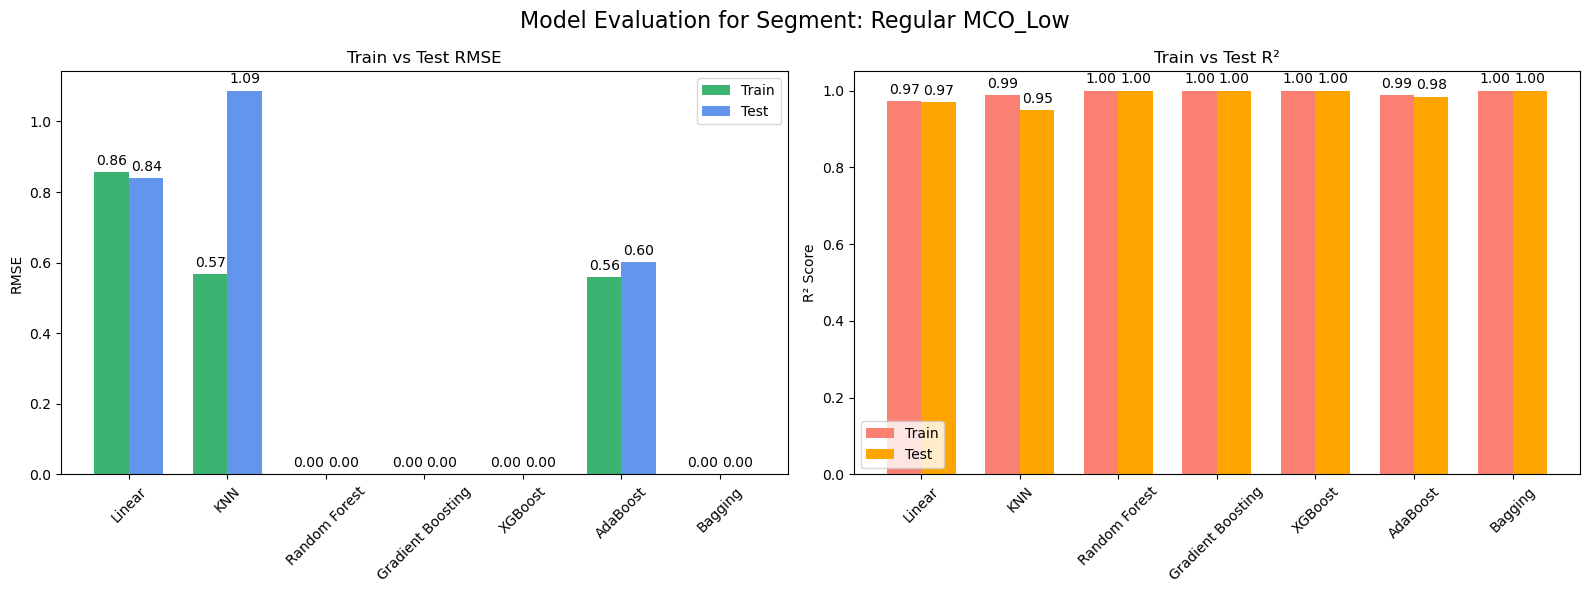


Evaluating segment: Regular MCO_Mid | Rows: 881


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

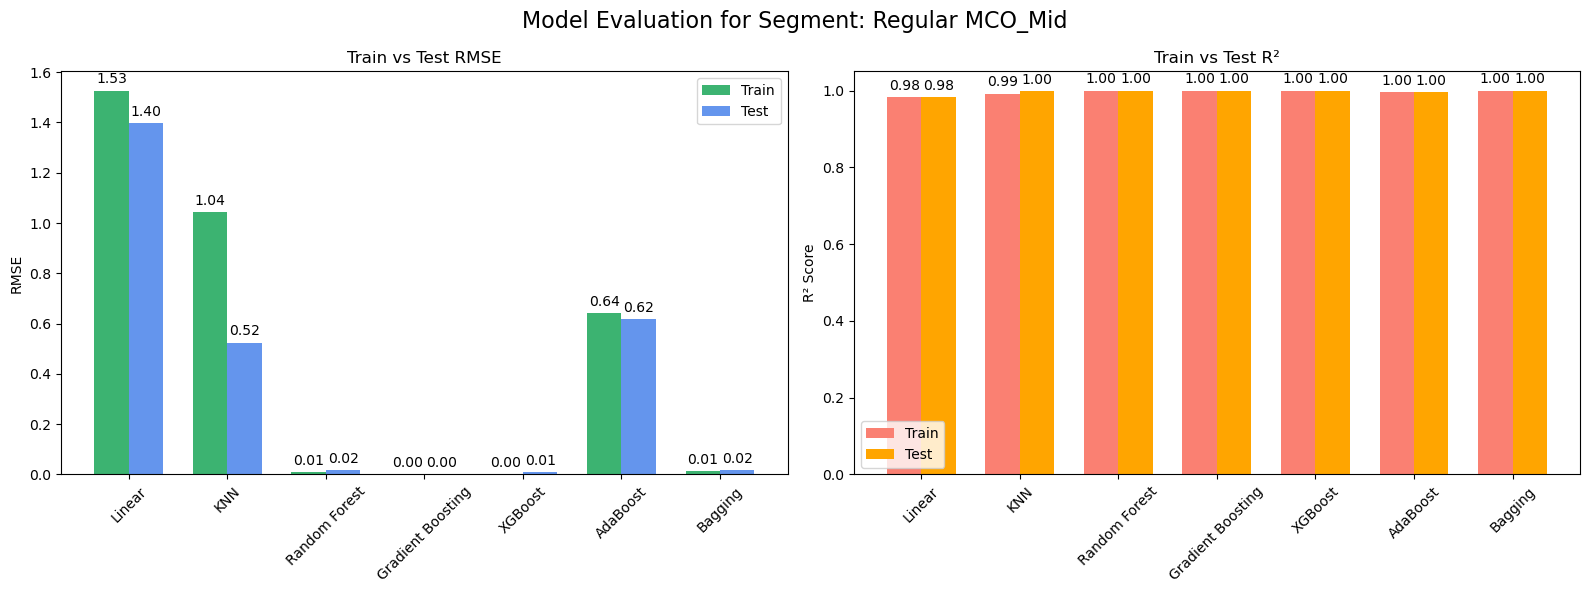


Evaluating segment: Regular MCO_Mid High | Rows: 955


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

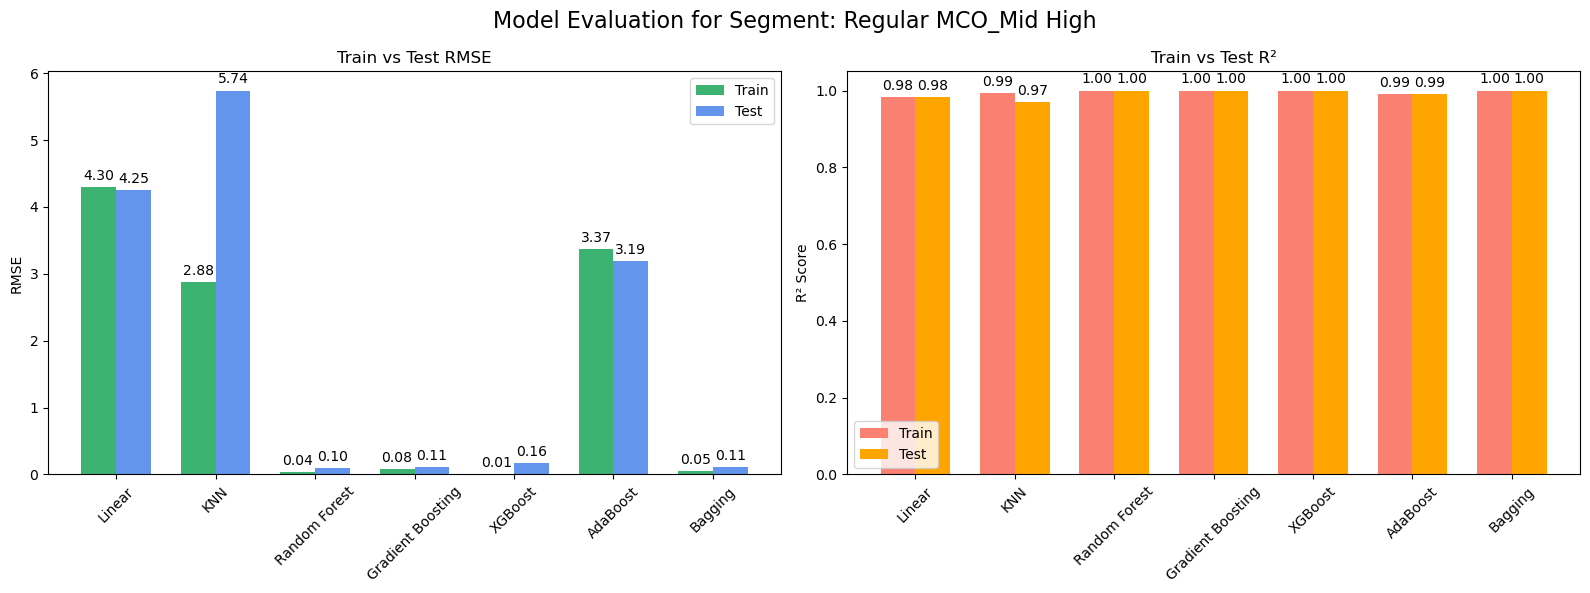

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 


Evaluating segment: Regular MCO_Very High | Rows: 655


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

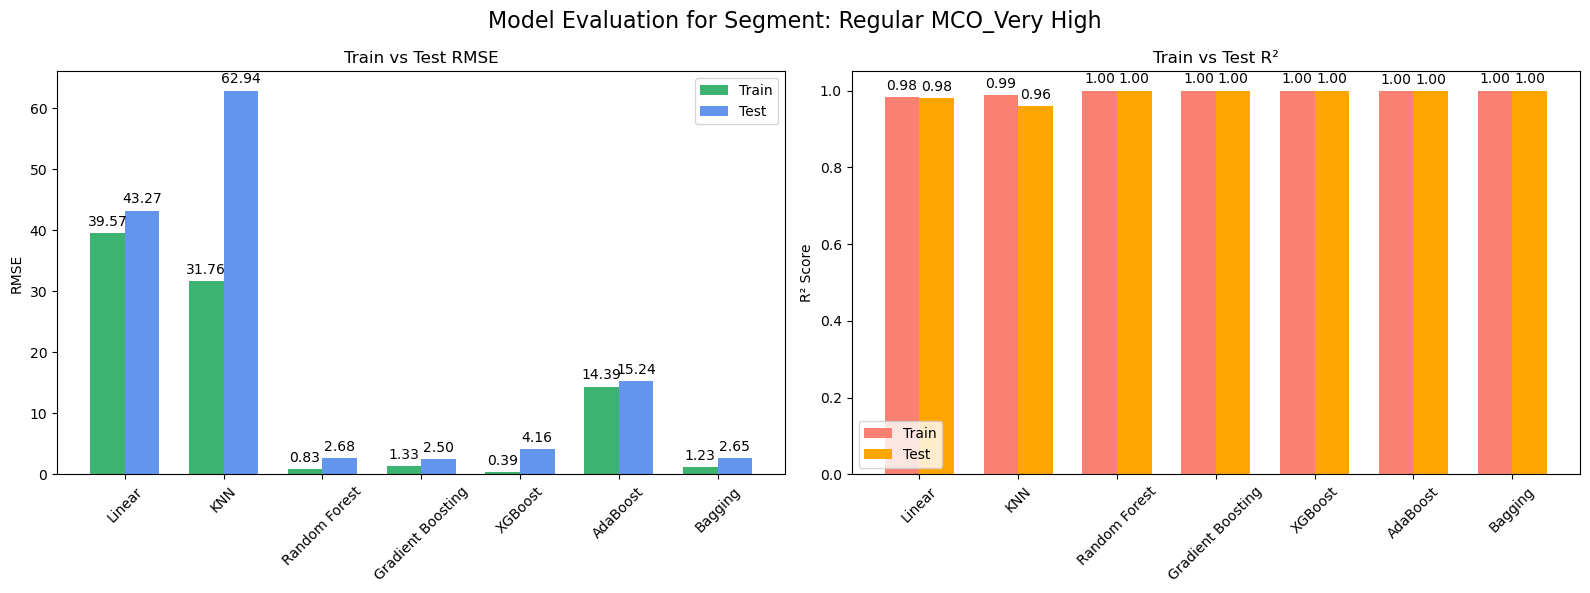

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 


Evaluating segment: Regular MCO_Very Low | Rows: 222


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

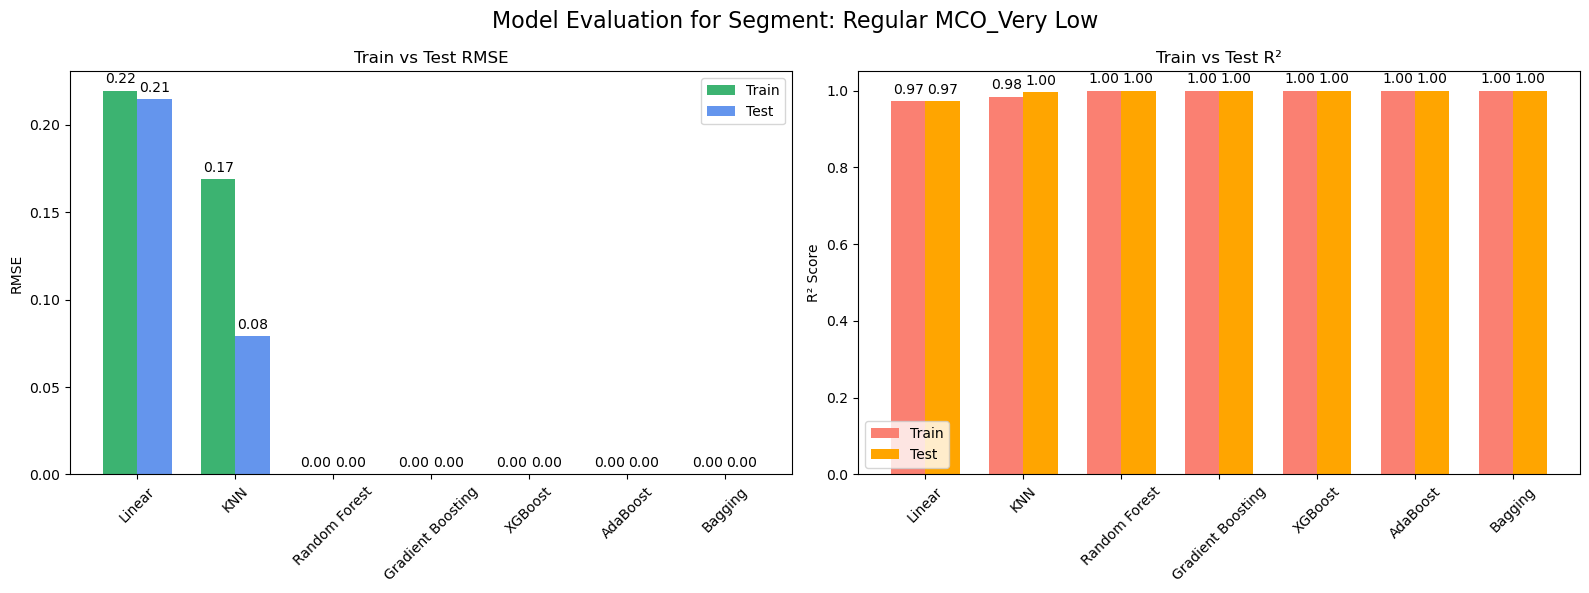

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 


Evaluating segment: Top MCO_Extreme High | Rows: 1361


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

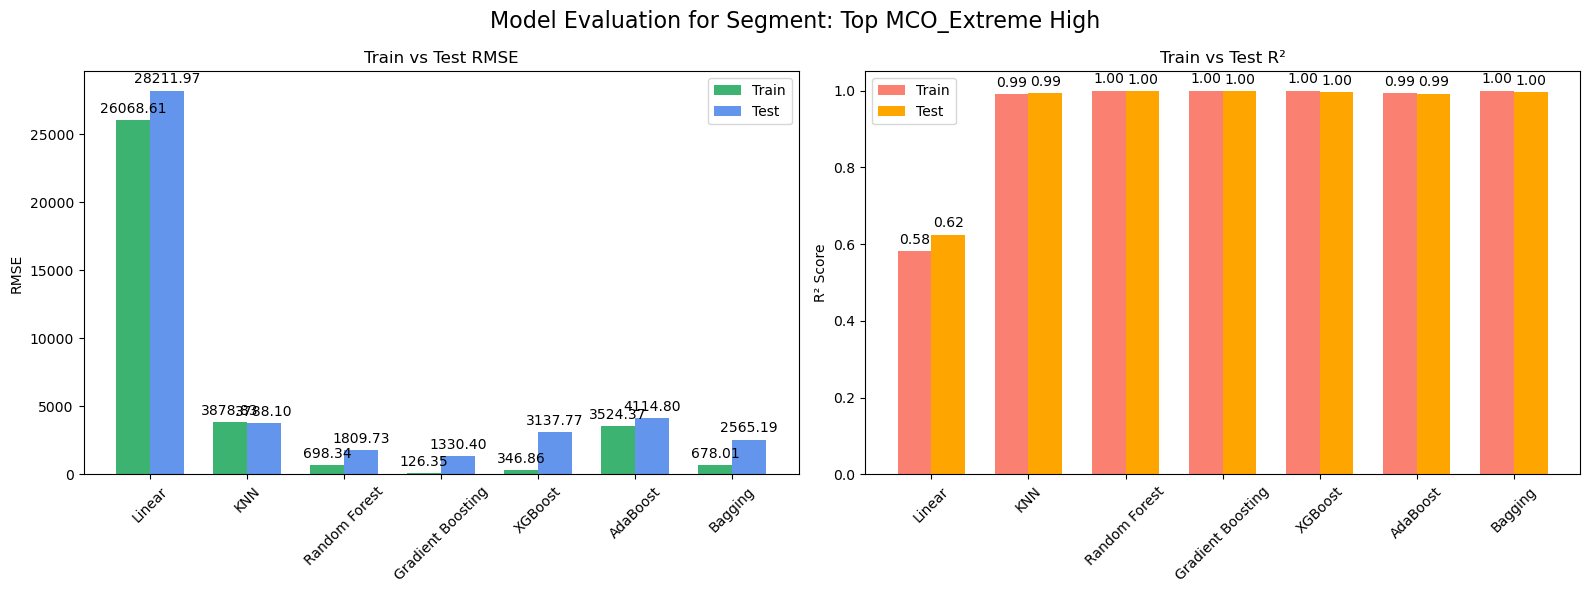


Evaluating segment: Top MCO_High | Rows: 1947


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

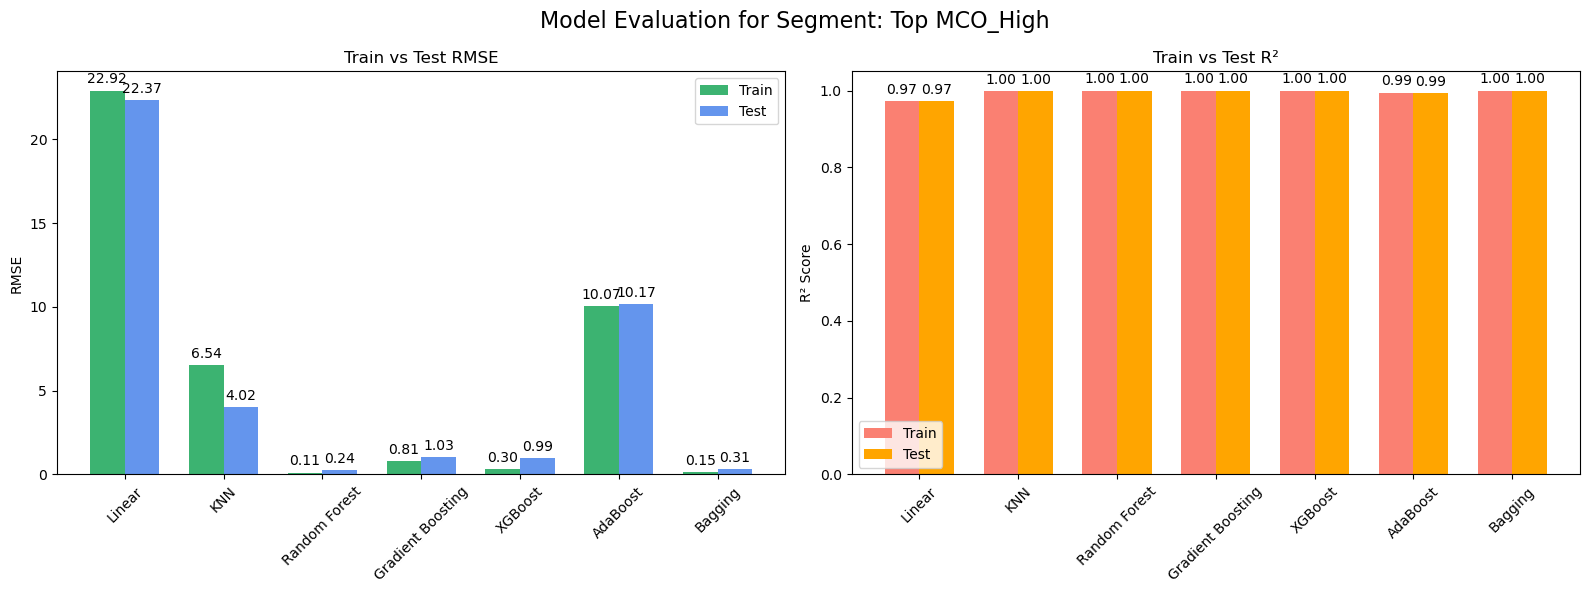


Evaluating segment: Top MCO_Low | Rows: 886


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

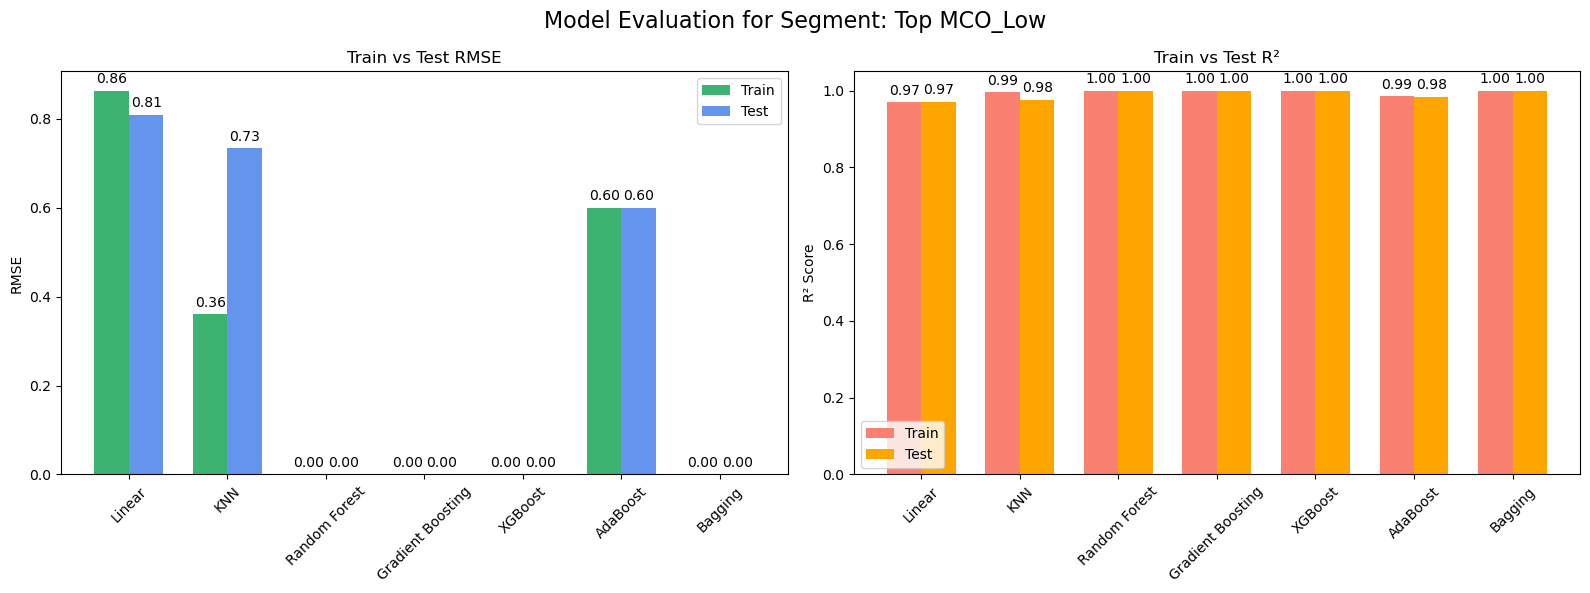


Evaluating segment: Top MCO_Mid | Rows: 1311


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

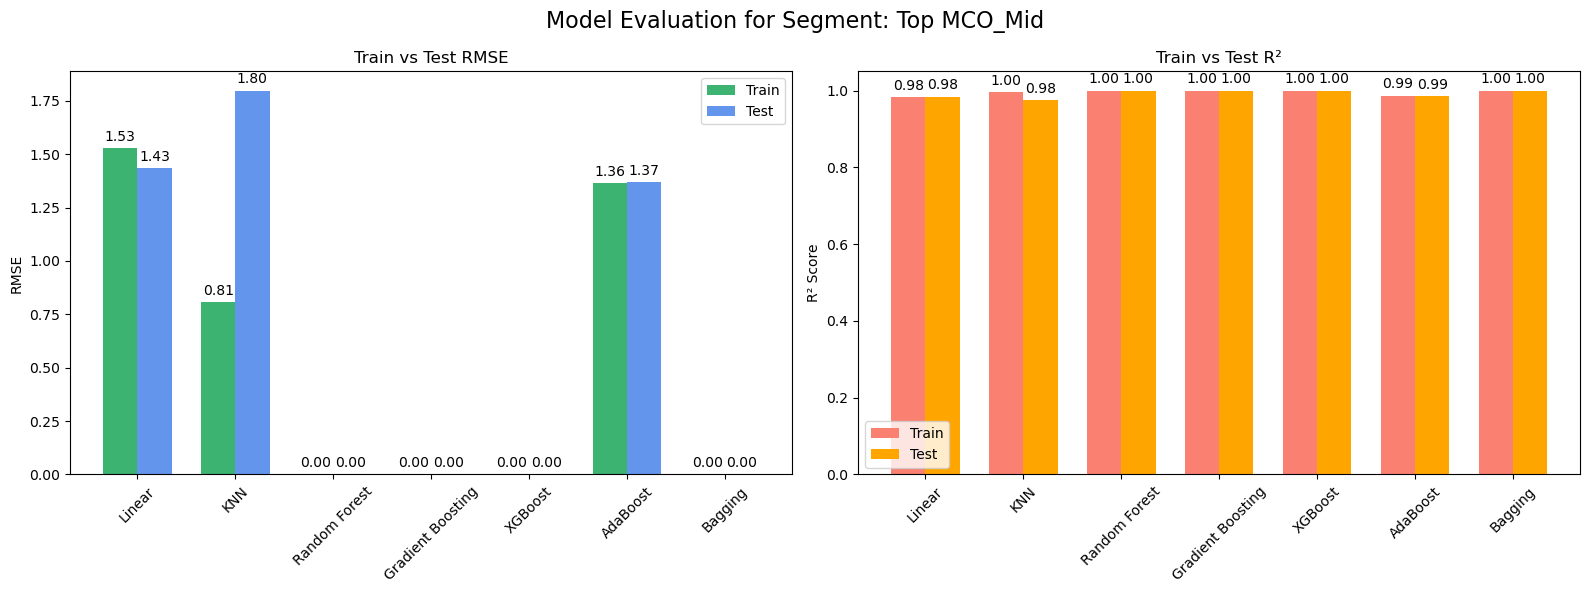


Evaluating segment: Top MCO_Mid High | Rows: 1687


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

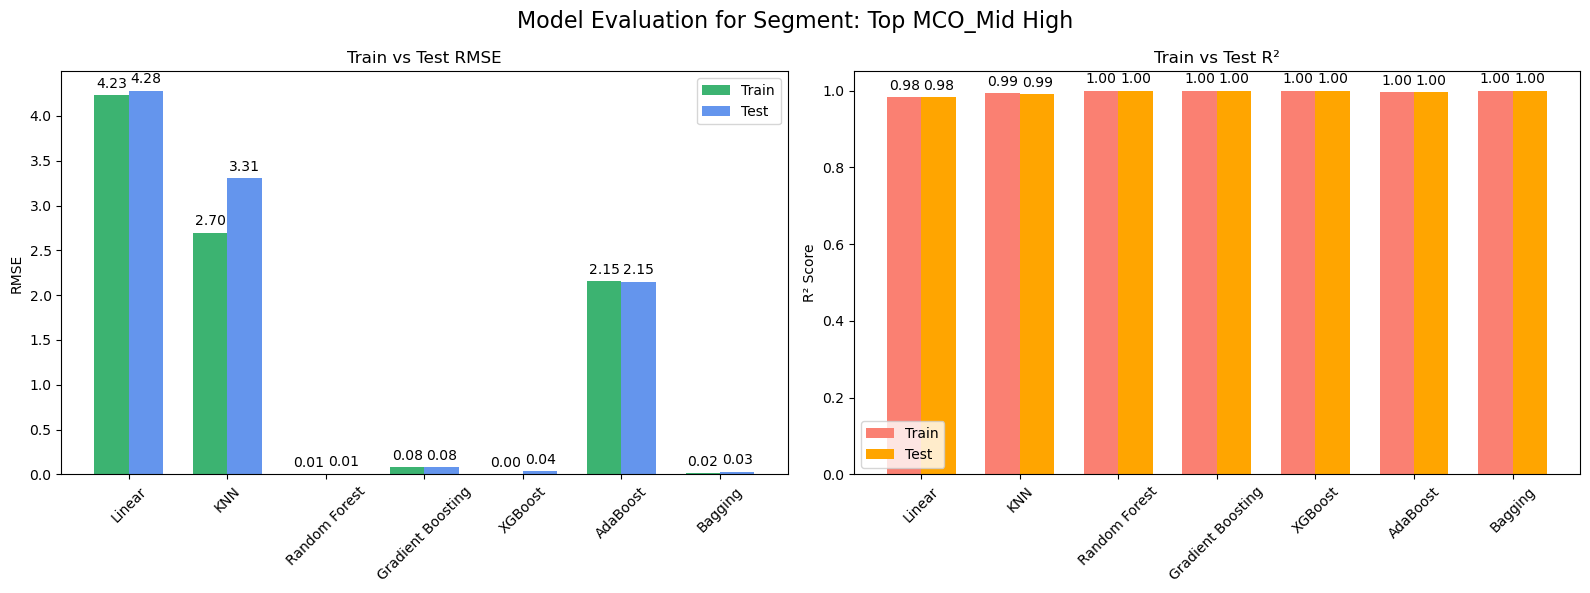


Evaluating segment: Top MCO_Very High | Rows: 1546


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

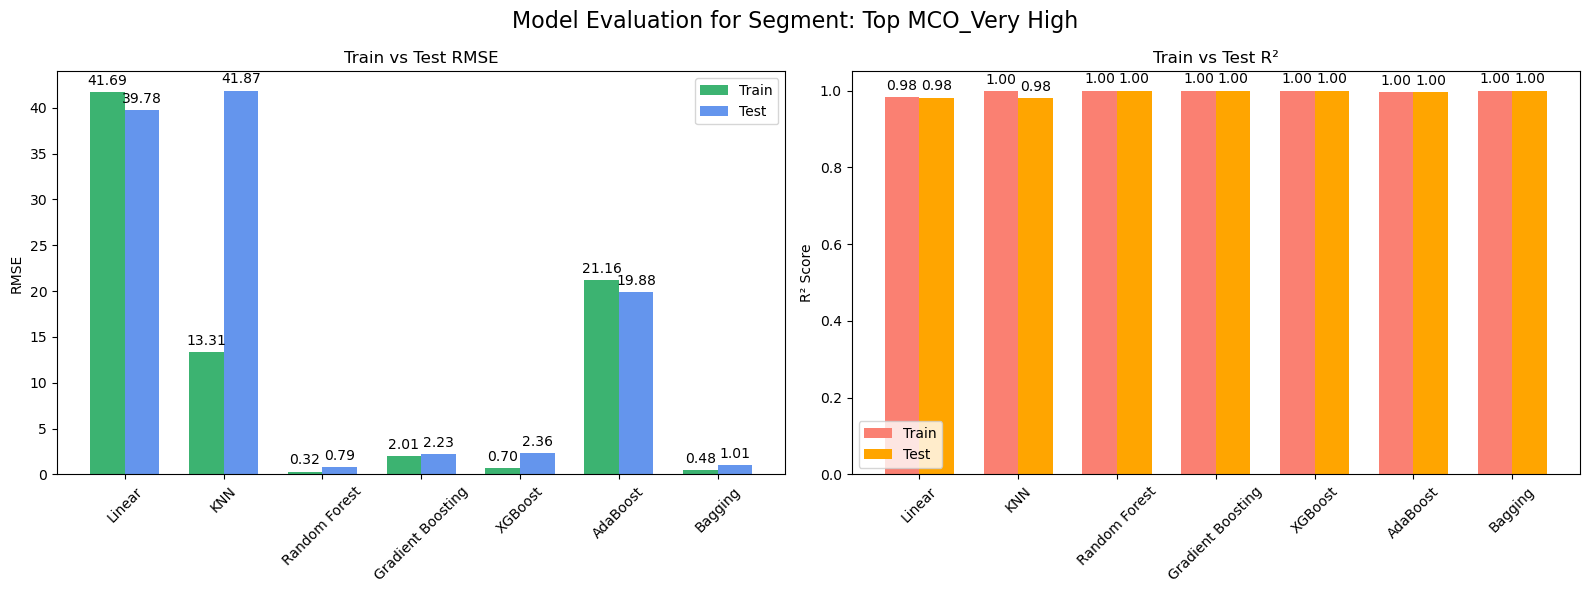


Evaluating segment: Top MCO_Very Low | Rows: 343


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

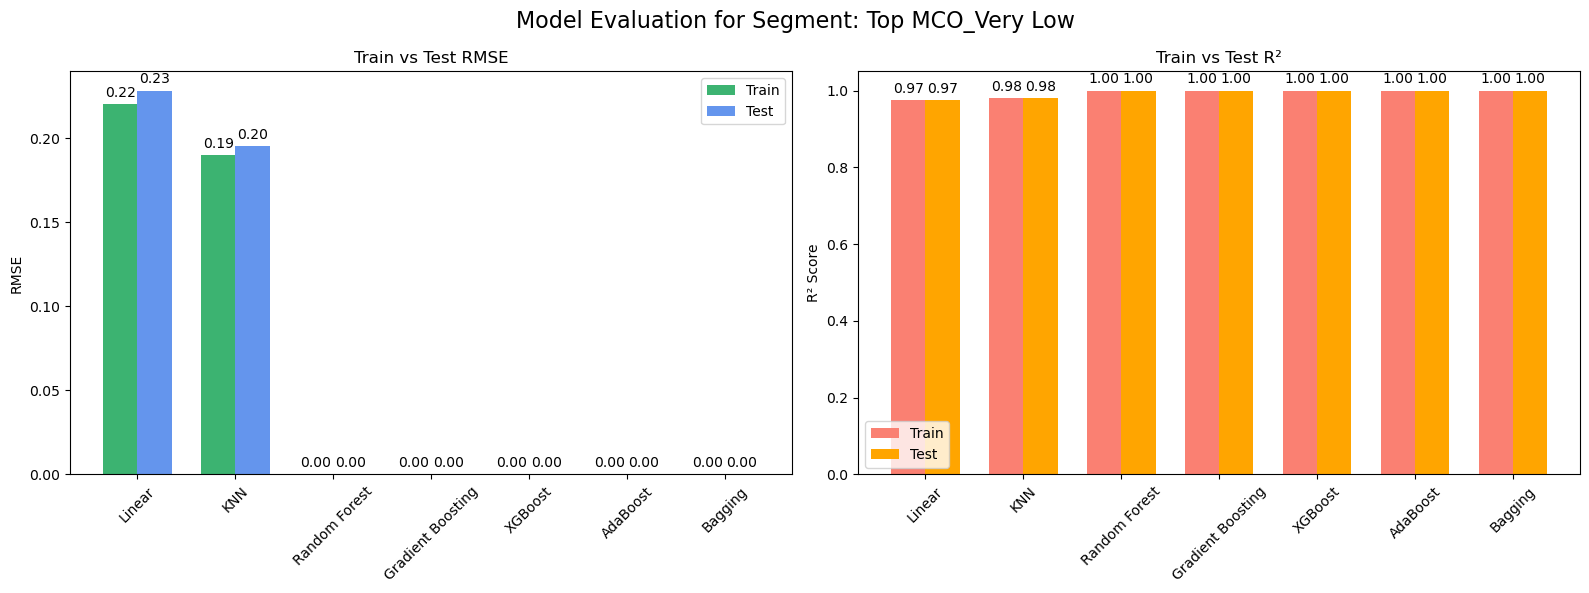

In [450]:
#Initialize tracking dictionaries before segment loop
segment_model_summary = {}
all_metrics_by_segment = {}



for segment, data in segment_groups:
    if len(data) > threshold:
        print(f"\nEvaluating segment: {segment} | Rows: {len(data)}")
        
        #Prepare Data
        X_seg = pd.get_dummies(data[features], drop_first=True)
        y_seg = data[target]

        X_seg_train, X_seg_test, y_seg_train, y_seg_test = train_test_split(
            X_seg, y_seg, test_size=0.2, random_state=42)

        if any(len(arr) == 0 for arr in [X_seg_train, X_seg_test, y_seg_train, y_seg_test]):
            print("⚠️ Skipped due to insufficient split data.")
            continue

        scaler = StandardScaler()
        X_seg_train_scaled = scaler.fit_transform(X_seg_train)
        X_seg_test_scaled = scaler.transform(X_seg_test)

        #Initialize Metrics
        rmse_seg_train, rmse_seg_test = [], []
        r2_seg_train, r2_seg_test = [], []

        #Train and Evaluate All Models
        for name, model in model_dict.items():
            model.fit(X_seg_train_scaled, y_seg_train)
            y_train_pred = model.predict(X_seg_train_scaled)
            y_test_pred = model.predict(X_seg_test_scaled)

            rmse_seg_train.append(mean_squared_error(y_seg_train, y_train_pred, squared=False))
            rmse_seg_test.append(mean_squared_error(y_seg_test, y_test_pred, squared=False))
            r2_seg_train.append(r2_score(y_seg_train, y_train_pred))
            r2_seg_test.append(r2_score(y_seg_test, y_test_pred))

        #Collect Full Metrics Per Model
        all_metrics_by_segment[segment] = {
            name: {
                'train_rmse': rmse_seg_train[i],
                'test_rmse': rmse_seg_test[i],
                'train_r2': r2_seg_train[i],
                'test_r2': r2_seg_test[i]
            }
            for i, name in enumerate(model_dict.keys())
        }

        # 🥇 Select Best Model by Test RMSE
        best_model_name, best_scores = min(
            all_metrics_by_segment[segment].items(),
            key=lambda item: item[1]['test_rmse']
        )

        segment_model_summary[segment] = {
            'best_model': best_model_name,
            'train_rmse': best_scores['train_rmse'],
            'test_rmse': best_scores['test_rmse'],
            'train_r2': best_scores['train_r2'],
            'test_r2': best_scores['test_r2']
        }
        

        #Metric sanity check
        metric_lists = [rmse_seg_train, rmse_seg_test, r2_seg_train, r2_seg_test]
        expected_len = len(model_dict)

        if any(len(lst) != expected_len for lst in metric_lists):
            print(f"⚠️ Skipping chart for segment {segment}: metric list length mismatch.")
            continue
        
        #Chart setup
        x = np.arange(expected_len)
        width = 0.35
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f'Model Evaluation for Segment: {segment}', fontsize=16)

        # RMSE chart
        rects1 = ax1.bar(x - width/2, rmse_seg_train, width, label='Train', color='mediumseagreen')
        rects2 = ax1.bar(x + width/2, rmse_seg_test, width, label='Test', color='cornflowerblue')
        ax1.set_ylabel('RMSE')
        ax1.set_title('Train vs Test RMSE')
        ax1.set_xticks(x)
        ax1.set_xticklabels(model_dict.keys(), rotation=45)
        ax1.legend()

        # R² chart
        rects3 = ax2.bar(x - width/2, r2_seg_train, width, label='Train', color='salmon')
        rects4 = ax2.bar(x + width/2, r2_seg_test, width, label='Test', color='orange')
        ax2.set_ylabel('R² Score')
        ax2.set_title('Train vs Test R²')
        ax2.set_xticks(x)
        ax2.set_xticklabels(model_dict.keys(), rotation=45)
        ax2.legend()

        #Annotate bars
        def annotate_bars(ax, rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width()/2, height),
                            xytext=(0, 3), textcoords="offset points",
                            ha='center', va='bottom')

        annotate_bars(ax1, rects1); annotate_bars(ax1, rects2)
        annotate_bars(ax2, rects3); annotate_bars(ax2, rects4)

        plt.tight_layout()
        plt.show()



In [451]:
segment_model_summary = {}

for segment, model_scores in all_metrics_by_segment.items():
    # Select model with minimum test RMSE
    best_model = min(model_scores.items(), key=lambda x: x[1]['test_rmse'])
    
    segment_model_summary[segment] = {
        'best_model': best_model[0],
        'train_rmse': best_model[1]['train_rmse'],
        'test_rmse': best_model[1]['test_rmse'],
        'train_r2': best_model[1]['train_r2'],
        'test_r2': best_model[1]['test_r2']
    }

# Convert to DataFrame
summary_df = pd.DataFrame.from_dict(segment_model_summary, orient='index')
summary_df.index.name = 'Segment'
summary_df = summary_df[['best_model', 'train_rmse', 'test_rmse', 'train_r2', 'test_r2']]
summary_df.sort_values('Segment')



best_model  train_rmse    test_rmse  \
Segment                                                                
Major MCO_Extreme High    Gradient Boosting    1.267510    48.355359   
Major MCO_High            Gradient Boosting    0.551597     1.332121   
Major MCO_Low                       XGBoost    0.000092     0.000067   
Major MCO_Mid             Gradient Boosting    0.002643     0.003490   
Major MCO_Mid High        Gradient Boosting    0.060298     0.321245   
Major MCO_Very High           Random Forest    2.206568     4.235180   
Major MCO_Very Low                 AdaBoost    0.000000     0.000000   
Regular MCO_Extreme High  Gradient Boosting   16.019433   446.745226   
Regular MCO_High              Random Forest    0.177995     0.423037   
Regular MCO_Low               Random Forest    0.000000     0.000000   
Regular MCO_Mid           Gradient Boosting    0.002215     0.001856   
Regular MCO_Mid High          Random Forest    0.038218     0.097629   
Regular MCO_Very High     Gradient Boosting    1.332121     2.502851   
Regular MCO_Very Low          Random Forest    0.000000     0.000000   
Top MCO_Extreme High      Gradient Boosting  126.346136  1330.404309   
Top MCO_High                  Random Forest    0.107290     0.242666   
Top MCO_Low                   Random Forest    0.000000     0.000000   
Top MCO_Mid                   Random Forest    0.000000     0.000000   
Top MCO_Mid High              Random Forest    0.005984     0.008938   
Top MCO_Very High             Random Forest    0.319890     0.787078   
Top MCO_Very Low              Random Forest    0.000000     0.000000   

                          train_r2   test_r2  
Segment                                       
Major MCO_Extreme High    1.000000  0.999187  
Major MCO_High            0.999986  0.999911  
Major MCO_Low             1.000000  1.000000  
Major MCO_Mid             1.000000  1.000000  
Major MCO_Mid High        0.999997  0.999901  
Major MCO_Very High       0.999953  0.999796  
Major MCO_Very Low        1.000000  1.000000  
Regular MCO_Extreme High  0.999988  0.993884  
Regular MCO_High          0.999998  0.999989  
Regular MCO_Low           1.000000  1.000000  
Regular MCO_Mid           1.000000  1.000000  
Regular MCO_Mid High      0.999999  0.999991  
Regular MCO_Very High     0.999980  0.999937  
Regular MCO_Very Low      1.000000  1.000000  
Top MCO_Extreme High      0.999990  0.999165  
Top MCO_High              0.999999  0.999997  
Top MCO_Low               1.000000  1.000000  
Top MCO_Mid               1.000000  1.000000  
Top MCO_Mid High          1.000000  1.000000  
Top MCO_Very High         0.999999  0.999993  
Top MCO_Very Low          1.000000  1.000000

In [ ]:
# Replace model for a specific segment
summary_df.loc['Major MCO_Low', 'best_model'] = 'Gradient Boosting'

# (Optional) Also update its metrics based on previously stored results
# Pull Gradient Boosting scores from all_metrics_by_segment
gb_scores = all_metrics_by_segment['Major MCO_Low']['Gradient Boosting']

summary_df.loc['Major MCO_Low', ['train_rmse', 'test_rmse', 'train_r2', 'test_r2']] = [
    gb_scores['train_rmse'],
    gb_scores['test_rmse'],
    gb_scores['train_r2'],
    gb_scores['test_r2']
]
summary_df

In [ ]:


model_dict['AdaBoost'] = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(),
    random_state=42
)


# Define tuning grids for supported models
tuning_grids = {
    'Random Forest': {
        'n_estimators': [100, 150, 200, 250, 300],
        'max_depth': [None, 10, 20, 30, 40],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
},
    'Gradient Boosting': {
        'n_estimators': [150, 200, 250, 300],               
        'learning_rate': [0.01, 0.05, 0.1],                  
        'max_depth': [8, 10, 12, 14, 16],                   
        'min_samples_split': [4, 6, 8],                       
        'min_samples_leaf': [1, 2, 3],                       
        'subsample': [0.3, 0.5, 0.7]                        
},
    
    'AdaBoost': {
        'n_estimators': [300, 400, 500],               
        'learning_rate': [0.05, 0.01, 0.02],         
        'estimator__max_depth': [5, 8, 12],           
        'estimator__min_samples_split': [3, 4, 5],   
        'estimator__min_samples_leaf': [1, 2, 3]      
}
}


In [ ]:

# Dictionary to store tuned models
tuned_models_by_segment = {}

# List of models you're tuning
supported_models = list(tuning_grids.keys())

# Filter only segments with these models selected as best
filtered_df = summary_df[summary_df['best_model'].isin(supported_models)]

for segment, row in filtered_df.iterrows():
    model_name = row['best_model']
    param_grid = tuning_grids[model_name]
    base_model = model_dict[model_name]

    # Pull segment data
    data = segment_groups.get_group(segment)
    X = pd.get_dummies(data[features], drop_first=True)
    y = data[target]

    # Train-test split
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # 🔁 Randomized Search
    random_search = RandomizedSearchCV(
        base_model,
        param_distributions=param_grid,
        n_iter=50,
        cv=3,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        random_state=42
    )
    random_search.fit(X_train_scaled, y_train)

    # Store the best estimator
   
    print(f"🎯 {segment}: Tuned {model_name} → Best params: {random_search.best_params_}")
    tuned_models_by_segment[segment] = random_search.best_estimator_


In [ ]:
#Performance Comparison: Baseline vs Tuned Across Segments
# Select and display relevant columns
comparison_df_display = comparison_df[
    ['Model', 'Baseline MAE', 'Tuned MAE', 'MAE Δ',
     'Baseline RMSE', 'Tuned RMSE', 'RMSE Δ',
     'Baseline R²', 'Tuned R²', 'R² Δ']
].sort_values('Segment')  # optional: sort alphabetically or by improvement

# Format with 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

# Print the table
comparison_df_display


In [ ]:

# Initialize empty list to collect forecasts
optimized_forecasts = []

for idx, row in df_mseg.iterrows():
    try:
        # Identify the segment and model
        segment = row['model_segment']  
        model = tuned_models_by_segment.get(segment)

        if model is None:
            optimized_forecasts.append(None)
            continue

        # Prepare single-row feature input
        X = pd.DataFrame([row[features].values], columns=features)
        X = pd.get_dummies(X, drop_first=True)

        # Align columns (in case some dummies are missing)
        # Use reference from training if available
        trained_data = segment_groups.get_group(segment)
        X_ref = pd.get_dummies(trained_data[features], drop_first=True)
        X = X.reindex(columns=X_ref.columns, fill_value=0)

        # Scale the features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Predict
        forecast = model.predict(X_scaled)[0]
        optimized_forecasts.append(forecast)

    except Exception as e:
        print(f"⚠️ Skipped row {idx} due to error: {e}")
        optimized_forecasts.append(None)


In [ ]:
df_mseg['forecast_optimized'] = optimized_forecasts



In [ ]:
df_mseg['absolute_error'] = (df_mseg['forecast_optimized'] - df_mseg['sales']).abs()
df_mseg['mape'] = (df_mseg['absolute_error'] / df_mseg['sales']) * 100

df_mseg['absolute_error'] = df_mseg['absolute_error'].round(2)
df_mseg['mape'] = df_mseg['mape'].round(2)



In [ ]:
# Create dictionary: segment → best model
model_map = summary_df['best_model'].to_dict()

# Apply mapping per row
df_mseg['model_used_best'] = df_mseg['model_segment'].map(model_map)



In [ ]:
df_mseg.to_csv("forecast_optimized_results.csv", index=False)
